In [1]:
import sys

import polars as pl
import torch

from modeling_module.data_loader.MultiPartDataModule import MultiPartDataModule
from modeling_module.training.config import TrainingConfig
from modeling_module.training.model_trainers.total_train import run_total_train_monthly
from modeling_module.utils.checkpoint import save_model_dict, load_model_dict

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '/Users/igwanhyeong/PycharmProjects/data_research/raw_data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/raw_data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

In [2]:
target_dyn_demand_monthly = pl.read_parquet(DIR + 'target_dyn_demand_monthly.parquet')

In [3]:
from modeling_module.models.PatchTST.supervised.backbone import SupervisedBackbone
from modeling_module.models.PatchTST.common.configs import PatchTSTConfigMonthly
cfg = PatchTSTConfigMonthly(
    c_in=1,
    target_dim=1,
    lookback=24,
    horizon=6,
    patch_len=4,
    stride=2,
)

model = SupervisedBackbone(cfg)
x = torch.randn(8, cfg.c_in, cfg.lookback)
out = model(x)

print(out.shape)  # [8, L_tok, d_model]

torch.Size([8, 11, 128])


In [4]:
plan_yyyymm = 201801

train_cfg = TrainingConfig()

data_module = MultiPartDataModule(
    target_dyn_demand_monthly,
    train_cfg,
    batch_size = 64,
    val_ratio = 0.2,
    is_running = False
)
train_loader = data_module.get_train_loader()
val_loader = data_module.get_val_loader()

In [5]:
model_dict = run_total_train_monthly(train_loader, val_loader, lookback = 24, horizon = 6)

PatchMixer Quantile


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/1 | LR 0.000976 | Train 19.570677 | Val 18.082119
Titan LMM
Epoch 1/1 | LR 0.000976 | Train 108.447153 | Val 109.558848
Titan Seq2Seq
Epoch 1/1 | LR 0.000976 | Train 108.392323 | Val 103.547645
Titan Patch
Epoch 1/1 | LR 0.000976 | Train 110.867877 | Val 102.591663
PatchTST Base
Epoch 1/1 | LR 0.000976 | Train 27.315534 | Val 26.083382
PatchTST Quantile
Epoch 1/1 | LR 0.000976 | Train 27.014723 | Val 26.095566


In [8]:
from modeling_module.utils.exogenous_utils import calendar_cb
from modeling_module.models.PatchTST.common.configs import PatchTSTConfigMonthly
from modeling_module.models.Titan.common.configs import TitanConfigMonthly, TitanConfigPatchMonthly
from modeling_module.models.PatchMixer.common.configs import PatchMixerConfigMonthly

save_dir = DIR + 'fit'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pm_base_config = PatchMixerConfigMonthly(
        device = device,
        loss_mode = 'point',
        point_loss = 'mae'
    )

pm_quantile_config = PatchMixerConfigMonthly(
    device = device,
    loss_mode = 'quantile',
    quantiles = (0.1, 0.5, 0.9)
)

ti_config = TitanConfigMonthly(
        device = device,
        loss_mode = 'point',
        point_loss = 'mae'
    )

ti_patch_config = TitanConfigPatchMonthly(
    device = device,
    loss_mode = 'point',
    point_loss = 'mae'
)

pt_config = PatchTSTConfigMonthly(
        device = device,
        loss_mode = 'auto',
        quantiles = (0.1, 0.5, 0.9)
    )

cfg_map = {
    "PatchMixer Base": pm_base_config,
    "PatchMixer Quantile": pm_quantile_config,
    "Titan Base": ti_config,
    "Titan LMM": ti_config,
    "Titan Seq2Seq": ti_config,
    "Titan Patch": ti_patch_config,
    "PatchTST Base": pt_config,
    "PatchTST Quantile": pt_config
}

builder_key_by_name = {
  "PatchMixer Base": "patchmixer_base",
  "PatchMixer Quantile": "patchmixer_quantile",
  "Titan Base": "titan_base",
  "Titan LMM": "titan_lmm",
  "Titan Seq2Seq": "titan_seq2seq",
  "Titan Patch": "titan_patch",
  "PatchTST Base": "patchtst_base",
  "PatchTST Quantile": "patchtst_quantile",
}
save_index = save_model_dict(model_dict, save_dir, cfg_by_name = cfg_map, builder_key_by_name=builder_key_by_name)

# Load
from modeling_module.models.model_builder import (
    build_patch_mixer_base, build_patch_mixer_quantile,
    build_titan_base, build_titan_lmm, build_titan_seq2seq,
    build_patchTST_base, build_patchTST_quantile, build_titan_patch,
)

builders = {
    # "patchmixer_base": lambda cfg: build_patch_mixer_base(cfg or PatchMixerConfigMonthly()),
    "patchmixer_quantile": lambda cfg: build_patch_mixer_quantile(cfg or PatchMixerConfigMonthly()),
    # "titan_base": lambda cfg: build_titan_base(cfg or TitanConfigMonthly()),
    "titan_lmm": lambda cfg: build_titan_lmm(cfg or TitanConfigMonthly()),
    "titan_seq2seq": lambda cfg: build_titan_seq2seq(cfg or TitanConfigMonthly()),
    'titan_patch': lambda cfg: build_titan_patch(cfg or TitanConfigPatchMonthly()),
    "patchtst_base": lambda cfg: build_patchTST_base(cfg or PatchTSTConfigMonthly()),
    "patchtst_quantile": lambda cfg: build_patchTST_quantile(cfg or PatchTSTConfigMonthly()),
}
loaded = load_model_dict(save_dir, builders, device = device)

plot_out = DIR + 'plot'
# plot_120_months_many(loaded, val_loader, device=device, use_truth=True,
#                      max_plots=100, show=True, future_exo_cb=calendar_cb)

[load] patchmixer_quantile ← /Users/igwanhyeong/PycharmProjects/data_research/raw_data/fit/patchmixer_quantile.pt
[load] titan_lmm ← /Users/igwanhyeong/PycharmProjects/data_research/raw_data/fit/titan_lmm.pt
[load] titan_seq2seq ← /Users/igwanhyeong/PycharmProjects/data_research/raw_data/fit/titan_seq2seq.pt
[load] titan_patch ← /Users/igwanhyeong/PycharmProjects/data_research/raw_data/fit/titan_patch.pt
[load] patchtst_base ← /Users/igwanhyeong/PycharmProjects/data_research/raw_data/fit/patchtst_base.pt
[load] patchtst_quantile ← /Users/igwanhyeong/PycharmProjects/data_research/raw_data/fit/patchtst_quantile.pt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
model PatchMixer QuantileModel [DBG] t 0 q10: 2.2855663299560547 q50: 17.293699264526367 q90: 71.51825714111328
model PatchMixer QuantileModel [DBG] t 1 q10: 3.4600391387939453 q50: 12.497333526611328 q90: 33.48244094848633
model PatchMixer QuantileModel [DBG] t 2 q10: 1.9473533630371094 q50: 12.001934051513672 q90: 43.41399383544922
model PatchMixer QuantileModel [DBG] t 3 q10: 2.1042003631591797 q50: 12.200069427490234 q90: 44.86390686035156
model PatchMixer QuantileModel [DBG] t 4 q10: 0.8675155639648438 q50: 9.685173034667969 q90: 28.70713996887207
model PatchTST QuantileModel [DBG] t 0 q10: 21.16720962524414 q50: 21.51722526550293 q90: 21.908506393432617
model PatchTST QuantileModel [DBG] t 1 q10: 20.3537654876709 q50: 20.695419311523438 q90: 21.08274269104004
model PatchTST QuantileModel [DBG] t 2 q10: 19.010534286499023 q50: 19.340288162231445 q90: 19.708532333374023
model PatchTST QuantileMo

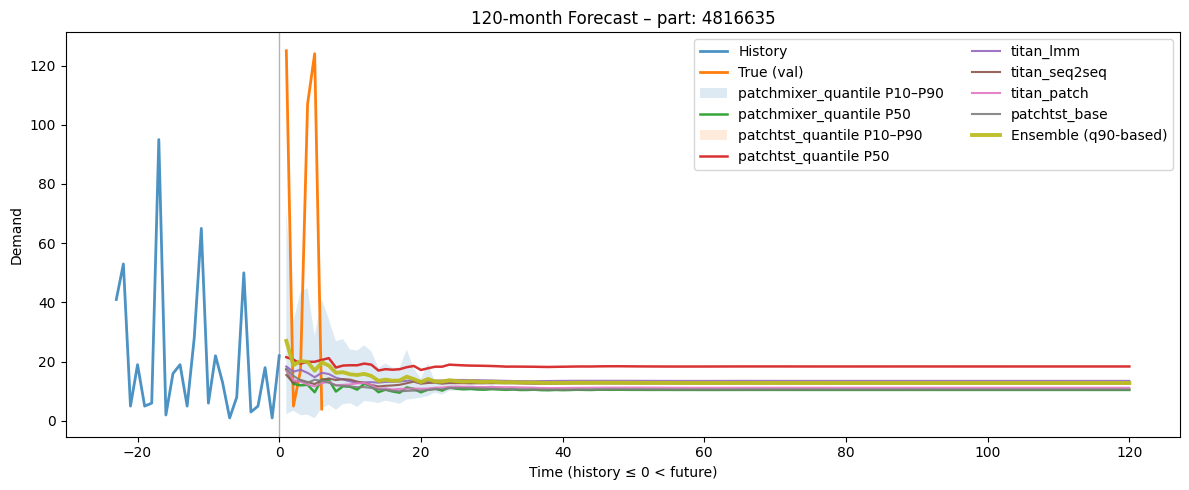

model PatchMixer QuantileModel [DBG] t 0 q10: 21.490291595458984 q50: 47.786521911621094 q90: 113.97498321533203
model PatchMixer QuantileModel [DBG] t 1 q10: 16.733108520507812 q50: 44.71104431152344 q90: 140.8533935546875
model PatchMixer QuantileModel [DBG] t 2 q10: 23.169021606445312 q50: 48.831748962402344 q90: 108.50405883789062
model PatchMixer QuantileModel [DBG] t 3 q10: 18.366512298583984 q50: 44.88508605957031 q90: 134.09779357910156
model PatchMixer QuantileModel [DBG] t 4 q10: 21.58535385131836 q50: 46.70069885253906 q90: 119.59634399414062
model PatchTST QuantileModel [DBG] t 0 q10: 72.45923614501953 q50: 73.41670989990234 q90: 74.49909973144531
model PatchTST QuantileModel [DBG] t 1 q10: 71.56117248535156 q50: 72.5203628540039 q90: 73.5949478149414
model PatchTST QuantileModel [DBG] t 2 q10: 73.95526885986328 q50: 74.89430236816406 q90: 75.95260620117188
model PatchTST QuantileModel [DBG] t 3 q10: 71.8649673461914 q50: 72.78670501708984 q90: 73.832763671875
model PatchTS

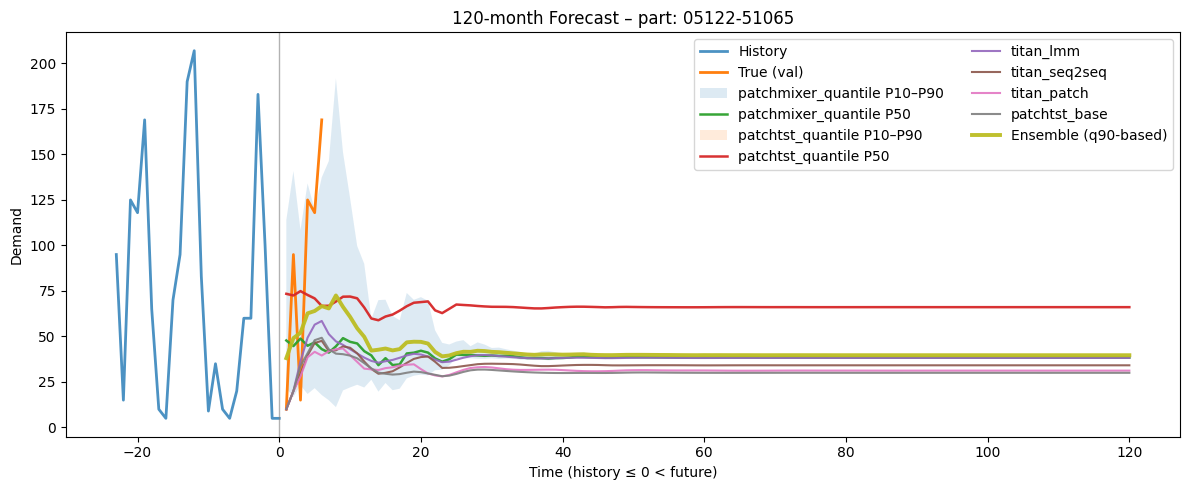

model PatchMixer QuantileModel [DBG] t 0 q10: 1.1160950660705566 q50: 1.8818137645721436 q90: 3.472166061401367
model PatchMixer QuantileModel [DBG] t 1 q10: 1.230536937713623 q50: 2.223975896835327 q90: 6.112448692321777
model PatchMixer QuantileModel [DBG] t 2 q10: 1.4176995754241943 q50: 2.1321144104003906 q90: 4.296762466430664
model PatchMixer QuantileModel [DBG] t 3 q10: 1.3798563480377197 q50: 2.2029027938842773 q90: 5.483878135681152
model PatchMixer QuantileModel [DBG] t 4 q10: 1.464455246925354 q50: 2.4625139236450195 q90: 5.841205596923828
model PatchTST QuantileModel [DBG] t 0 q10: 2.7084295749664307 q50: 2.737467050552368 q90: 2.7699339389801025
model PatchTST QuantileModel [DBG] t 1 q10: 2.7807817459106445 q50: 2.809199333190918 q90: 2.8411757946014404
model PatchTST QuantileModel [DBG] t 2 q10: 2.8560609817504883 q50: 2.8838260173797607 q90: 2.91524600982666
model PatchTST QuantileModel [DBG] t 3 q10: 2.892915725708008 q50: 2.920572280883789 q90: 2.9517858028411865
model

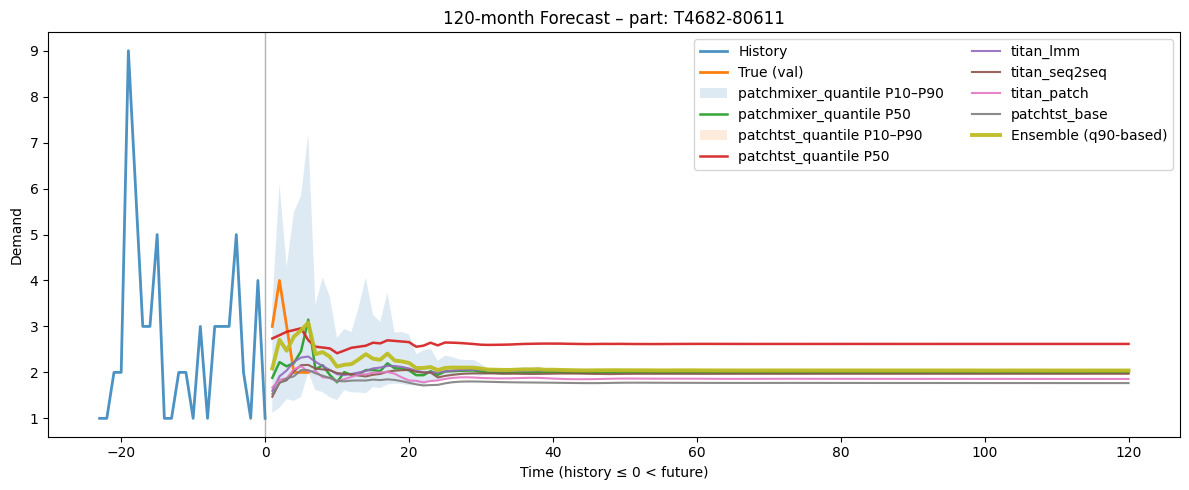

model PatchMixer QuantileModel [DBG] t 0 q10: 7.275768280029297 q50: 14.270980834960938 q90: 32.78033447265625
model PatchMixer QuantileModel [DBG] t 1 q10: 7.010580062866211 q50: 14.982316970825195 q90: 34.44637680053711
model PatchMixer QuantileModel [DBG] t 2 q10: 5.271086692810059 q50: 13.082099914550781 q90: 30.56439971923828
model PatchMixer QuantileModel [DBG] t 3 q10: 6.423426628112793 q50: 15.491558074951172 q90: 49.73835754394531
model PatchMixer QuantileModel [DBG] t 4 q10: 7.140671730041504 q50: 14.544257164001465 q90: 32.477081298828125
model PatchTST QuantileModel [DBG] t 0 q10: 20.834209442138672 q50: 21.12617301940918 q90: 21.452556610107422
model PatchTST QuantileModel [DBG] t 1 q10: 21.2977294921875 q50: 21.587759017944336 q90: 21.911651611328125
model PatchTST QuantileModel [DBG] t 2 q10: 20.946910858154297 q50: 21.23472785949707 q90: 21.558345794677734
model PatchTST QuantileModel [DBG] t 3 q10: 21.623001098632812 q50: 21.906112670898438 q90: 22.224990844726562
mode

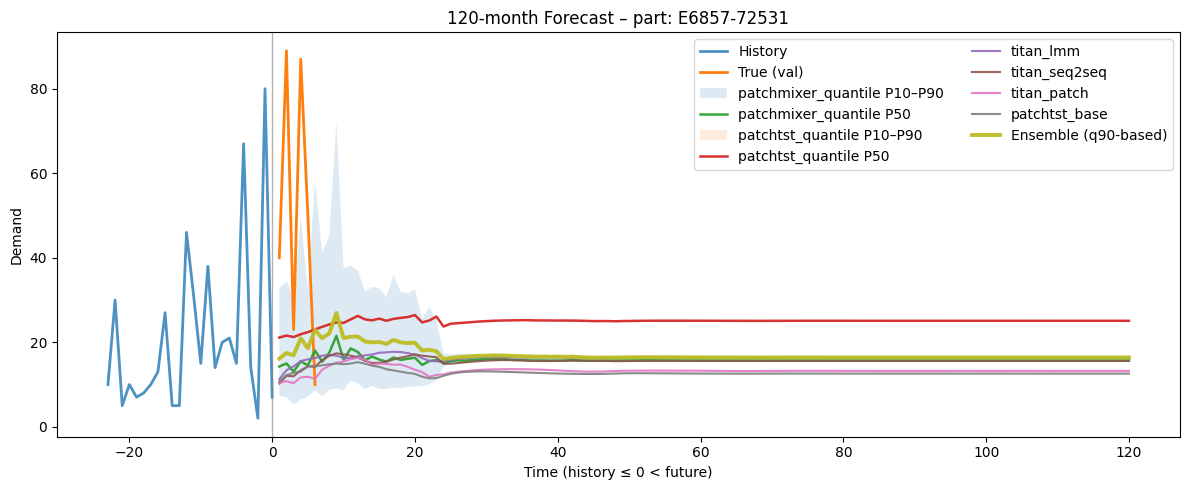

model PatchMixer QuantileModel [DBG] t 0 q10: 5.526218414306641 q50: 9.514814376831055 q90: 23.3692569732666
model PatchMixer QuantileModel [DBG] t 1 q10: 4.321603775024414 q50: 8.894721984863281 q90: 23.538105010986328
model PatchMixer QuantileModel [DBG] t 2 q10: 4.067636966705322 q50: 7.7547287940979 q90: 20.65542984008789
model PatchMixer QuantileModel [DBG] t 3 q10: 5.083679676055908 q50: 8.683067321777344 q90: 17.565723419189453
model PatchMixer QuantileModel [DBG] t 4 q10: 5.005702495574951 q50: 8.763813018798828 q90: 18.890560150146484
model PatchTST QuantileModel [DBG] t 0 q10: 10.917048454284668 q50: 11.049516677856445 q90: 11.197999954223633
model PatchTST QuantileModel [DBG] t 1 q10: 10.876530647277832 q50: 11.008038520812988 q90: 11.157471656799316
model PatchTST QuantileModel [DBG] t 2 q10: 11.127204895019531 q50: 11.257576942443848 q90: 11.405372619628906
model PatchTST QuantileModel [DBG] t 3 q10: 11.47169303894043 q50: 11.600114822387695 q90: 11.744491577148438
model P

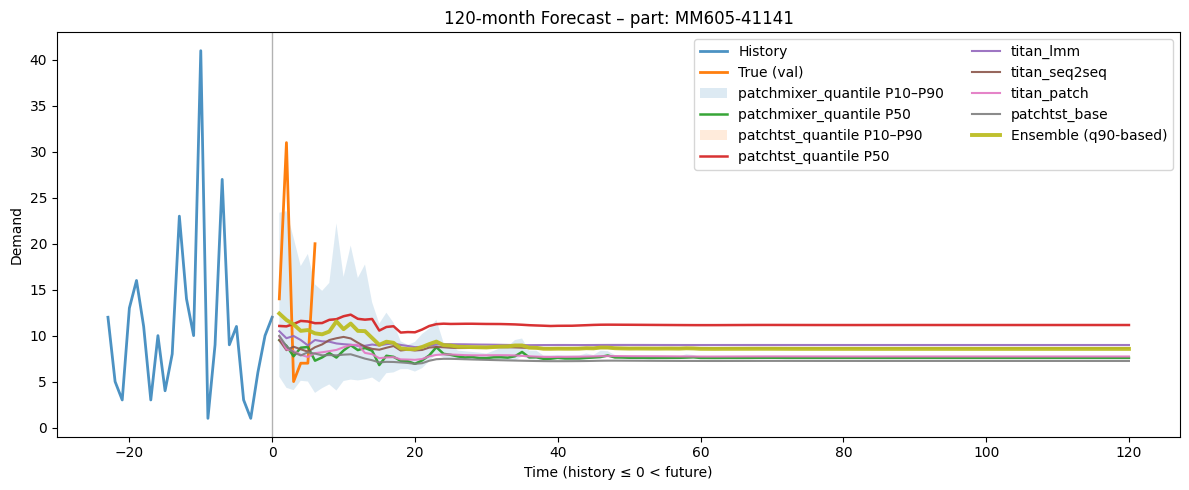

model PatchMixer QuantileModel [DBG] t 0 q10: 0.803791880607605 q50: 1.3468763828277588 q90: 2.7128405570983887
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9448293447494507 q50: 1.446176528930664 q90: 2.4500679969787598
model PatchMixer QuantileModel [DBG] t 2 q10: 0.9453848600387573 q50: 1.5131391286849976 q90: 3.23403263092041
model PatchMixer QuantileModel [DBG] t 3 q10: 0.8747107982635498 q50: 1.399452805519104 q90: 2.7673001289367676
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9274992346763611 q50: 1.4329631328582764 q90: 2.479368209838867
model PatchTST QuantileModel [DBG] t 0 q10: 1.9583641290664673 q50: 1.9779616594314575 q90: 2.0000269412994385
model PatchTST QuantileModel [DBG] t 1 q10: 1.999121069908142 q50: 2.0185399055480957 q90: 2.040292263031006
model PatchTST QuantileModel [DBG] t 2 q10: 1.9998412132263184 q50: 2.0191681385040283 q90: 2.041003465652466
model PatchTST QuantileModel [DBG] t 3 q10: 1.9589743614196777 q50: 1.978026032447815 q90: 1.9996085166931152
m

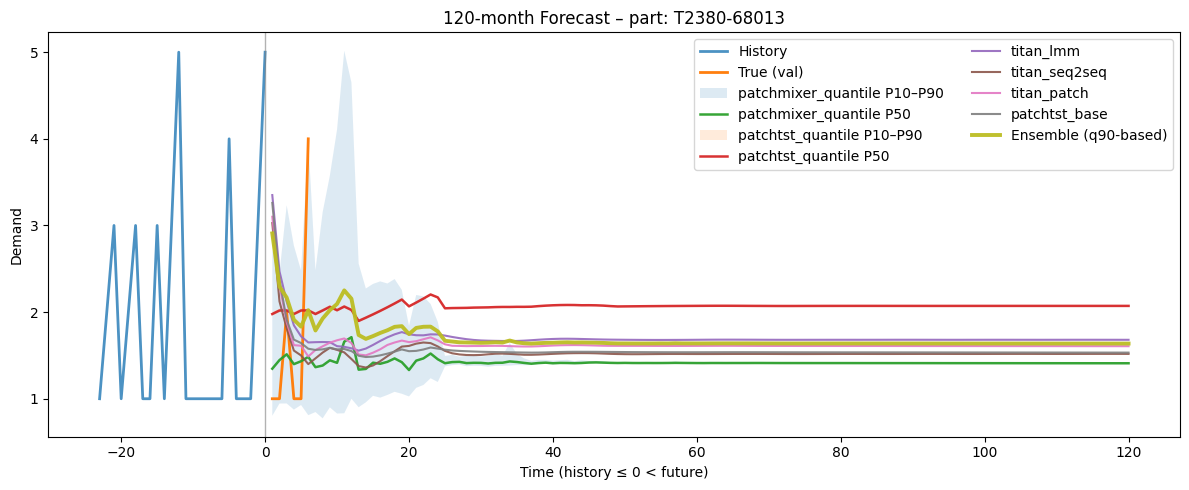

model PatchMixer QuantileModel [DBG] t 0 q10: 1.5951846837997437 q50: 2.4162826538085938 q90: 4.509887218475342
model PatchMixer QuantileModel [DBG] t 1 q10: 1.5130093097686768 q50: 2.40087890625 q90: 5.771445274353027
model PatchMixer QuantileModel [DBG] t 2 q10: 1.4737318754196167 q50: 2.210448980331421 q90: 3.9564201831817627
model PatchMixer QuantileModel [DBG] t 3 q10: 1.4901843070983887 q50: 2.221328020095825 q90: 4.107147693634033
model PatchMixer QuantileModel [DBG] t 4 q10: 1.5914123058319092 q50: 2.312272071838379 q90: 3.936723232269287
model PatchTST QuantileModel [DBG] t 0 q10: 3.166703939437866 q50: 3.196608543395996 q90: 3.230257511138916
model PatchTST QuantileModel [DBG] t 1 q10: 3.008230447769165 q50: 3.0357446670532227 q90: 3.066490888595581
model PatchTST QuantileModel [DBG] t 2 q10: 2.926288604736328 q50: 2.952877998352051 q90: 2.982987403869629
model PatchTST QuantileModel [DBG] t 3 q10: 2.966061592102051 q50: 2.992575168609619 q90: 3.0224356651306152
model PatchTS

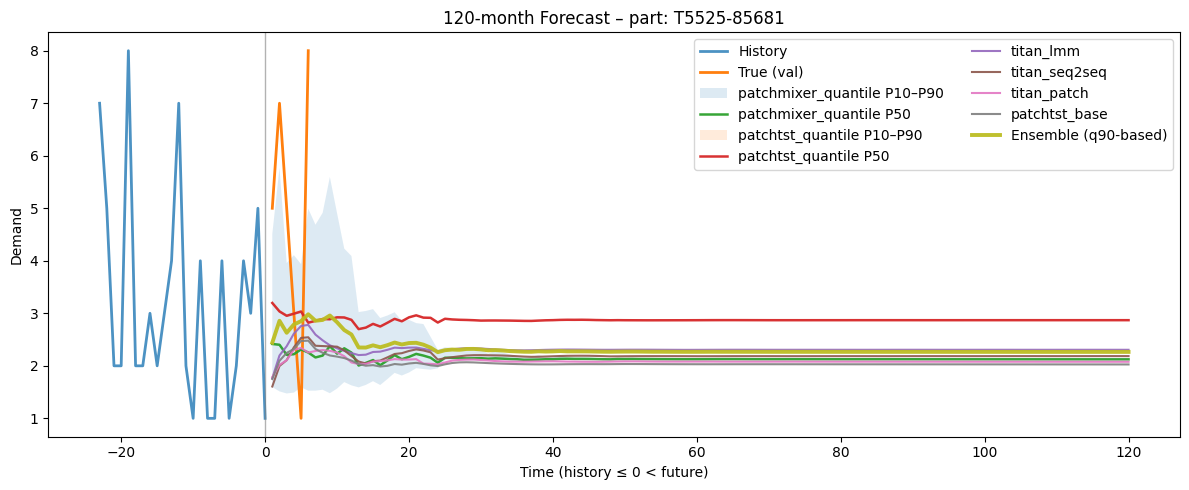

model PatchMixer QuantileModel [DBG] t 0 q10: 13.308631896972656 q50: 64.13322448730469 q90: 200.5287628173828
model PatchMixer QuantileModel [DBG] t 1 q10: 10.879875183105469 q50: 91.39640045166016 q90: 396.3072204589844
model PatchMixer QuantileModel [DBG] t 2 q10: 136.4780731201172 q50: 218.84715270996094 q90: 450.306640625
model PatchMixer QuantileModel [DBG] t 3 q10: 26.526885986328125 q50: 75.96003723144531 q90: 252.7736053466797
model PatchMixer QuantileModel [DBG] t 4 q10: 25.88640594482422 q50: 70.67822265625 q90: 179.62704467773438
model PatchTST QuantileModel [DBG] t 0 q10: 109.45919799804688 q50: 111.41548919677734 q90: 113.61844635009766
model PatchTST QuantileModel [DBG] t 1 q10: 112.97771453857422 q50: 114.92252349853516 q90: 117.1003646850586
model PatchTST QuantileModel [DBG] t 2 q10: 112.59927368164062 q50: 114.53843688964844 q90: 116.7216796875
model PatchTST QuantileModel [DBG] t 3 q10: 100.91020965576172 q50: 102.63347625732422 q90: 104.58173370361328
model PatchTS

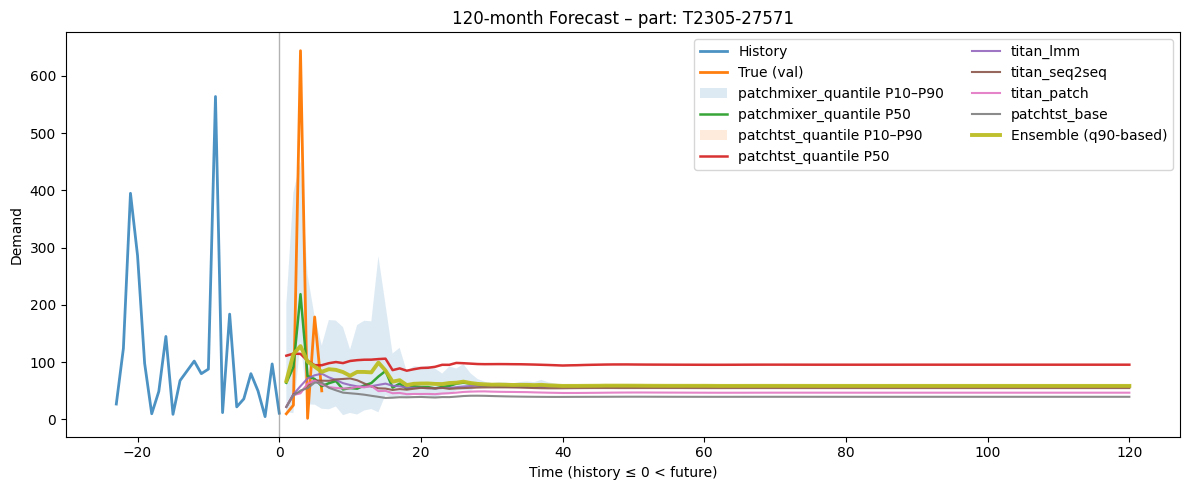

model PatchMixer QuantileModel [DBG] t 0 q10: 10.174243927001953 q50: 21.058542251586914 q90: 46.850914001464844
model PatchMixer QuantileModel [DBG] t 1 q10: 10.752403259277344 q50: 23.04865837097168 q90: 72.28180694580078
model PatchMixer QuantileModel [DBG] t 2 q10: 11.437042236328125 q50: 22.52470588684082 q90: 60.471099853515625
model PatchMixer QuantileModel [DBG] t 3 q10: 10.226644515991211 q50: 21.584362030029297 q90: 64.15087890625
model PatchMixer QuantileModel [DBG] t 4 q10: 11.437681198120117 q50: 25.15350341796875 q90: 76.49180603027344
model PatchTST QuantileModel [DBG] t 0 q10: 29.91756248474121 q50: 30.319305419921875 q90: 30.77190589904785
model PatchTST QuantileModel [DBG] t 1 q10: 30.97162628173828 q50: 31.364688873291016 q90: 31.809202194213867
model PatchTST QuantileModel [DBG] t 2 q10: 31.860450744628906 q50: 32.24808883666992 q90: 32.68629837036133
model PatchTST QuantileModel [DBG] t 3 q10: 31.53960418701172 q50: 31.92820167541504 q90: 32.36367416381836
model Pa

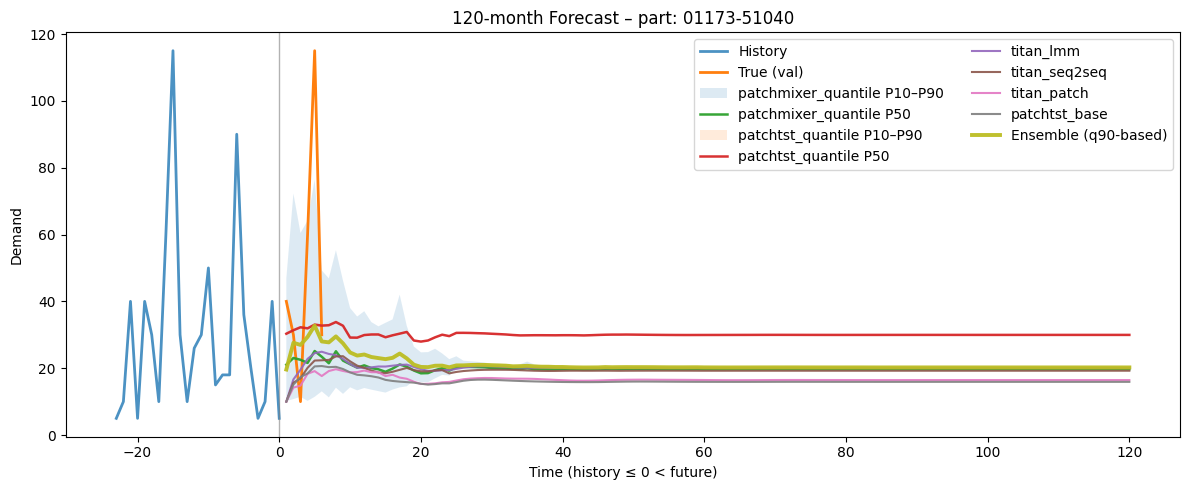

model PatchMixer QuantileModel [DBG] t 0 q10: 9.79904556274414 q50: 20.38987922668457 q90: 61.80421447753906
model PatchMixer QuantileModel [DBG] t 1 q10: 10.914058685302734 q50: 24.13043212890625 q90: 75.7352523803711
model PatchMixer QuantileModel [DBG] t 2 q10: 8.120716094970703 q50: 17.323610305786133 q90: 51.97151565551758
model PatchMixer QuantileModel [DBG] t 3 q10: 8.349666595458984 q50: 17.76510238647461 q90: 41.38056945800781
model PatchMixer QuantileModel [DBG] t 4 q10: 6.5285186767578125 q50: 18.171024322509766 q90: 59.151161193847656
model PatchTST QuantileModel [DBG] t 0 q10: 29.2084903717041 q50: 29.572219848632812 q90: 29.9813289642334
model PatchTST QuantileModel [DBG] t 1 q10: 28.023513793945312 q50: 28.37521743774414 q90: 28.77234649658203
model PatchTST QuantileModel [DBG] t 2 q10: 26.831695556640625 q50: 27.173181533813477 q90: 27.555513381958008
model PatchTST QuantileModel [DBG] t 3 q10: 26.171768188476562 q50: 26.508596420288086 q90: 26.88764762878418
model Patc

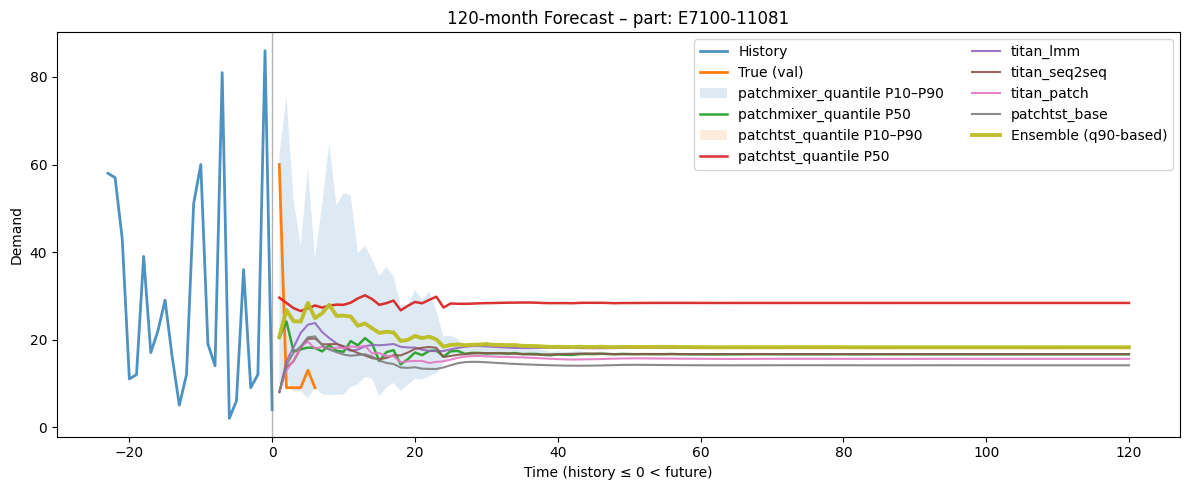

model PatchMixer QuantileModel [DBG] t 0 q10: 9.123859405517578 q50: 15.812707901000977 q90: 41.422061920166016
model PatchMixer QuantileModel [DBG] t 1 q10: 8.89110279083252 q50: 15.69926643371582 q90: 37.895263671875
model PatchMixer QuantileModel [DBG] t 2 q10: 11.600152969360352 q50: 17.560527801513672 q90: 38.62640380859375
model PatchMixer QuantileModel [DBG] t 3 q10: 11.58643913269043 q50: 17.24698257446289 q90: 46.49633026123047
model PatchMixer QuantileModel [DBG] t 4 q10: 16.091209411621094 q50: 28.248212814331055 q90: 64.27093505859375
model PatchTST QuantileModel [DBG] t 0 q10: 20.542388916015625 q50: 20.75823211669922 q90: 21.00050163269043
model PatchTST QuantileModel [DBG] t 1 q10: 21.157052993774414 q50: 21.368127822875977 q90: 21.604507446289062
model PatchTST QuantileModel [DBG] t 2 q10: 21.964704513549805 q50: 22.167381286621094 q90: 22.393835067749023
model PatchTST QuantileModel [DBG] t 3 q10: 22.846275329589844 q50: 23.037601470947266 q90: 23.25191879272461
model 

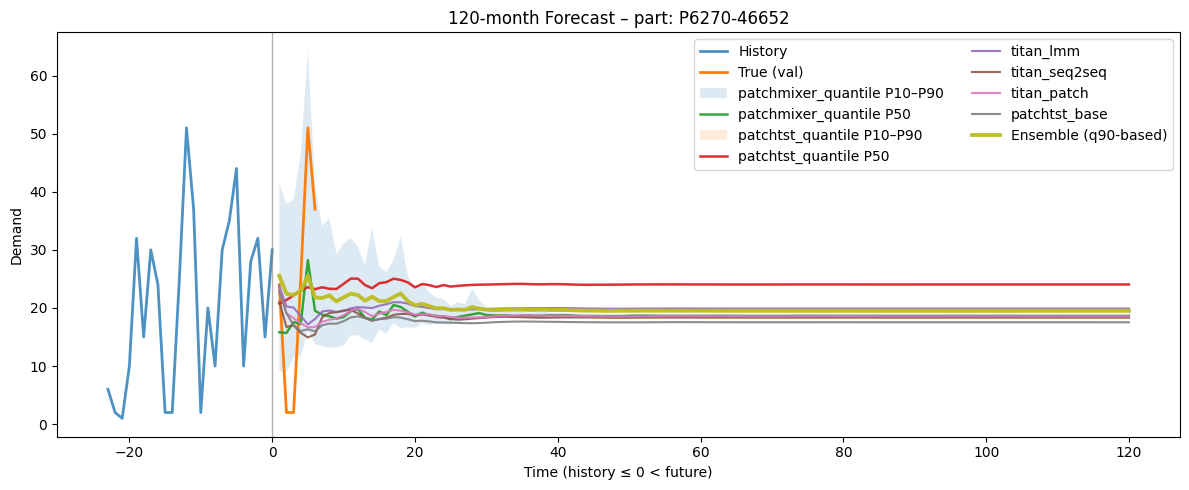

model PatchMixer QuantileModel [DBG] t 0 q10: 62.96245574951172 q50: 97.26251983642578 q90: 197.2216796875
model PatchMixer QuantileModel [DBG] t 1 q10: 84.2191162109375 q50: 126.34841918945312 q90: 276.85052490234375
model PatchMixer QuantileModel [DBG] t 2 q10: 44.45984649658203 q50: 80.99557495117188 q90: 199.01756286621094
model PatchMixer QuantileModel [DBG] t 3 q10: 52.12455749511719 q50: 87.25634765625 q90: 167.6943817138672
model PatchMixer QuantileModel [DBG] t 4 q10: 46.55406188964844 q50: 86.82379150390625 q90: 168.16871643066406
model PatchTST QuantileModel [DBG] t 0 q10: 130.29566955566406 q50: 131.74664306640625 q90: 133.37521362304688
model PatchTST QuantileModel [DBG] t 1 q10: 134.9459686279297 q50: 136.3488311767578 q90: 137.93414306640625
model PatchTST QuantileModel [DBG] t 2 q10: 130.7902374267578 q50: 132.15548706054688 q90: 133.70504760742188
model PatchTST QuantileModel [DBG] t 3 q10: 132.80206298828125 q50: 134.1637725830078 q90: 135.69781494140625
model PatchTS

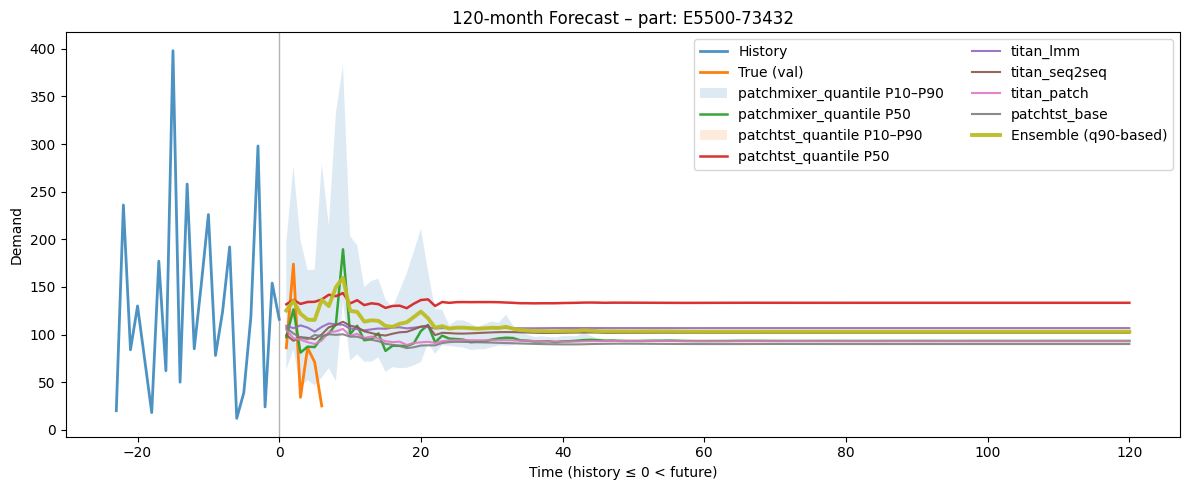

model PatchMixer QuantileModel [DBG] t 0 q10: 6.991518020629883 q50: 12.527753829956055 q90: 27.425922393798828
model PatchMixer QuantileModel [DBG] t 1 q10: 8.679001808166504 q50: 13.971685409545898 q90: 25.302452087402344
model PatchMixer QuantileModel [DBG] t 2 q10: 9.045754432678223 q50: 14.310907363891602 q90: 25.697757720947266
model PatchMixer QuantileModel [DBG] t 3 q10: 7.103963851928711 q50: 13.197261810302734 q90: 34.27314758300781
model PatchMixer QuantileModel [DBG] t 4 q10: 8.297874450683594 q50: 13.696977615356445 q90: 35.95610809326172
model PatchTST QuantileModel [DBG] t 0 q10: 19.332740783691406 q50: 19.53474235534668 q90: 19.76293182373047
model PatchTST QuantileModel [DBG] t 1 q10: 19.231159210205078 q50: 19.43398094177246 q90: 19.660953521728516
model PatchTST QuantileModel [DBG] t 2 q10: 19.54032325744629 q50: 19.74088478088379 q90: 19.96747589111328
model PatchTST QuantileModel [DBG] t 3 q10: 18.404863357543945 q50: 18.586816787719727 q90: 18.79123306274414
model

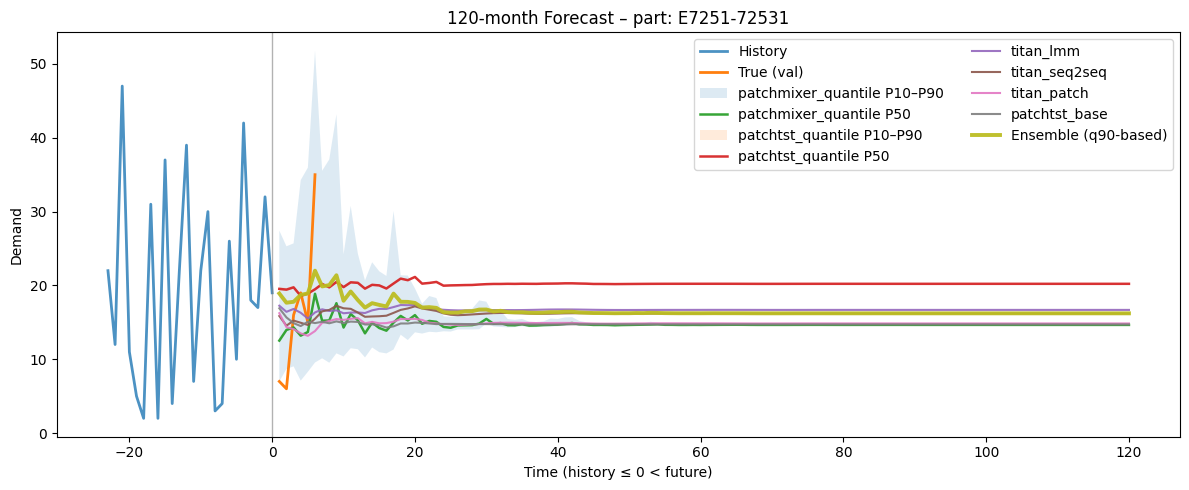

model PatchMixer QuantileModel [DBG] t 0 q10: -0.3919980525970459 q50: 1.8803279399871826 q90: 7.312096118927002
model PatchMixer QuantileModel [DBG] t 1 q10: -0.23476552963256836 q50: 1.974176049232483 q90: 7.009917736053467
model PatchMixer QuantileModel [DBG] t 2 q10: -0.21605563163757324 q50: 2.2002549171447754 q90: 8.770699501037598
model PatchMixer QuantileModel [DBG] t 3 q10: -0.10694026947021484 q50: 2.3217482566833496 q90: 8.935490608215332
model PatchMixer QuantileModel [DBG] t 4 q10: 0.33446598052978516 q50: 2.6514527797698975 q90: 8.07217025756836
model PatchTST QuantileModel [DBG] t 0 q10: 3.958524703979492 q50: 4.044478416442871 q90: 4.1402812004089355
model PatchTST QuantileModel [DBG] t 1 q10: 3.8353872299194336 q50: 3.9206011295318604 q90: 4.016046047210693
model PatchTST QuantileModel [DBG] t 2 q10: 3.956878662109375 q50: 4.041209697723389 q90: 4.136460304260254
model PatchTST QuantileModel [DBG] t 3 q10: 4.083698272705078 q50: 4.167783260345459 q90: 4.262290477752685

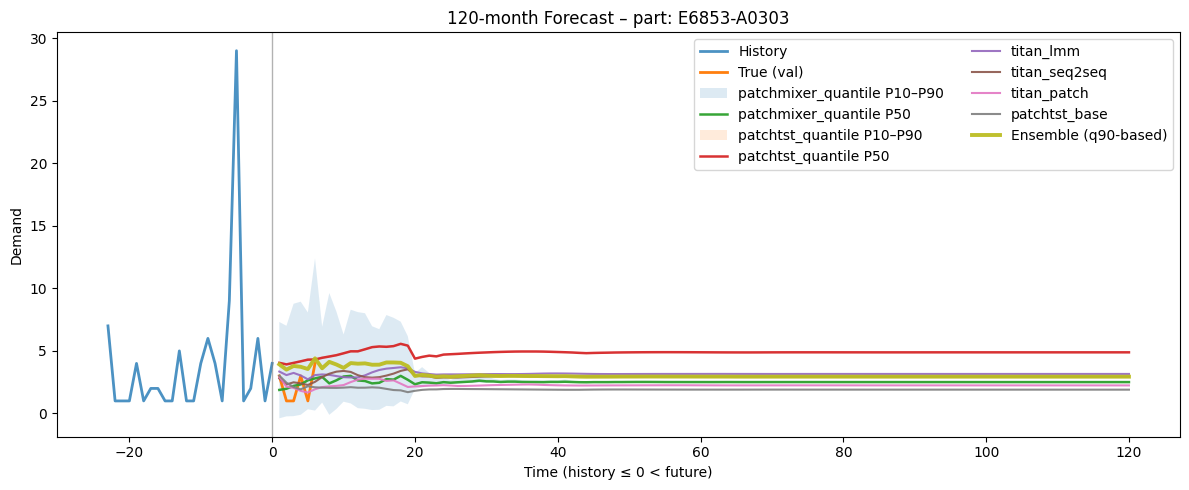

model PatchMixer QuantileModel [DBG] t 0 q10: 0.4449472427368164 q50: 4.786167621612549 q90: 22.008350372314453
model PatchMixer QuantileModel [DBG] t 1 q10: 2.1588168144226074 q50: 5.943864822387695 q90: 15.064400672912598
model PatchMixer QuantileModel [DBG] t 2 q10: 2.1485915184020996 q50: 5.791463851928711 q90: 14.348064422607422
model PatchMixer QuantileModel [DBG] t 3 q10: 2.5266613960266113 q50: 6.155037879943848 q90: 14.84105396270752
model PatchMixer QuantileModel [DBG] t 4 q10: 1.1930007934570312 q50: 6.124322414398193 q90: 25.434581756591797
model PatchTST QuantileModel [DBG] t 0 q10: 8.499804496765137 q50: 8.640703201293945 q90: 8.799826622009277
model PatchTST QuantileModel [DBG] t 1 q10: 8.818617820739746 q50: 8.957921028137207 q90: 9.114547729492188
model PatchTST QuantileModel [DBG] t 2 q10: 9.066940307617188 q50: 9.205245018005371 q90: 9.360374450683594
model PatchTST QuantileModel [DBG] t 3 q10: 9.409208297729492 q50: 9.545919418334961 q90: 9.69786262512207
model Patc

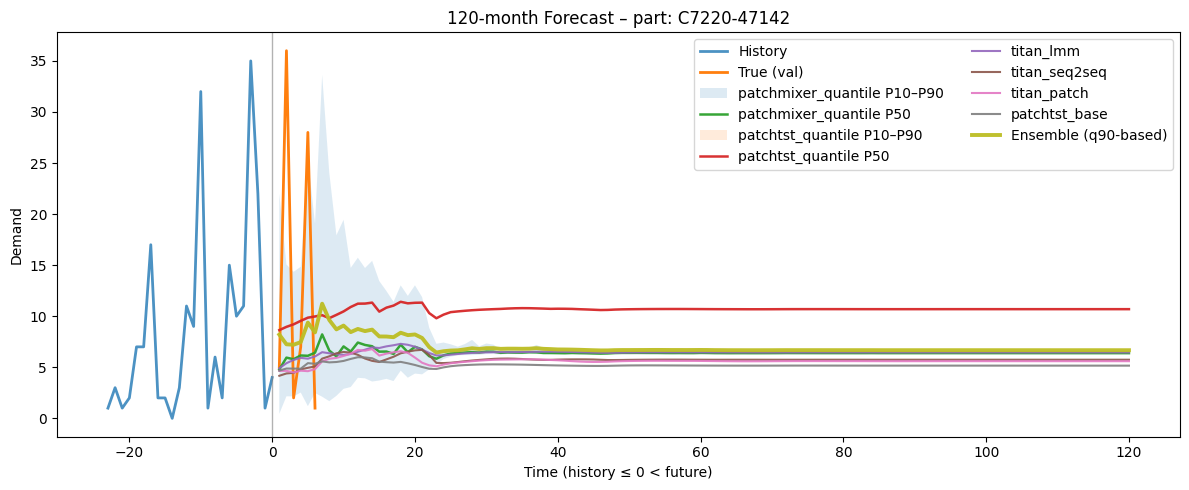

model PatchMixer QuantileModel [DBG] t 0 q10: 3.501143455505371 q50: 8.390758514404297 q90: 25.87920379638672
model PatchMixer QuantileModel [DBG] t 1 q10: 4.724040508270264 q50: 10.064720153808594 q90: 27.09897232055664
model PatchMixer QuantileModel [DBG] t 2 q10: 3.392916679382324 q50: 10.522756576538086 q90: 38.528656005859375
model PatchMixer QuantileModel [DBG] t 3 q10: 1.634202003479004 q50: 6.6768693923950195 q90: 25.462108612060547
model PatchMixer QuantileModel [DBG] t 4 q10: 3.2813820838928223 q50: 7.667897701263428 q90: 20.741199493408203
model PatchTST QuantileModel [DBG] t 0 q10: 12.50041675567627 q50: 12.684864044189453 q90: 12.891693115234375
model PatchTST QuantileModel [DBG] t 1 q10: 12.653783798217773 q50: 12.83816146850586 q90: 13.044107437133789
model PatchTST QuantileModel [DBG] t 2 q10: 12.438019752502441 q50: 12.620002746582031 q90: 12.82644271850586
model PatchTST QuantileModel [DBG] t 3 q10: 11.0477876663208 q50: 11.197535514831543 q90: 11.36629581451416
model

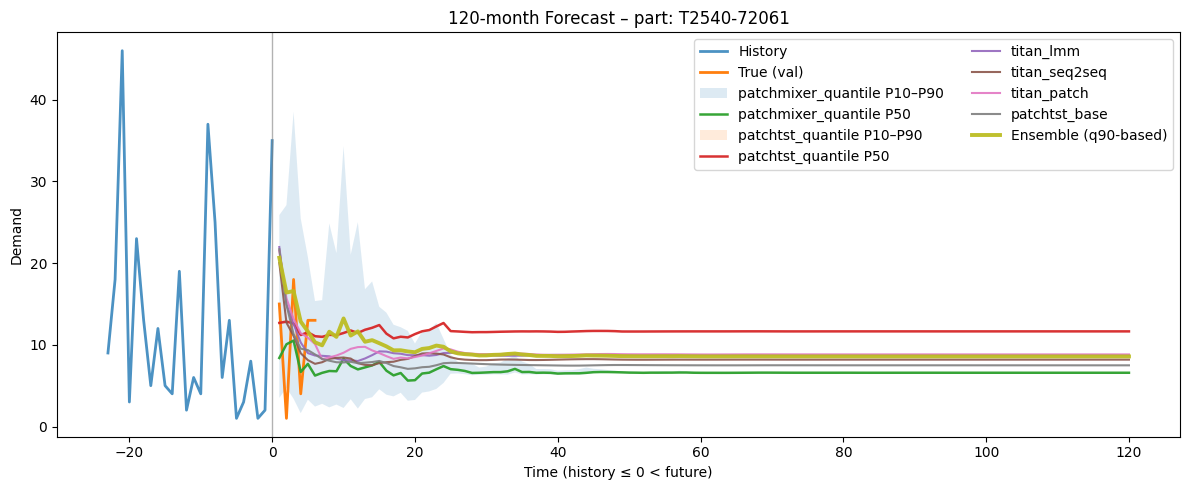

model PatchMixer QuantileModel [DBG] t 0 q10: 8.436225891113281 q50: 36.19337463378906 q90: 103.16641235351562
model PatchMixer QuantileModel [DBG] t 1 q10: 6.250328063964844 q50: 31.65334701538086 q90: 87.08756256103516
model PatchMixer QuantileModel [DBG] t 2 q10: 14.352575302124023 q50: 24.666954040527344 q90: 56.86394119262695
model PatchMixer QuantileModel [DBG] t 3 q10: 17.70228385925293 q50: 29.073347091674805 q90: 63.97785186767578
model PatchMixer QuantileModel [DBG] t 4 q10: 16.681076049804688 q50: 26.44011116027832 q90: 51.06428527832031
model PatchTST QuantileModel [DBG] t 0 q10: 47.667991638183594 q50: 48.67744445800781 q90: 49.80600357055664
model PatchTST QuantileModel [DBG] t 1 q10: 49.48513412475586 q50: 50.480289459228516 q90: 51.601585388183594
model PatchTST QuantileModel [DBG] t 2 q10: 37.21686553955078 q50: 37.59410858154297 q90: 38.01445770263672
model PatchTST QuantileModel [DBG] t 3 q10: 37.990291595458984 q50: 38.36181640625 q90: 38.778324127197266
model Patch

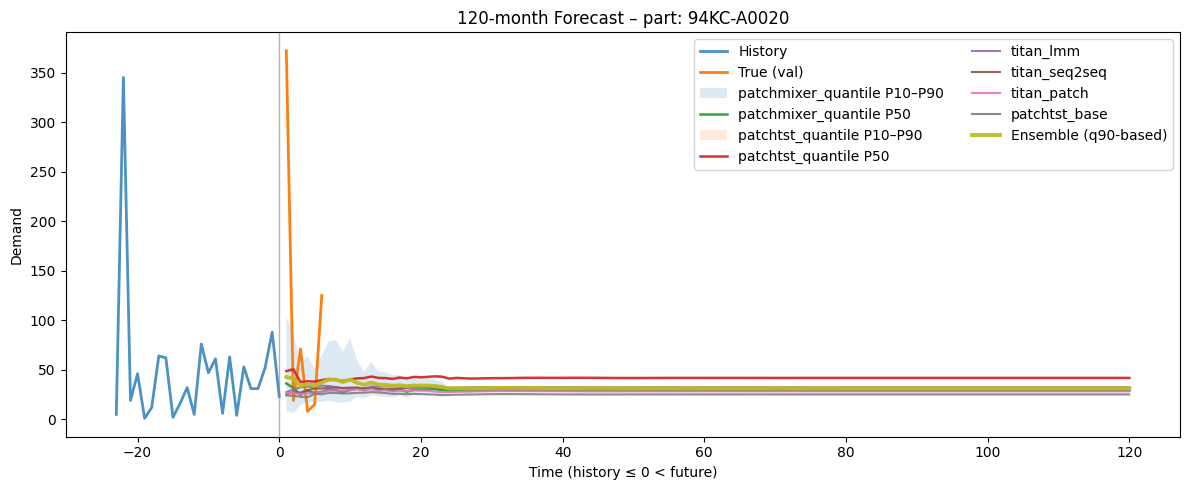

model PatchMixer QuantileModel [DBG] t 0 q10: 0.950946569442749 q50: 1.750549077987671 q90: 4.9315385818481445
model PatchMixer QuantileModel [DBG] t 1 q10: 1.366914987564087 q50: 2.0783605575561523 q90: 3.75083065032959
model PatchMixer QuantileModel [DBG] t 2 q10: 1.2107348442077637 q50: 1.9229381084442139 q90: 3.7786865234375
model PatchMixer QuantileModel [DBG] t 3 q10: 1.3994965553283691 q50: 2.04408597946167 q90: 3.4015979766845703
model PatchMixer QuantileModel [DBG] t 4 q10: 1.3723012208938599 q50: 2.146605968475342 q90: 4.586518287658691
model PatchTST QuantileModel [DBG] t 0 q10: 2.541745901107788 q50: 2.568145990371704 q90: 2.5977590084075928
model PatchTST QuantileModel [DBG] t 1 q10: 2.6070282459259033 q50: 2.6328752040863037 q90: 2.6620841026306152
model PatchTST QuantileModel [DBG] t 2 q10: 2.6750495433807373 q50: 2.700516700744629 q90: 2.729063034057617
model PatchTST QuantileModel [DBG] t 3 q10: 2.745967149734497 q50: 2.7708892822265625 q90: 2.798821449279785
model Pat

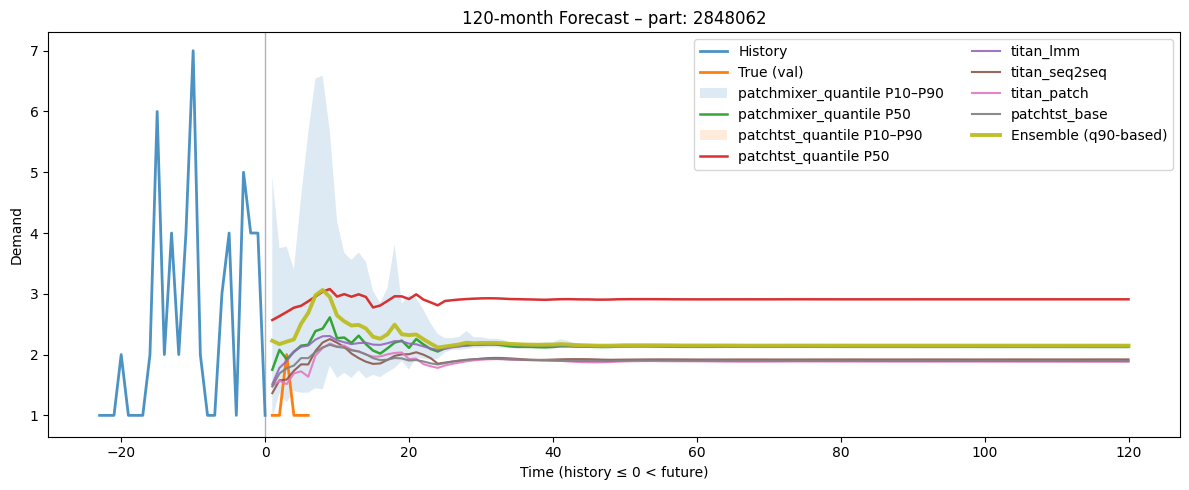

model PatchMixer QuantileModel [DBG] t 0 q10: -0.23893451690673828 q50: 7.280600070953369 q90: 38.739715576171875
model PatchMixer QuantileModel [DBG] t 1 q10: -0.8770904541015625 q50: 6.979991436004639 q90: 34.777652740478516
model PatchMixer QuantileModel [DBG] t 2 q10: 1.8739938735961914 q50: 9.571589469909668 q90: 38.90506362915039
model PatchMixer QuantileModel [DBG] t 3 q10: 1.126657485961914 q50: 9.02092456817627 q90: 34.808528900146484
model PatchMixer QuantileModel [DBG] t 4 q10: 1.1459102630615234 q50: 8.712881088256836 q90: 31.233287811279297
model PatchTST QuantileModel [DBG] t 0 q10: 12.081690788269043 q50: 12.32932186126709 q90: 12.6119384765625
model PatchTST QuantileModel [DBG] t 1 q10: 12.347352027893066 q50: 12.596834182739258 q90: 12.876009941101074
model PatchTST QuantileModel [DBG] t 2 q10: 12.830946922302246 q50: 13.077552795410156 q90: 13.354399681091309
model PatchTST QuantileModel [DBG] t 3 q10: 13.166953086853027 q50: 13.411738395690918 q90: 13.687639236450195

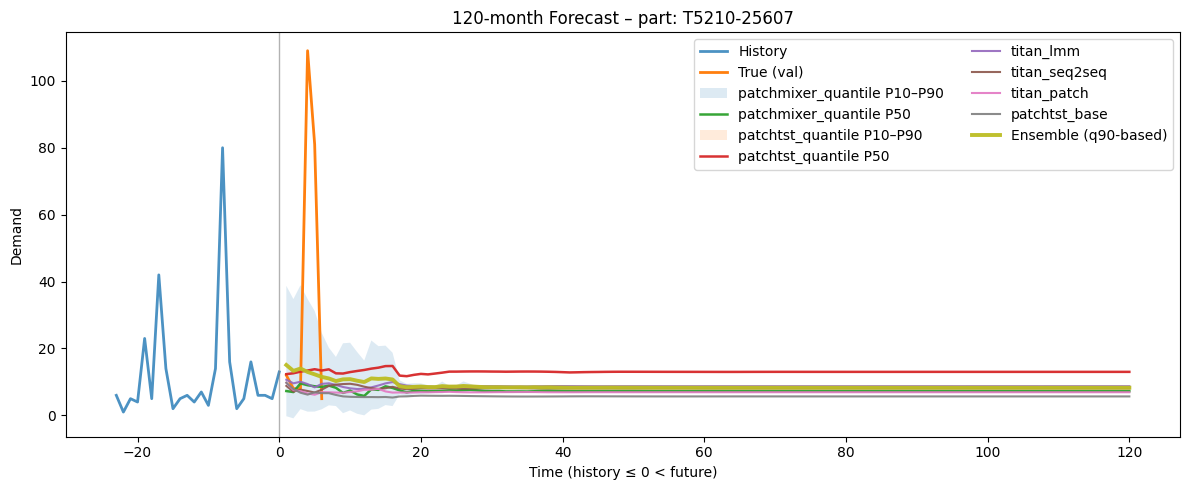

model PatchMixer QuantileModel [DBG] t 0 q10: 17.828420639038086 q50: 28.316387176513672 q90: 68.97631072998047
model PatchMixer QuantileModel [DBG] t 1 q10: 15.971611022949219 q50: 27.279977798461914 q90: 70.89959716796875
model PatchMixer QuantileModel [DBG] t 2 q10: 14.928421020507812 q50: 24.99030303955078 q90: 70.50469207763672
model PatchMixer QuantileModel [DBG] t 3 q10: 15.2682523727417 q50: 24.28257179260254 q90: 62.92192840576172
model PatchMixer QuantileModel [DBG] t 4 q10: 14.848761558532715 q50: 29.356653213500977 q90: 81.99566650390625
model PatchTST QuantileModel [DBG] t 0 q10: 35.12351608276367 q50: 35.468997955322266 q90: 35.86111831665039
model PatchTST QuantileModel [DBG] t 1 q10: 33.18629455566406 q50: 33.50105285644531 q90: 33.855445861816406
model PatchTST QuantileModel [DBG] t 2 q10: 32.04087448120117 q50: 32.344970703125 q90: 32.68446350097656
model PatchTST QuantileModel [DBG] t 3 q10: 31.09698486328125 q50: 31.391258239746094 q90: 31.722139358520508
model Patc

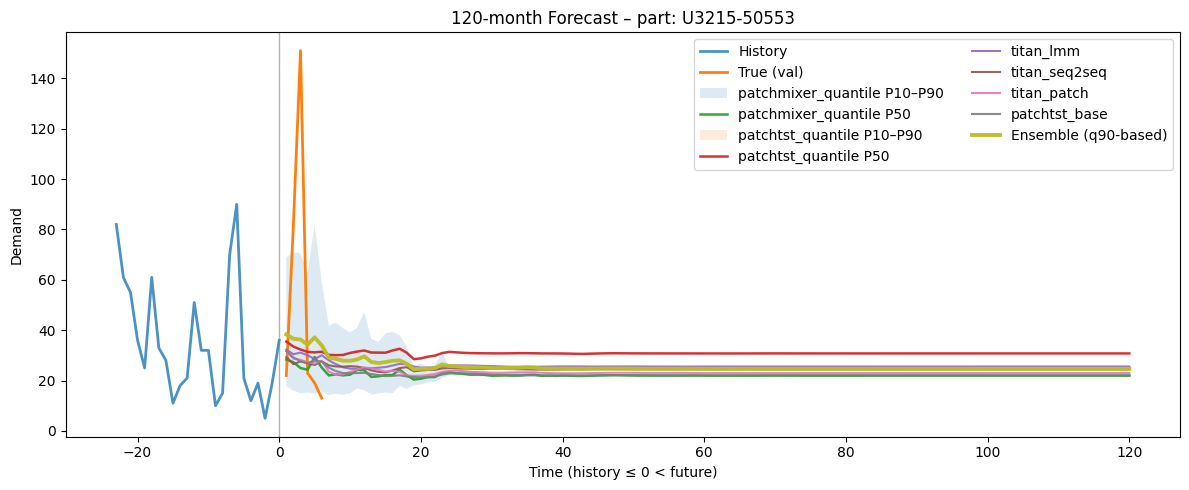

model PatchMixer QuantileModel [DBG] t 0 q10: 0.985649585723877 q50: 4.158742904663086 q90: 11.780057907104492
model PatchMixer QuantileModel [DBG] t 1 q10: 0.5674643516540527 q50: 3.63790225982666 q90: 10.897052764892578
model PatchMixer QuantileModel [DBG] t 2 q10: 0.5247631072998047 q50: 3.5638675689697266 q90: 9.063811302185059
model PatchMixer QuantileModel [DBG] t 3 q10: 1.0856890678405762 q50: 4.200967788696289 q90: 13.17025375366211
model PatchMixer QuantileModel [DBG] t 4 q10: 1.4770703315734863 q50: 4.593077182769775 q90: 12.226211547851562
model PatchTST QuantileModel [DBG] t 0 q10: 6.249739646911621 q50: 6.3663249015808105 q90: 6.497784614562988
model PatchTST QuantileModel [DBG] t 1 q10: 6.430878639221191 q50: 6.545521259307861 q90: 6.676908016204834
model PatchTST QuantileModel [DBG] t 2 q10: 6.621720790863037 q50: 6.737215995788574 q90: 6.866511821746826
model PatchTST QuantileModel [DBG] t 3 q10: 6.777270317077637 q50: 6.892070770263672 q90: 7.020615100860596
model Patc

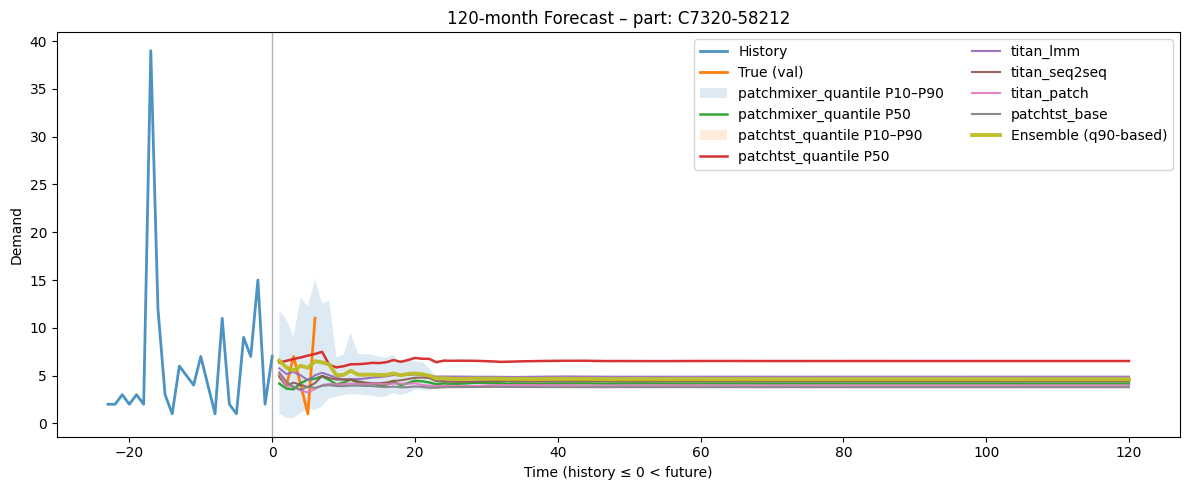

model PatchMixer QuantileModel [DBG] t 0 q10: 2.7721452713012695 q50: 5.620758533477783 q90: 15.249332427978516
model PatchMixer QuantileModel [DBG] t 1 q10: 2.500420570373535 q50: 6.09967041015625 q90: 17.87970542907715
model PatchMixer QuantileModel [DBG] t 2 q10: 2.1871442794799805 q50: 6.463576793670654 q90: 21.585412979125977
model PatchMixer QuantileModel [DBG] t 3 q10: 2.690208911895752 q50: 7.001911163330078 q90: 22.815414428710938
model PatchMixer QuantileModel [DBG] t 4 q10: 3.3901679515838623 q50: 5.338064670562744 q90: 12.348352432250977
model PatchTST QuantileModel [DBG] t 0 q10: 7.208336353302002 q50: 7.28488302230835 q90: 7.371272087097168
model PatchTST QuantileModel [DBG] t 1 q10: 7.178647994995117 q50: 7.255249500274658 q90: 7.341436386108398
model PatchTST QuantileModel [DBG] t 2 q10: 7.397295951843262 q50: 7.471735954284668 q90: 7.556265830993652
model PatchTST QuantileModel [DBG] t 3 q10: 7.125641822814941 q50: 7.197856903076172 q90: 7.278646469116211
model PatchTS

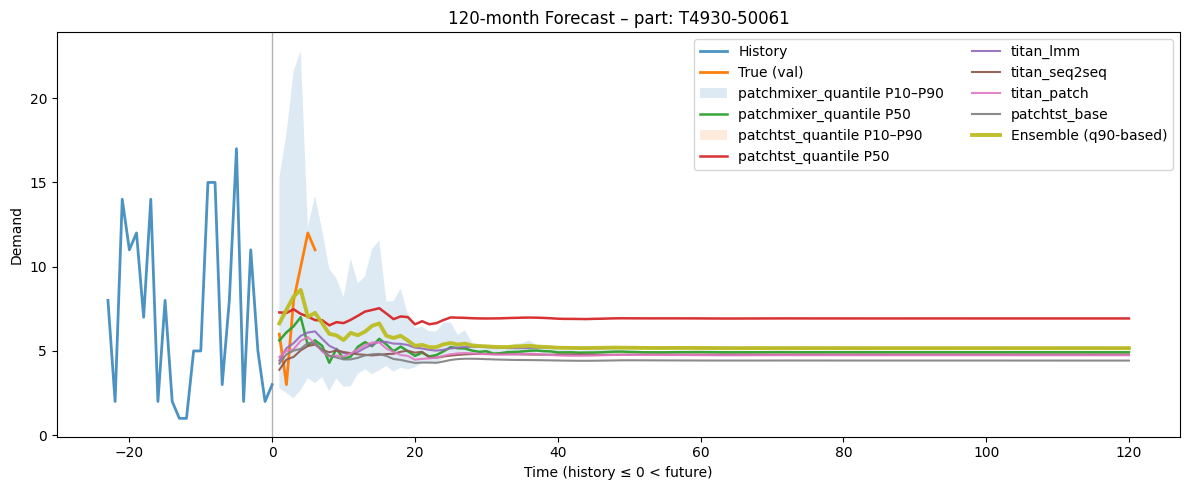

model PatchMixer QuantileModel [DBG] t 0 q10: 1.3510961532592773 q50: 3.207911491394043 q90: 7.634325981140137
model PatchMixer QuantileModel [DBG] t 1 q10: 1.8963737487792969 q50: 3.693466901779175 q90: 8.103863716125488
model PatchMixer QuantileModel [DBG] t 2 q10: 1.2679321765899658 q50: 3.351954221725464 q90: 12.770598411560059
model PatchMixer QuantileModel [DBG] t 3 q10: 1.7032296657562256 q50: 3.542912483215332 q90: 8.286230087280273
model PatchMixer QuantileModel [DBG] t 4 q10: 1.3950660228729248 q50: 3.5262999534606934 q90: 11.64811897277832
model PatchTST QuantileModel [DBG] t 0 q10: 5.125141620635986 q50: 5.192307949066162 q90: 5.267570495605469
model PatchTST QuantileModel [DBG] t 1 q10: 5.299875259399414 q50: 5.365803241729736 q90: 5.439676284790039
model PatchTST QuantileModel [DBG] t 2 q10: 5.190009593963623 q50: 5.2554473876953125 q90: 5.328702926635742
model PatchTST QuantileModel [DBG] t 3 q10: 5.242166042327881 q50: 5.307109355926514 q90: 5.380519390106201
model Patc

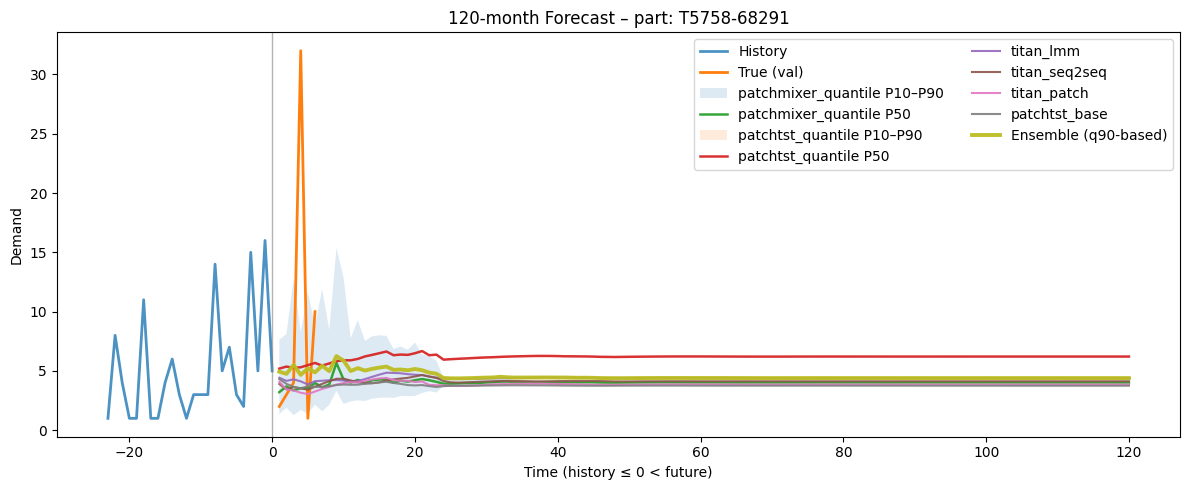

model PatchMixer QuantileModel [DBG] t 0 q10: 0.8580784797668457 q50: 1.4988751411437988 q90: 4.558074951171875
model PatchMixer QuantileModel [DBG] t 1 q10: 1.0745182037353516 q50: 1.7065625190734863 q90: 3.807889223098755
model PatchMixer QuantileModel [DBG] t 2 q10: 0.894828200340271 q50: 1.911515474319458 q90: 5.102993965148926
model PatchMixer QuantileModel [DBG] t 3 q10: 1.020010232925415 q50: 1.5101264715194702 q90: 2.6560049057006836
model PatchMixer QuantileModel [DBG] t 4 q10: 0.981431245803833 q50: 1.5325305461883545 q90: 3.521733283996582
model PatchTST QuantileModel [DBG] t 0 q10: 2.08315372467041 q50: 2.1054205894470215 q90: 2.1308910846710205
model PatchTST QuantileModel [DBG] t 1 q10: 2.1294286251068115 q50: 2.151634931564331 q90: 2.176647901535034
model PatchTST QuantileModel [DBG] t 2 q10: 2.1357016563415527 q50: 2.15793776512146 q90: 2.1828887462615967
model PatchTST QuantileModel [DBG] t 3 q10: 1.9756344556808472 q50: 1.9942508935928345 q90: 2.015235424041748
model 

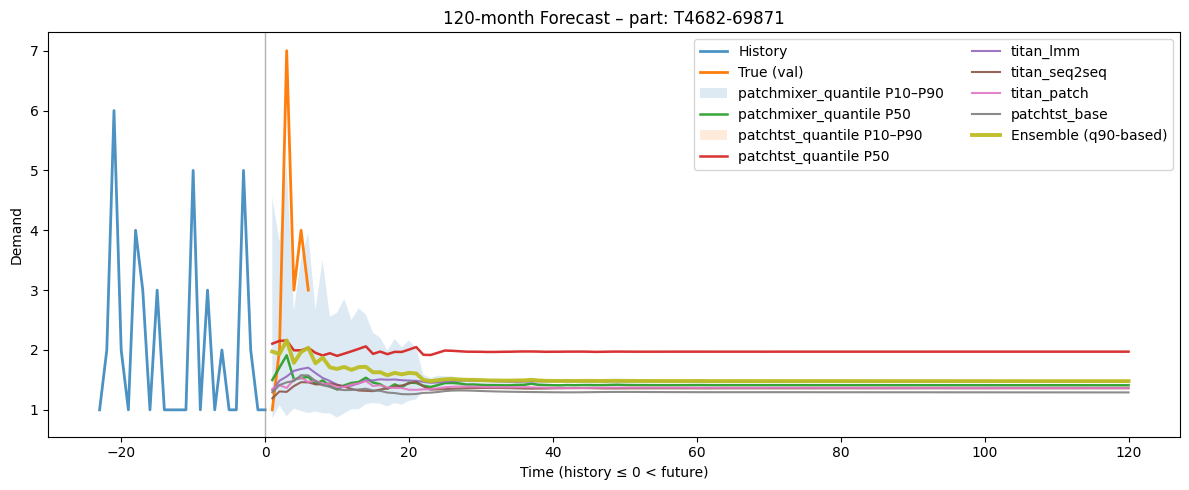

model PatchMixer QuantileModel [DBG] t 0 q10: 15.013487815856934 q50: 27.359773635864258 q90: 72.186767578125
model PatchMixer QuantileModel [DBG] t 1 q10: 21.353797912597656 q50: 30.848506927490234 q90: 68.77105712890625
model PatchMixer QuantileModel [DBG] t 2 q10: 17.669639587402344 q50: 23.523883819580078 q90: 44.01033020019531
model PatchMixer QuantileModel [DBG] t 3 q10: 20.324947357177734 q50: 27.217472076416016 q90: 51.77922439575195
model PatchMixer QuantileModel [DBG] t 4 q10: 16.191404342651367 q50: 21.273181915283203 q90: 35.47821044921875
model PatchTST QuantileModel [DBG] t 0 q10: 30.70838737487793 q50: 30.97500228881836 q90: 31.275014877319336
model PatchTST QuantileModel [DBG] t 1 q10: 31.706623077392578 q50: 31.961753845214844 q90: 32.250396728515625
model PatchTST QuantileModel [DBG] t 2 q10: 29.872976303100586 q50: 30.0887508392334 q90: 30.330781936645508
model PatchTST QuantileModel [DBG] t 3 q10: 30.16798973083496 q50: 30.382905960083008 q90: 30.623512268066406
mod

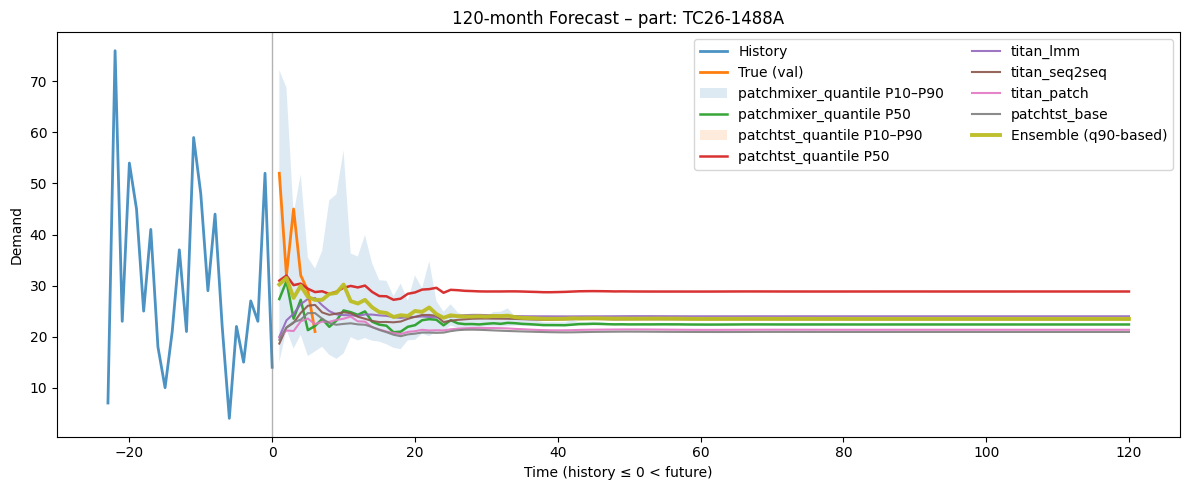

model PatchMixer QuantileModel [DBG] t 0 q10: 1.8723368644714355 q50: 3.4974899291992188 q90: 7.843716621398926
model PatchMixer QuantileModel [DBG] t 1 q10: 1.722303867340088 q50: 3.324592113494873 q90: 7.660184860229492
model PatchMixer QuantileModel [DBG] t 2 q10: 1.3560996055603027 q50: 2.6872262954711914 q90: 6.077037811279297
model PatchMixer QuantileModel [DBG] t 3 q10: 1.91353178024292 q50: 3.3170676231384277 q90: 7.383162021636963
model PatchMixer QuantileModel [DBG] t 4 q10: 1.4588563442230225 q50: 2.705374240875244 q90: 5.650455474853516
model PatchTST QuantileModel [DBG] t 0 q10: 4.5000433921813965 q50: 4.554912567138672 q90: 4.616477966308594
model PatchTST QuantileModel [DBG] t 1 q10: 4.481437683105469 q50: 4.536198139190674 q90: 4.59777307510376
model PatchTST QuantileModel [DBG] t 2 q10: 4.128792762756348 q50: 4.176572799682617 q90: 4.230494976043701
model PatchTST QuantileModel [DBG] t 3 q10: 4.261223793029785 q50: 4.308232307434082 q90: 4.3608174324035645
model PatchT

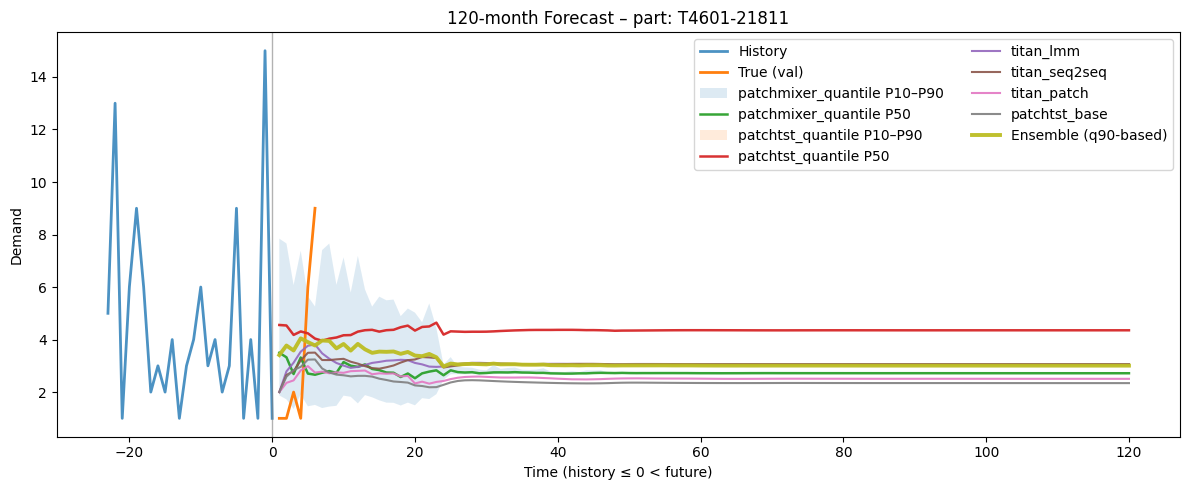

model PatchMixer QuantileModel [DBG] t 0 q10: 9.67184829711914 q50: 37.52014923095703 q90: 102.60513305664062
model PatchMixer QuantileModel [DBG] t 1 q10: 2.2547378540039062 q50: 29.916004180908203 q90: 96.1553955078125
model PatchMixer QuantileModel [DBG] t 2 q10: 2.825366973876953 q50: 29.239261627197266 q90: 81.22099304199219
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9570808410644531 q50: 32.920066833496094 q90: 136.50987243652344
model PatchMixer QuantileModel [DBG] t 4 q10: 1.8502540588378906 q50: 29.014720916748047 q90: 98.766357421875
model PatchTST QuantileModel [DBG] t 0 q10: 56.87511444091797 q50: 57.89854049682617 q90: 59.05574035644531
model PatchTST QuantileModel [DBG] t 1 q10: 56.618194580078125 q50: 57.641353607177734 q90: 58.7988166809082
model PatchTST QuantileModel [DBG] t 2 q10: 57.686336517333984 q50: 58.707401275634766 q90: 59.85909652709961
model PatchTST QuantileModel [DBG] t 3 q10: 57.51506423950195 q50: 58.543663024902344 q90: 59.69304275512695
model Pat

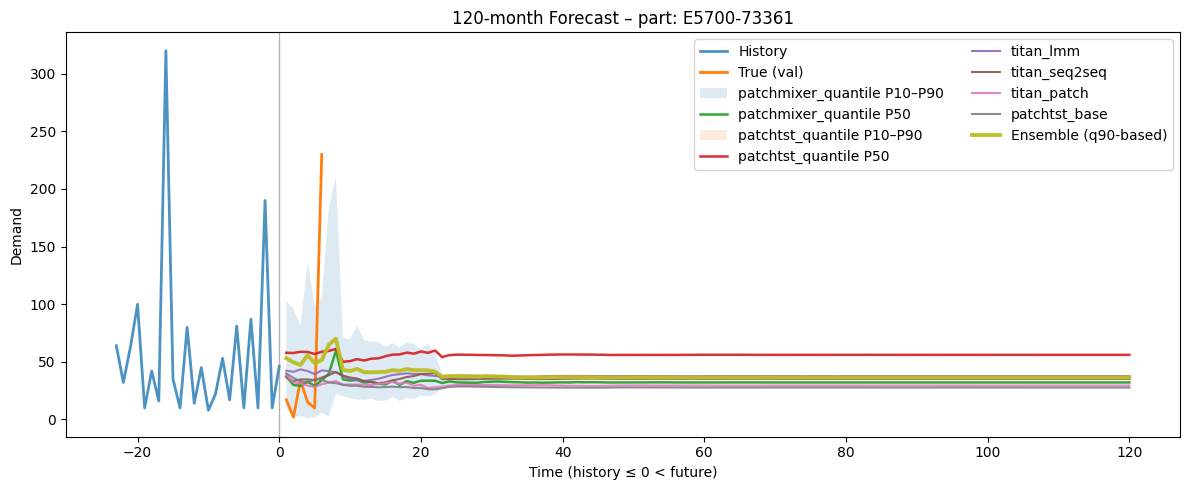

model PatchMixer QuantileModel [DBG] t 0 q10: 1.265937328338623 q50: 4.785989761352539 q90: 18.19612693786621
model PatchMixer QuantileModel [DBG] t 1 q10: 1.778834581375122 q50: 4.054664134979248 q90: 13.114885330200195
model PatchMixer QuantileModel [DBG] t 2 q10: 1.5158882141113281 q50: 3.061675548553467 q90: 6.694498062133789
model PatchMixer QuantileModel [DBG] t 3 q10: 1.6900064945220947 q50: 3.018850326538086 q90: 6.717329025268555
model PatchMixer QuantileModel [DBG] t 4 q10: 1.5476174354553223 q50: 2.7877612113952637 q90: 5.765556812286377
model PatchTST QuantileModel [DBG] t 0 q10: 4.833267688751221 q50: 4.894162654876709 q90: 4.9629340171813965
model PatchTST QuantileModel [DBG] t 1 q10: 4.662383556365967 q50: 4.722131252288818 q90: 4.789182186126709
model PatchTST QuantileModel [DBG] t 2 q10: 4.400692462921143 q50: 4.456932544708252 q90: 4.520212173461914
model PatchTST QuantileModel [DBG] t 3 q10: 3.9613726139068604 q50: 4.0068793296813965 q90: 4.05808687210083
model Patch

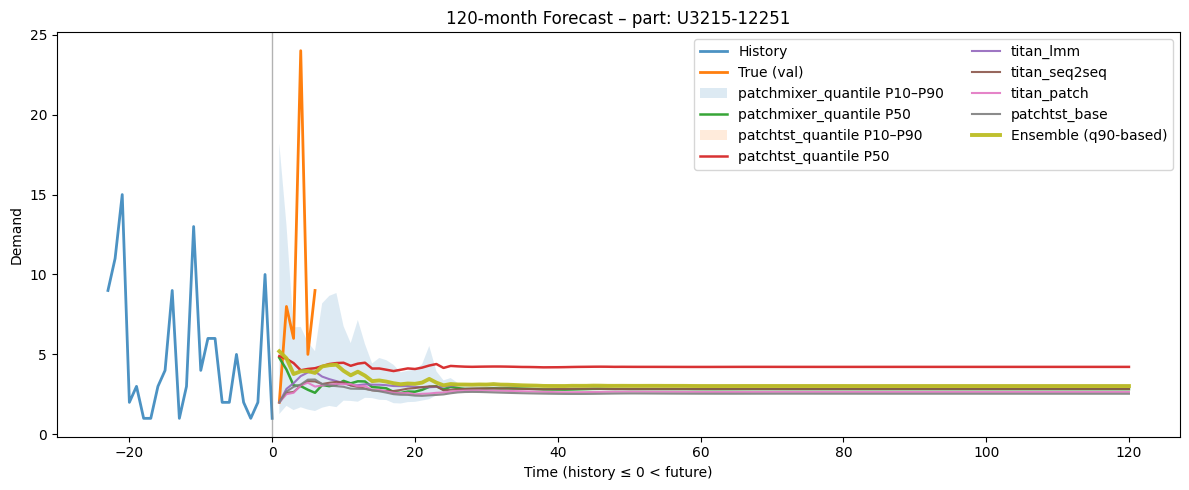

model PatchMixer QuantileModel [DBG] t 0 q10: 5.065306186676025 q50: 8.608095169067383 q90: 16.15582847595215
model PatchMixer QuantileModel [DBG] t 1 q10: 5.770562171936035 q50: 9.454094886779785 q90: 19.44182586669922
model PatchMixer QuantileModel [DBG] t 2 q10: 4.729735851287842 q50: 8.35269832611084 q90: 18.63166618347168
model PatchMixer QuantileModel [DBG] t 3 q10: 5.625618934631348 q50: 9.613698959350586 q90: 24.028045654296875
model PatchMixer QuantileModel [DBG] t 4 q10: 5.041520595550537 q50: 8.578433990478516 q90: 19.61917495727539
model PatchTST QuantileModel [DBG] t 0 q10: 12.000043869018555 q50: 12.134124755859375 q90: 12.284302711486816
model PatchTST QuantileModel [DBG] t 1 q10: 12.255233764648438 q50: 12.38723373413086 q90: 12.536452293395996
model PatchTST QuantileModel [DBG] t 2 q10: 12.23040771484375 q50: 12.362859725952148 q90: 12.511842727661133
model PatchTST QuantileModel [DBG] t 3 q10: 12.662205696105957 q50: 12.791326522827148 q90: 12.935367584228516
model Pa

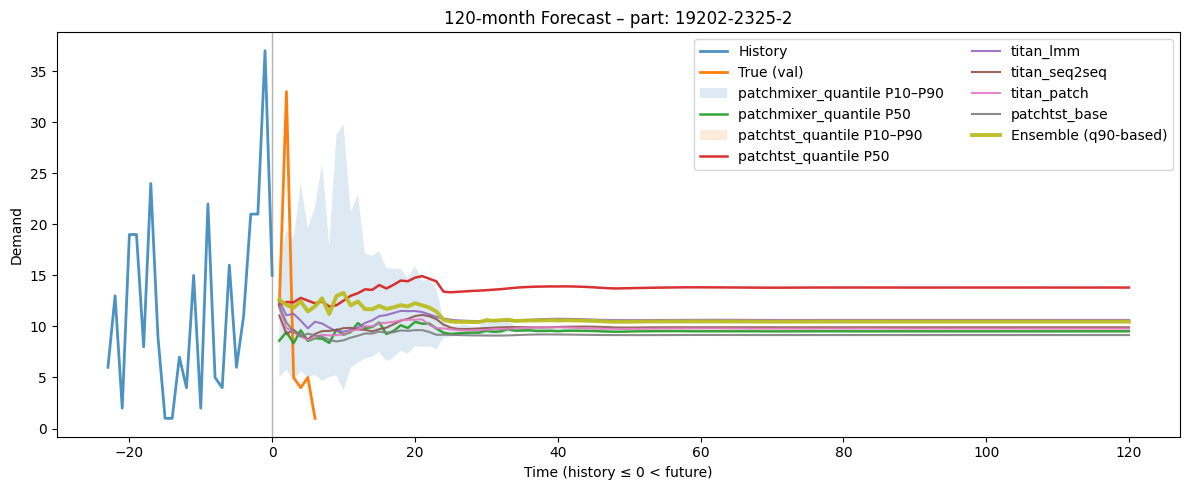

model PatchMixer QuantileModel [DBG] t 0 q10: 9.983268737792969 q50: 15.42895221710205 q90: 38.85945510864258
model PatchMixer QuantileModel [DBG] t 1 q10: 10.361440658569336 q50: 20.077041625976562 q90: 55.13047790527344
model PatchMixer QuantileModel [DBG] t 2 q10: 10.284674644470215 q50: 14.977521896362305 q90: 26.506168365478516
model PatchMixer QuantileModel [DBG] t 3 q10: 10.044111251831055 q50: 14.467605590820312 q90: 26.844223022460938
model PatchMixer QuantileModel [DBG] t 4 q10: 9.500904083251953 q50: 13.52043628692627 q90: 22.671173095703125
model PatchTST QuantileModel [DBG] t 0 q10: 19.29193115234375 q50: 19.461854934692383 q90: 19.652719497680664
model PatchTST QuantileModel [DBG] t 1 q10: 19.102928161621094 q50: 19.27251434326172 q90: 19.462501525878906
model PatchTST QuantileModel [DBG] t 2 q10: 18.822656631469727 q50: 18.9908390045166 q90: 19.1794490814209
model PatchTST QuantileModel [DBG] t 3 q10: 17.779678344726562 q50: 17.927143096923828 q90: 18.094717025756836
mod

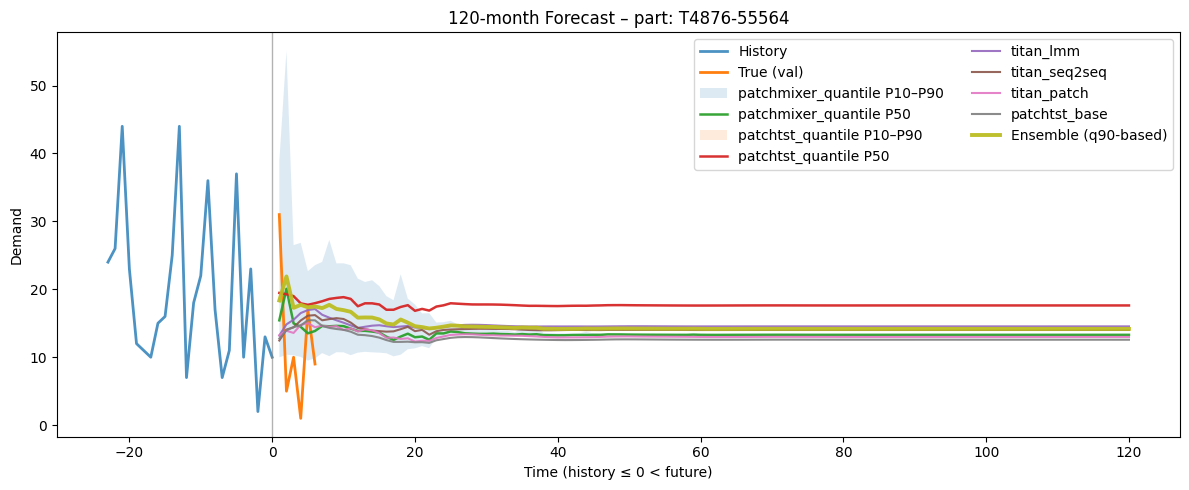

model PatchMixer QuantileModel [DBG] t 0 q10: 1.2802739143371582 q50: 3.545428991317749 q90: 9.97683334350586
model PatchMixer QuantileModel [DBG] t 1 q10: 0.24626398086547852 q50: 2.2797815799713135 q90: 7.955031394958496
model PatchMixer QuantileModel [DBG] t 2 q10: 0.058542728424072266 q50: 2.0934104919433594 q90: 8.480392456054688
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9674859046936035 q50: 3.189453125 q90: 10.077024459838867
model PatchMixer QuantileModel [DBG] t 4 q10: 1.157850980758667 q50: 3.1576714515686035 q90: 7.993891716003418
model PatchTST QuantileModel [DBG] t 0 q10: 4.74974250793457 q50: 4.826815605163574 q90: 4.91373872756958
model PatchTST QuantileModel [DBG] t 1 q10: 4.575433254241943 q50: 4.650469779968262 q90: 4.736870288848877
model PatchTST QuantileModel [DBG] t 2 q10: 4.686729907989502 q50: 4.762418270111084 q90: 4.847609996795654
model PatchTST QuantileModel [DBG] t 3 q10: 4.8435516357421875 q50: 4.918444633483887 q90: 5.002420902252197
model PatchTST 

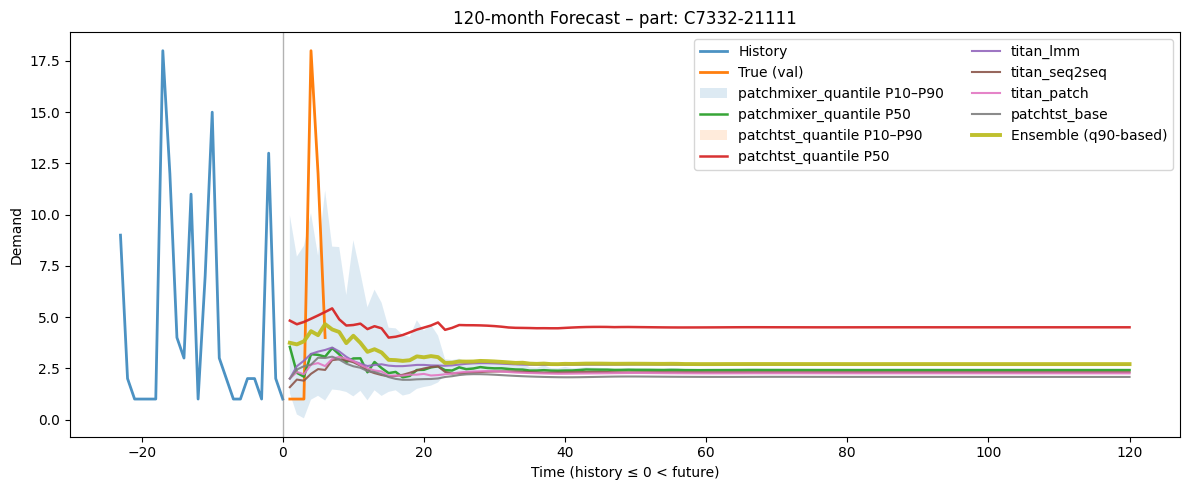

model PatchMixer QuantileModel [DBG] t 0 q10: 3.325028896331787 q50: 6.598945617675781 q90: 15.170997619628906
model PatchMixer QuantileModel [DBG] t 1 q10: 3.5261592864990234 q50: 7.119046211242676 q90: 18.215787887573242
model PatchMixer QuantileModel [DBG] t 2 q10: 3.322050094604492 q50: 6.263948440551758 q90: 15.622387886047363
model PatchMixer QuantileModel [DBG] t 3 q10: 4.00307559967041 q50: 7.10146951675415 q90: 13.867206573486328
model PatchMixer QuantileModel [DBG] t 4 q10: 2.834688186645508 q50: 7.486266136169434 q90: 26.907245635986328
model PatchTST QuantileModel [DBG] t 0 q10: 9.750199317932129 q50: 9.868205070495605 q90: 10.000259399414062
model PatchTST QuantileModel [DBG] t 1 q10: 9.744696617126465 q50: 9.862449645996094 q90: 9.994675636291504
model PatchTST QuantileModel [DBG] t 2 q10: 9.572490692138672 q50: 9.689741134643555 q90: 9.8211088180542
model PatchTST QuantileModel [DBG] t 3 q10: 9.850975036621094 q50: 9.96613597869873 q90: 10.095524787902832
model PatchTST 

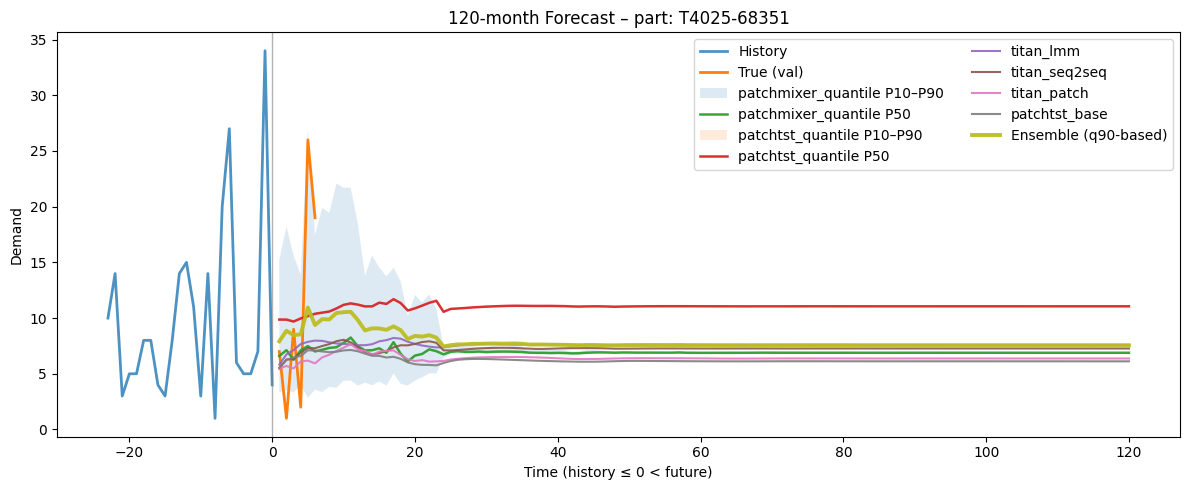

model PatchMixer QuantileModel [DBG] t 0 q10: -12.301071166992188 q50: 130.06622314453125 q90: 618.9658813476562
model PatchMixer QuantileModel [DBG] t 1 q10: -44.185638427734375 q50: 99.14137268066406 q90: 431.97869873046875
model PatchMixer QuantileModel [DBG] t 2 q10: 43.49403381347656 q50: 182.88632202148438 q90: 657.9853515625
model PatchMixer QuantileModel [DBG] t 3 q10: -56.17112731933594 q50: 71.70298767089844 q90: 385.932861328125
model PatchMixer QuantileModel [DBG] t 4 q10: -50.06898498535156 q50: 70.36384582519531 q90: 320.455810546875
model PatchTST QuantileModel [DBG] t 0 q10: 222.70367431640625 q50: 227.96450805664062 q90: 233.91136169433594
model PatchTST QuantileModel [DBG] t 1 q10: 232.1291046142578 q50: 237.3671112060547 q90: 243.24661254882812
model PatchTST QuantileModel [DBG] t 2 q10: 240.68191528320312 q50: 245.883056640625 q90: 251.7122802734375
model PatchTST QuantileModel [DBG] t 3 q10: 212.23211669921875 q50: 216.9741973876953 q90: 222.27685546875
model Patch

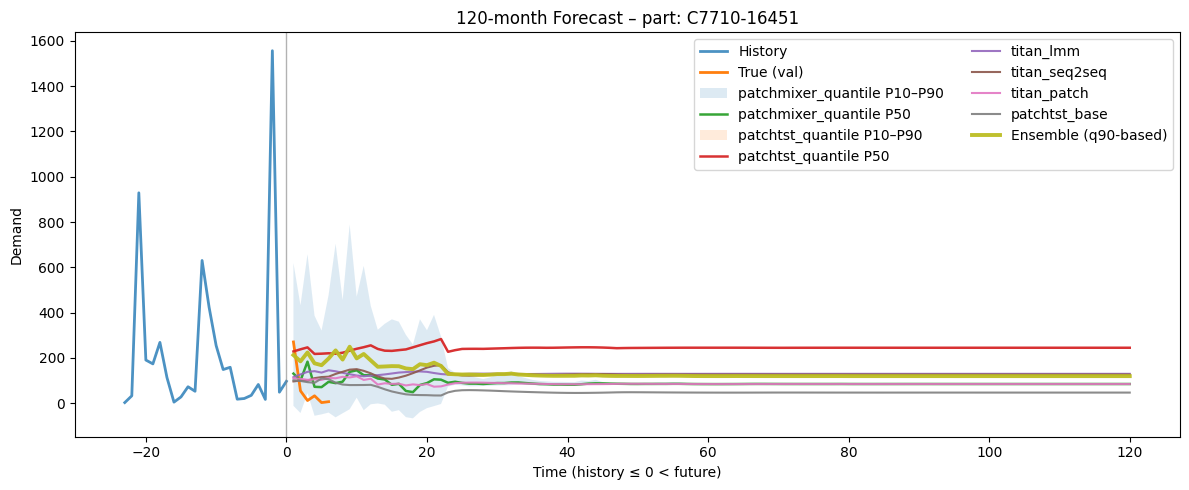

model PatchMixer QuantileModel [DBG] t 0 q10: 0.9356555938720703 q50: 2.024923324584961 q90: 5.453141212463379
model PatchMixer QuantileModel [DBG] t 1 q10: 1.1237058639526367 q50: 2.0858073234558105 q90: 4.435525894165039
model PatchMixer QuantileModel [DBG] t 2 q10: 1.0276514291763306 q50: 2.2712321281433105 q90: 6.6124372482299805
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9671961069107056 q50: 2.2162668704986572 q90: 7.861603260040283
model PatchMixer QuantileModel [DBG] t 4 q10: 1.2354893684387207 q50: 2.2577381134033203 q90: 5.139110565185547
model PatchTST QuantileModel [DBG] t 0 q10: 2.7917728424072266 q50: 2.8273420333862305 q90: 2.867249011993408
model PatchTST QuantileModel [DBG] t 1 q10: 2.7845230102539062 q50: 2.8201093673706055 q90: 2.8598928451538086
model PatchTST QuantileModel [DBG] t 2 q10: 2.8184401988983154 q50: 2.8536176681518555 q90: 2.8935654163360596
model PatchTST QuantileModel [DBG] t 3 q10: 2.7709319591522217 q50: 2.80621075630188 q90: 2.845682144165039


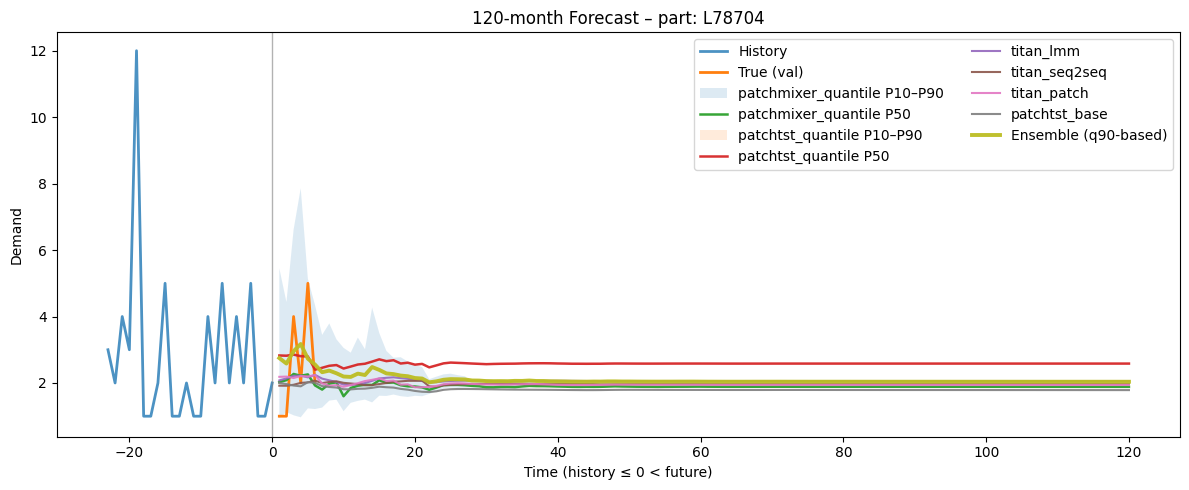

model PatchMixer QuantileModel [DBG] t 0 q10: 1.429449439048767 q50: 1.862672209739685 q90: 3.1138813495635986
model PatchMixer QuantileModel [DBG] t 1 q10: 1.299436092376709 q50: 1.965240716934204 q90: 4.744808197021484
model PatchMixer QuantileModel [DBG] t 2 q10: 1.4278689622879028 q50: 2.1607275009155273 q90: 5.049036979675293
model PatchMixer QuantileModel [DBG] t 3 q10: 1.498075008392334 q50: 1.9241111278533936 q90: 3.41787052154541
model PatchMixer QuantileModel [DBG] t 4 q10: 1.5346767902374268 q50: 2.013976812362671 q90: 3.383157730102539
model PatchTST QuantileModel [DBG] t 0 q10: 2.250065326690674 q50: 2.267059803009033 q90: 2.2860233783721924
model PatchTST QuantileModel [DBG] t 1 q10: 2.2194840908050537 q50: 2.2362797260284424 q90: 2.255101442337036
model PatchTST QuantileModel [DBG] t 2 q10: 2.229360580444336 q50: 2.2461202144622803 q90: 2.26495099067688
model PatchTST QuantileModel [DBG] t 3 q10: 2.281231641769409 q50: 2.2974984645843506 q90: 2.3158600330352783
model Pat

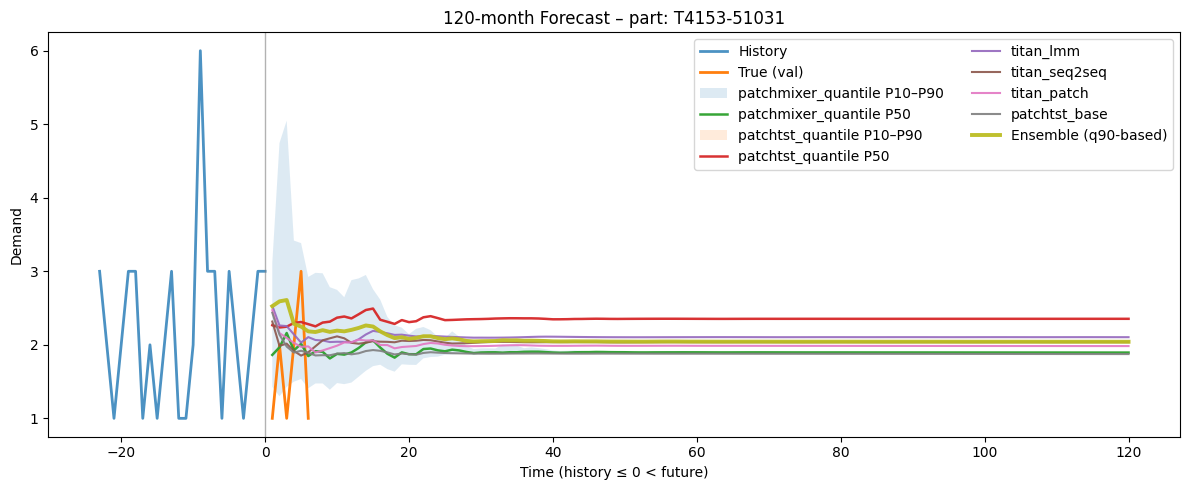

model PatchMixer QuantileModel [DBG] t 0 q10: -0.011554956436157227 q50: 1.5863008499145508 q90: 5.422147750854492
model PatchMixer QuantileModel [DBG] t 1 q10: 0.0438690185546875 q50: 1.505399465560913 q90: 4.7255401611328125
model PatchMixer QuantileModel [DBG] t 2 q10: 0.2238929271697998 q50: 1.6365702152252197 q90: 4.045299530029297
model PatchMixer QuantileModel [DBG] t 3 q10: -0.25515007972717285 q50: 1.29702627658844 q90: 5.116443634033203
model PatchMixer QuantileModel [DBG] t 4 q10: -0.10436630249023438 q50: 1.4806535243988037 q90: 5.321219444274902
model PatchTST QuantileModel [DBG] t 0 q10: 2.5001678466796875 q50: 2.559030055999756 q90: 2.624823570251465
model PatchTST QuantileModel [DBG] t 1 q10: 2.3983206748962402 q50: 2.456448793411255 q90: 2.521756887435913
model PatchTST QuantileModel [DBG] t 2 q10: 2.4587762355804443 q50: 2.5164191722869873 q90: 2.5819547176361084
model PatchTST QuantileModel [DBG] t 3 q10: 2.5221879482269287 q50: 2.579810380935669 q90: 2.6449494361877

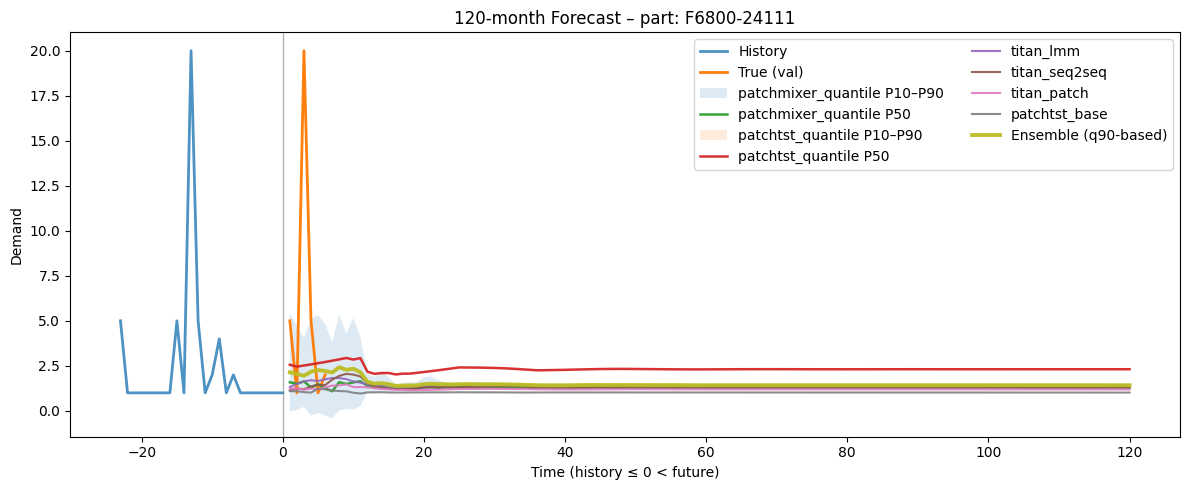

model PatchMixer QuantileModel [DBG] t 0 q10: 2.035285472869873 q50: 4.187322616577148 q90: 9.893189430236816
model PatchMixer QuantileModel [DBG] t 1 q10: 2.589463710784912 q50: 4.866796970367432 q90: 10.91079330444336
model PatchMixer QuantileModel [DBG] t 2 q10: 2.92288875579834 q50: 5.189097881317139 q90: 11.254459381103516
model PatchMixer QuantileModel [DBG] t 3 q10: 2.7258763313293457 q50: 4.891382694244385 q90: 13.57786750793457
model PatchMixer QuantileModel [DBG] t 4 q10: 2.781153678894043 q50: 4.881260871887207 q90: 9.657169342041016
model PatchTST QuantileModel [DBG] t 0 q10: 6.833439350128174 q50: 6.915948390960693 q90: 7.008540153503418
model PatchTST QuantileModel [DBG] t 1 q10: 7.038410186767578 q50: 7.119650363922119 q90: 7.210563659667969
model PatchTST QuantileModel [DBG] t 2 q10: 7.2933573722839355 q50: 7.372358322143555 q90: 7.460720062255859
model PatchTST QuantileModel [DBG] t 3 q10: 7.058920383453369 q50: 7.13596773147583 q90: 7.222024440765381
model PatchTST Qu

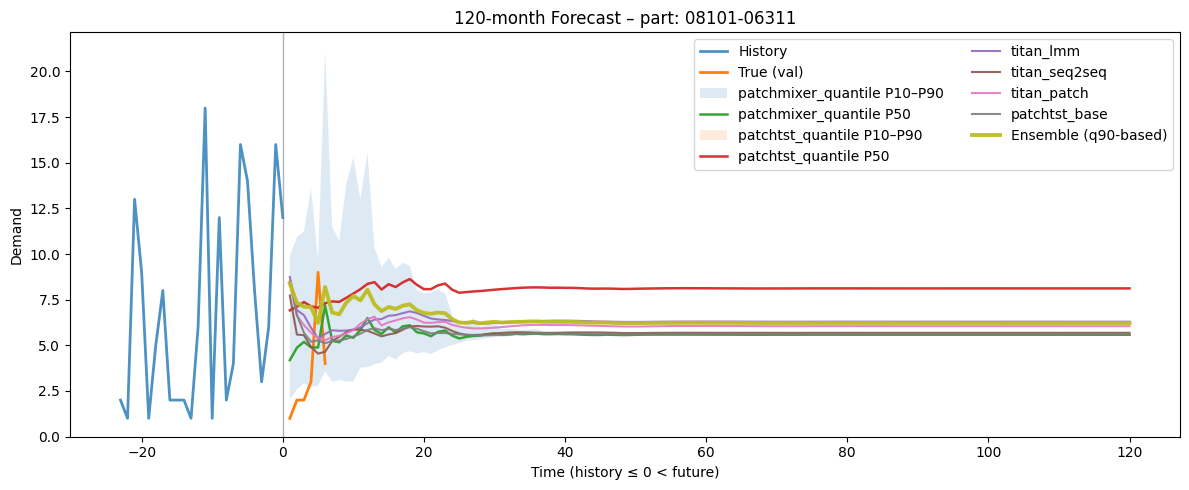

model PatchMixer QuantileModel [DBG] t 0 q10: 2.9943432807922363 q50: 5.8182573318481445 q90: 14.404417037963867
model PatchMixer QuantileModel [DBG] t 1 q10: 2.4658775329589844 q50: 5.073604106903076 q90: 13.707776069641113
model PatchMixer QuantileModel [DBG] t 2 q10: 2.8292036056518555 q50: 5.333215236663818 q90: 11.3275146484375
model PatchMixer QuantileModel [DBG] t 3 q10: 3.1523423194885254 q50: 5.620184898376465 q90: 11.545401573181152
model PatchMixer QuantileModel [DBG] t 4 q10: 2.647677421569824 q50: 5.0391716957092285 q90: 10.825719833374023
model PatchTST QuantileModel [DBG] t 0 q10: 7.874624729156494 q50: 7.972086429595947 q90: 8.082961082458496
model PatchTST QuantileModel [DBG] t 1 q10: 7.539740562438965 q50: 7.633543491363525 q90: 7.740983009338379
model PatchTST QuantileModel [DBG] t 2 q10: 7.817080497741699 q50: 7.909804344177246 q90: 8.0135498046875
model PatchTST QuantileModel [DBG] t 3 q10: 7.688295364379883 q50: 7.7802042961120605 q90: 7.8836894035339355
model Pat

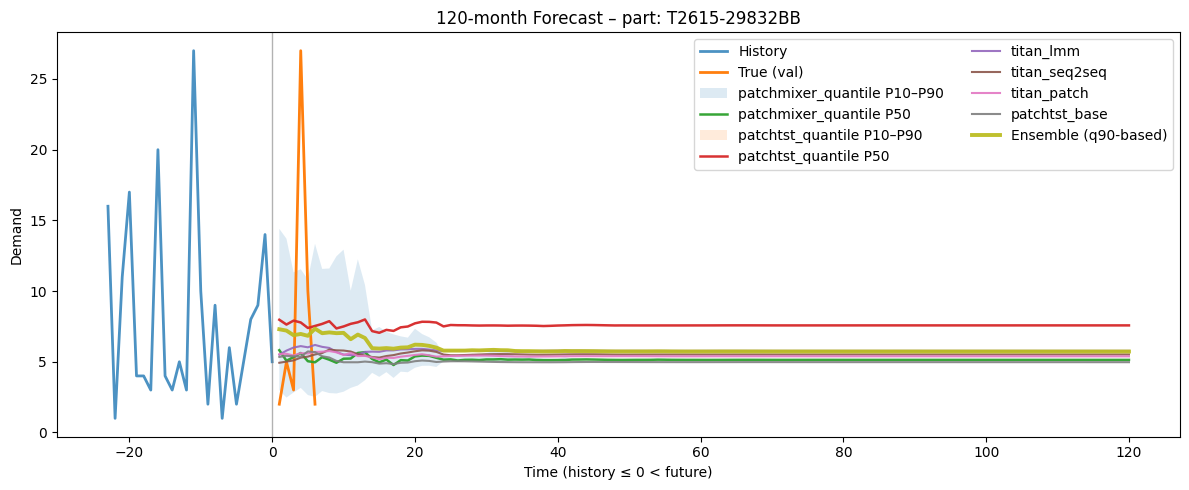

model PatchMixer QuantileModel [DBG] t 0 q10: 1.8246712684631348 q50: 5.863683700561523 q90: 19.772138595581055
model PatchMixer QuantileModel [DBG] t 1 q10: 1.2366042137145996 q50: 5.277976036071777 q90: 18.214221954345703
model PatchMixer QuantileModel [DBG] t 2 q10: 1.5127763748168945 q50: 5.5958967208862305 q90: 18.820600509643555
model PatchMixer QuantileModel [DBG] t 3 q10: 1.8992233276367188 q50: 5.3490118980407715 q90: 13.608381271362305
model PatchMixer QuantileModel [DBG] t 4 q10: 2.0283803939819336 q50: 5.413703918457031 q90: 13.340794563293457
model PatchTST QuantileModel [DBG] t 0 q10: 7.541945457458496 q50: 7.670679569244385 q90: 7.815557479858398
model PatchTST QuantileModel [DBG] t 1 q10: 7.569363117218018 q50: 7.697408199310303 q90: 7.842867374420166
model PatchTST QuantileModel [DBG] t 2 q10: 7.80638313293457 q50: 7.933233737945557 q90: 8.077412605285645
model PatchTST QuantileModel [DBG] t 3 q10: 7.846301555633545 q50: 7.9745192527771 q90: 8.117486000061035
model Pat

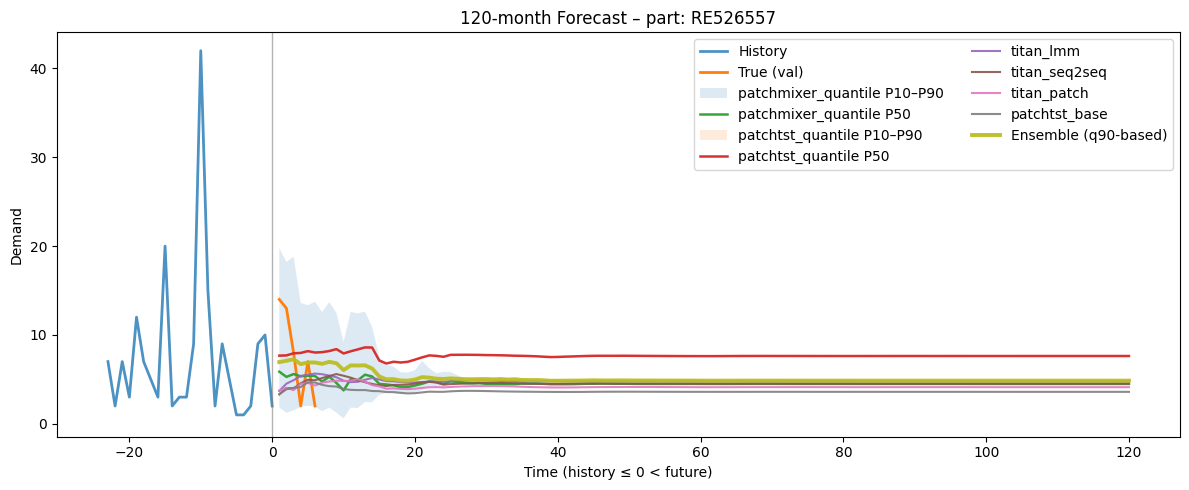

model PatchMixer QuantileModel [DBG] t 0 q10: 1.2259807586669922 q50: 2.9154415130615234 q90: 8.439584732055664
model PatchMixer QuantileModel [DBG] t 1 q10: 1.3481557369232178 q50: 2.7687020301818848 q90: 8.535584449768066
model PatchMixer QuantileModel [DBG] t 2 q10: 1.45731520652771 q50: 3.190420150756836 q90: 10.415410995483398
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9792914390563965 q50: 3.4874861240386963 q90: 12.856964111328125
model PatchMixer QuantileModel [DBG] t 4 q10: 2.855090618133545 q50: 4.943138122558594 q90: 13.491068840026855
model PatchTST QuantileModel [DBG] t 0 q10: 4.125109672546387 q50: 4.178855895996094 q90: 4.239502906799316
model PatchTST QuantileModel [DBG] t 1 q10: 4.257377624511719 q50: 4.310098171234131 q90: 4.369832515716553
model PatchTST QuantileModel [DBG] t 2 q10: 4.311842441558838 q50: 4.364620208740234 q90: 4.423976421356201
model PatchTST QuantileModel [DBG] t 3 q10: 4.2855706214904785 q50: 4.3382887840271 q90: 4.3976054191589355
model Patc

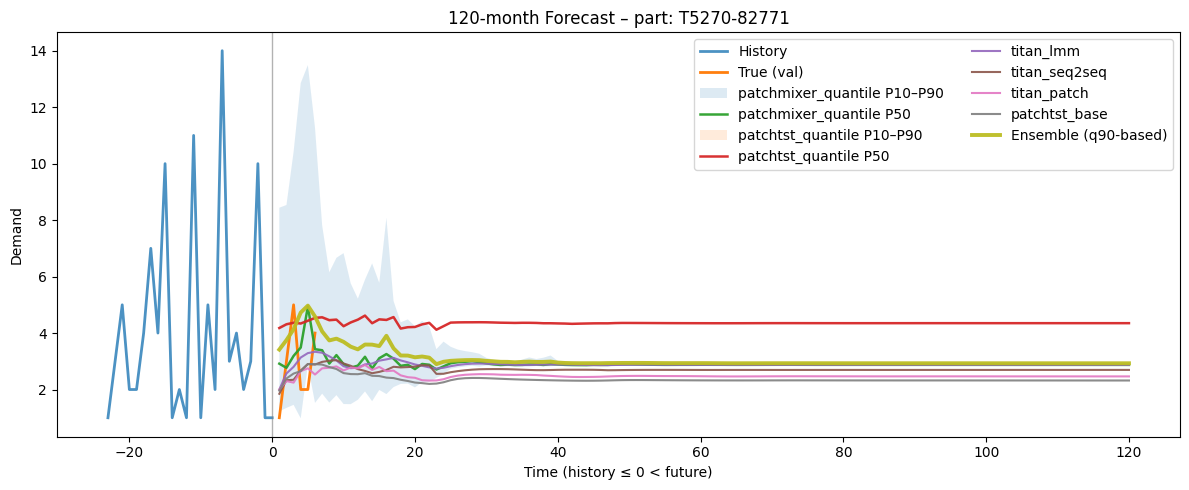

model PatchMixer QuantileModel [DBG] t 0 q10: -0.1716766357421875 q50: 11.312032699584961 q90: 39.50006103515625
model PatchMixer QuantileModel [DBG] t 1 q10: -1.8312034606933594 q50: 9.118550300598145 q90: 41.06847381591797
model PatchMixer QuantileModel [DBG] t 2 q10: -1.0050315856933594 q50: 11.381549835205078 q90: 51.79759216308594
model PatchMixer QuantileModel [DBG] t 3 q10: -0.18577194213867188 q50: 11.852641105651855 q90: 57.01123809814453
model PatchMixer QuantileModel [DBG] t 4 q10: -0.9420814514160156 q50: 17.155155181884766 q90: 89.37867736816406
model PatchTST QuantileModel [DBG] t 0 q10: 23.37535285949707 q50: 23.797250747680664 q90: 24.269968032836914
model PatchTST QuantileModel [DBG] t 1 q10: 22.575223922729492 q50: 22.993513107299805 q90: 23.461029052734375
model PatchTST QuantileModel [DBG] t 2 q10: 20.949066162109375 q50: 21.34549903869629 q90: 21.79444694519043
model PatchTST QuantileModel [DBG] t 3 q10: 21.799020767211914 q50: 22.193696975708008 q90: 22.6353721618

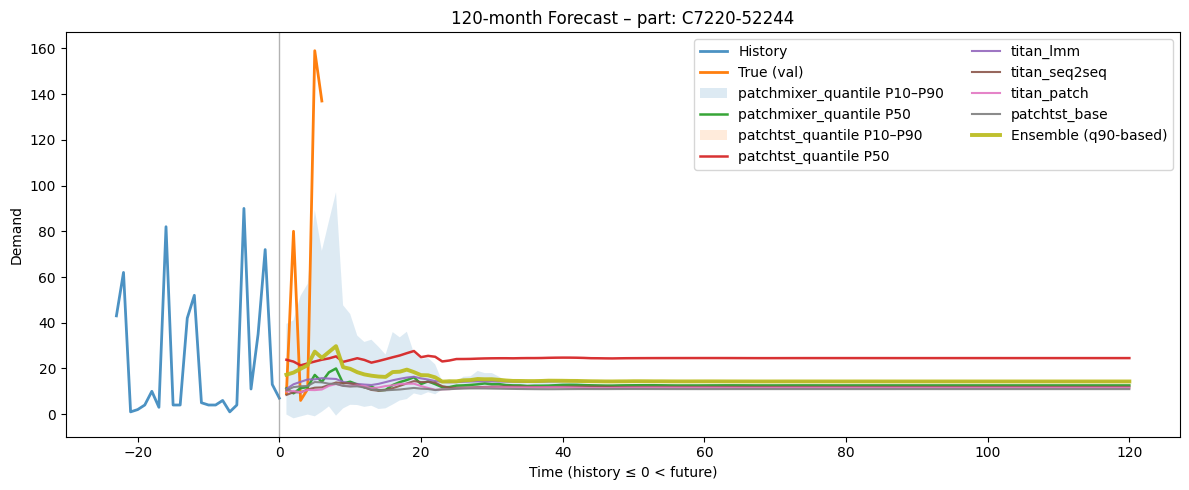

model PatchMixer QuantileModel [DBG] t 0 q10: 5.163642883300781 q50: 14.032730102539062 q90: 50.18547821044922
model PatchMixer QuantileModel [DBG] t 1 q10: 5.381580352783203 q50: 13.720550537109375 q90: 51.1544189453125
model PatchMixer QuantileModel [DBG] t 2 q10: 3.586240768432617 q50: 15.277957916259766 q90: 64.32108306884766
model PatchMixer QuantileModel [DBG] t 3 q10: 6.543698310852051 q50: 17.16249656677246 q90: 59.32804870605469
model PatchMixer QuantileModel [DBG] t 4 q10: 5.933139801025391 q50: 16.15961456298828 q90: 54.61170959472656
model PatchTST QuantileModel [DBG] t 0 q10: 21.958864212036133 q50: 22.25827980041504 q90: 22.59569549560547
model PatchTST QuantileModel [DBG] t 1 q10: 20.302825927734375 q50: 20.575925827026367 q90: 20.88202667236328
model PatchTST QuantileModel [DBG] t 2 q10: 20.57671356201172 q50: 20.84811782836914 q90: 21.153732299804688
model PatchTST QuantileModel [DBG] t 3 q10: 21.278676986694336 q50: 21.544967651367188 q90: 21.84551239013672
model Patc

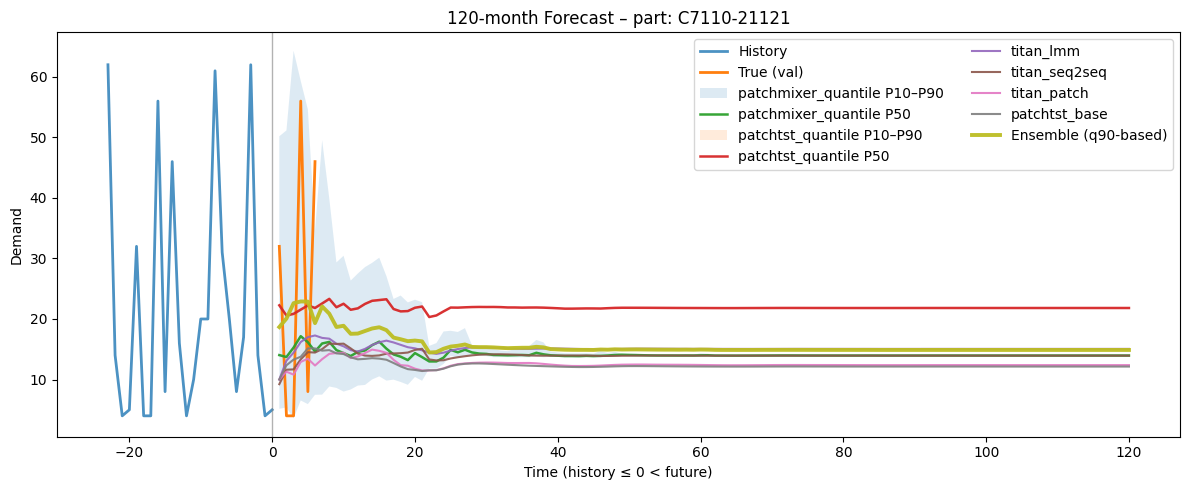

model PatchMixer QuantileModel [DBG] t 0 q10: 2.2320003509521484 q50: 14.551050186157227 q90: 61.464111328125
model PatchMixer QuantileModel [DBG] t 1 q10: 27.54304313659668 q50: 49.023216247558594 q90: 84.45681762695312
model PatchMixer QuantileModel [DBG] t 2 q10: 6.825727462768555 q50: 15.946473121643066 q90: 52.835304260253906
model PatchMixer QuantileModel [DBG] t 3 q10: 7.326319694519043 q50: 16.959592819213867 q90: 50.05465316772461
model PatchMixer QuantileModel [DBG] t 4 q10: 6.229519844055176 q50: 13.504523277282715 q90: 40.7407341003418
model PatchTST QuantileModel [DBG] t 0 q10: 17.87530517578125 q50: 18.130020141601562 q90: 18.417150497436523
model PatchTST QuantileModel [DBG] t 1 q10: 18.215065002441406 q50: 18.470184326171875 q90: 18.754615783691406
model PatchTST QuantileModel [DBG] t 2 q10: 18.482561111450195 q50: 18.7342586517334 q90: 19.019826889038086
model PatchTST QuantileModel [DBG] t 3 q10: 17.596450805664062 q50: 17.839675903320312 q90: 18.11476707458496
model 

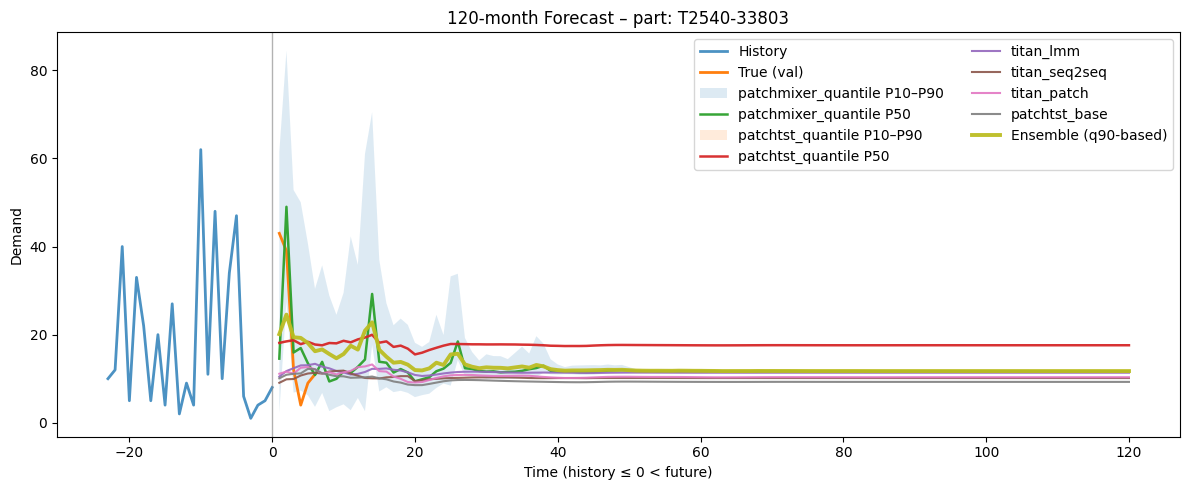

model PatchMixer QuantileModel [DBG] t 0 q10: 4.871124267578125 q50: 13.733698844909668 q90: 36.91600036621094
model PatchMixer QuantileModel [DBG] t 1 q10: 8.520469665527344 q50: 17.93472671508789 q90: 38.91429901123047
model PatchMixer QuantileModel [DBG] t 2 q10: 10.028114318847656 q50: 20.60357093811035 q90: 52.920875549316406
model PatchMixer QuantileModel [DBG] t 3 q10: 10.405045509338379 q50: 15.672521591186523 q90: 37.82350158691406
model PatchMixer QuantileModel [DBG] t 4 q10: 10.237399101257324 q50: 16.52444076538086 q90: 39.57130813598633
model PatchTST QuantileModel [DBG] t 0 q10: 25.540674209594727 q50: 25.888290405273438 q90: 26.281766891479492
model PatchTST QuantileModel [DBG] t 1 q10: 26.120450973510742 q50: 26.46657371520996 q90: 26.85573959350586
model PatchTST QuantileModel [DBG] t 2 q10: 26.598329544067383 q50: 26.943775177001953 q90: 27.329544067382812
model PatchTST QuantileModel [DBG] t 3 q10: 22.970718383789062 q50: 23.179521560668945 q90: 23.415836334228516
mo

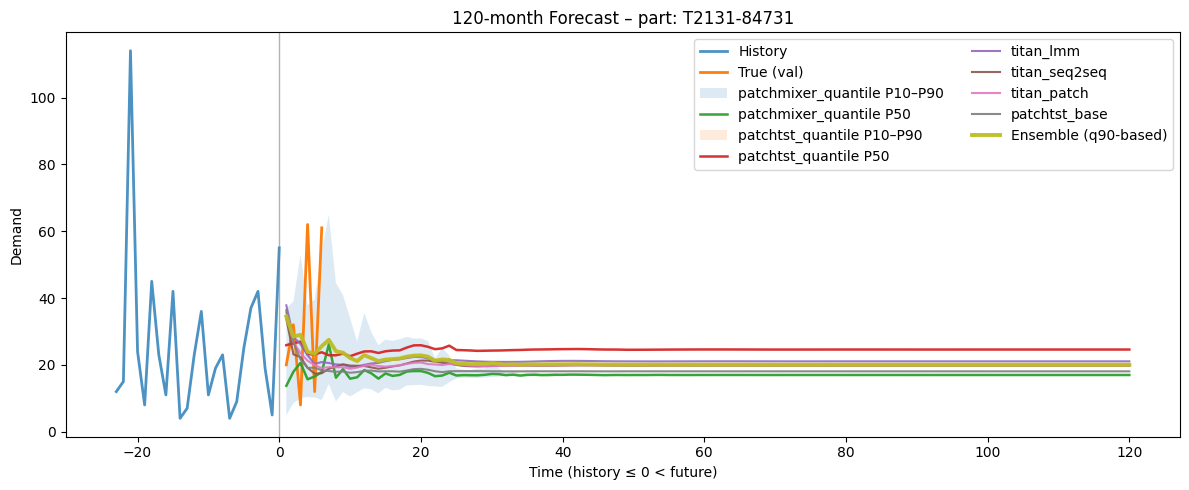

model PatchMixer QuantileModel [DBG] t 0 q10: 1.9112706184387207 q50: 4.476205825805664 q90: 11.454448699951172
model PatchMixer QuantileModel [DBG] t 1 q10: 2.91146183013916 q50: 5.521441459655762 q90: 10.84581184387207
model PatchMixer QuantileModel [DBG] t 2 q10: 2.6008806228637695 q50: 5.443184852600098 q90: 13.38992977142334
model PatchMixer QuantileModel [DBG] t 3 q10: 2.4554924964904785 q50: 5.422321319580078 q90: 18.324413299560547
model PatchMixer QuantileModel [DBG] t 4 q10: 2.723726272583008 q50: 5.893917083740234 q90: 18.961109161376953
model PatchTST QuantileModel [DBG] t 0 q10: 7.4579668045043945 q50: 7.554648399353027 q90: 7.664478778839111
model PatchTST QuantileModel [DBG] t 1 q10: 7.689769744873047 q50: 7.785045623779297 q90: 7.892834663391113
model PatchTST QuantileModel [DBG] t 2 q10: 7.805937767028809 q50: 7.901118278503418 q90: 8.008514404296875
model PatchTST QuantileModel [DBG] t 3 q10: 7.843300819396973 q50: 7.938462257385254 q90: 8.045479774475098
model PatchT

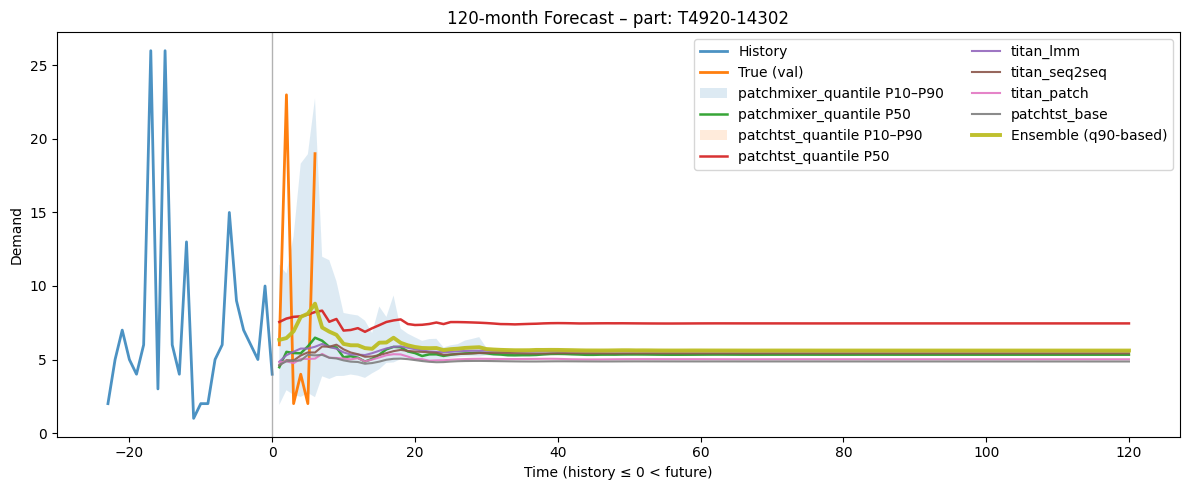

model PatchMixer QuantileModel [DBG] t 0 q10: 6.795368194580078 q50: 11.736331939697266 q90: 23.920635223388672
model PatchMixer QuantileModel [DBG] t 1 q10: 6.331680774688721 q50: 10.095056533813477 q90: 22.727188110351562
model PatchMixer QuantileModel [DBG] t 2 q10: 6.341220855712891 q50: 9.49921989440918 q90: 23.21853256225586
model PatchMixer QuantileModel [DBG] t 3 q10: 6.734223365783691 q50: 10.716351509094238 q90: 26.13406753540039
model PatchMixer QuantileModel [DBG] t 4 q10: 6.374662399291992 q50: 9.407116889953613 q90: 21.7071533203125
model PatchTST QuantileModel [DBG] t 0 q10: 14.416764259338379 q50: 14.599020004272461 q90: 14.803260803222656
model PatchTST QuantileModel [DBG] t 1 q10: 12.691847801208496 q50: 12.818916320800781 q90: 12.962418556213379
model PatchTST QuantileModel [DBG] t 2 q10: 11.642586708068848 q50: 11.742791175842285 q90: 11.854632377624512
model PatchTST QuantileModel [DBG] t 3 q10: 11.88084602355957 q50: 11.978281021118164 q90: 12.089204788208008
mode

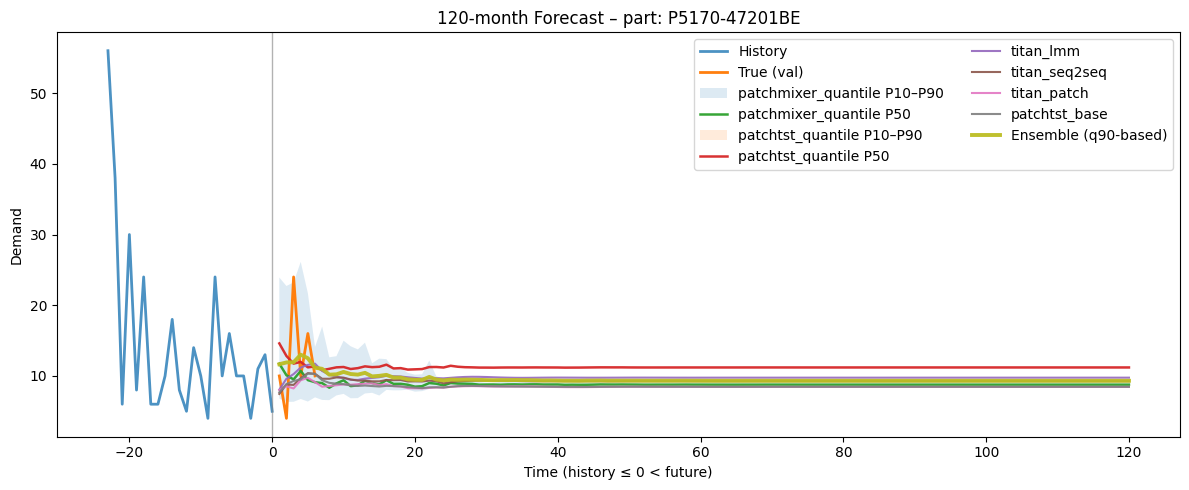

model PatchMixer QuantileModel [DBG] t 0 q10: 1.0948580503463745 q50: 1.7081607580184937 q90: 4.166998863220215
model PatchMixer QuantileModel [DBG] t 1 q10: 1.0848639011383057 q50: 1.6573662757873535 q90: 3.996126651763916
model PatchMixer QuantileModel [DBG] t 2 q10: 1.1668281555175781 q50: 1.6675068140029907 q90: 2.8515522480010986
model PatchMixer QuantileModel [DBG] t 3 q10: 0.9256942272186279 q50: 1.4180386066436768 q90: 2.607616901397705
model PatchMixer QuantileModel [DBG] t 4 q10: 1.0848503112792969 q50: 1.5860005617141724 q90: 2.7878026962280273
model PatchTST QuantileModel [DBG] t 0 q10: 2.0000522136688232 q50: 2.01849365234375 q90: 2.039151668548584
model PatchTST QuantileModel [DBG] t 1 q10: 2.000809907913208 q50: 2.0192136764526367 q90: 2.039882183074951
model PatchTST QuantileModel [DBG] t 2 q10: 2.0015695095062256 q50: 2.0199577808380127 q90: 2.0406391620635986
model PatchTST QuantileModel [DBG] t 3 q10: 2.0023927688598633 q50: 2.0207297801971436 q90: 2.0414583683013916

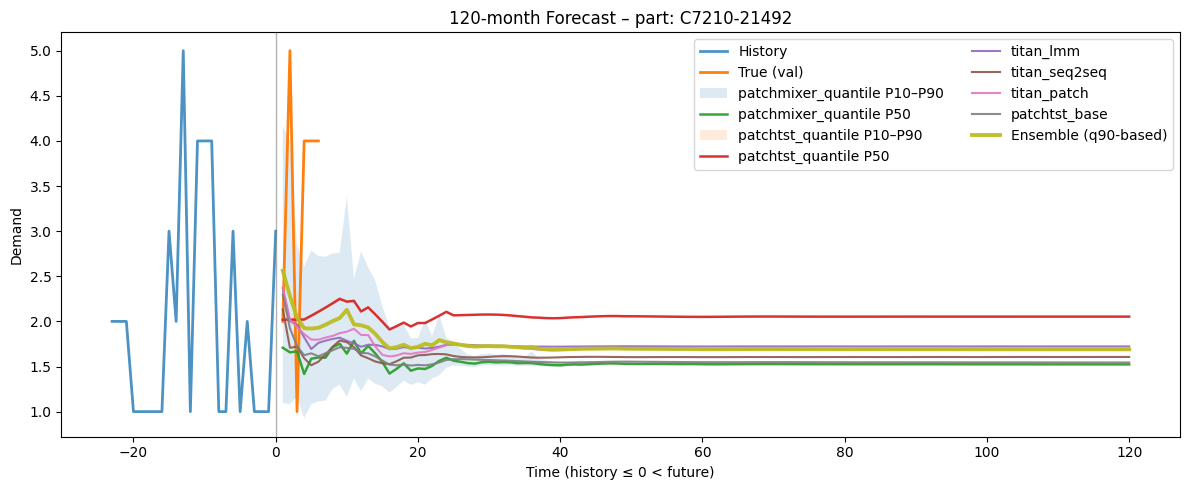

model PatchMixer QuantileModel [DBG] t 0 q10: 1.8748955726623535 q50: 3.293914794921875 q90: 7.462800025939941
model PatchMixer QuantileModel [DBG] t 1 q10: 2.076627016067505 q50: 3.391757011413574 q90: 6.5163421630859375
model PatchMixer QuantileModel [DBG] t 2 q10: 2.154271364212036 q50: 3.276599645614624 q90: 5.433097839355469
model PatchMixer QuantileModel [DBG] t 3 q10: 1.902540683746338 q50: 3.0656402111053467 q90: 5.327387809753418
model PatchMixer QuantileModel [DBG] t 4 q10: 2.2730555534362793 q50: 3.4324934482574463 q90: 6.764922618865967
model PatchTST QuantileModel [DBG] t 0 q10: 4.458375930786133 q50: 4.507160663604736 q90: 4.562128067016602
model PatchTST QuantileModel [DBG] t 1 q10: 4.604397296905518 q50: 4.652192115783691 q90: 4.70563268661499
model PatchTST QuantileModel [DBG] t 2 q10: 4.33977746963501 q50: 4.382819652557373 q90: 4.431530952453613
model PatchTST QuantileModel [DBG] t 3 q10: 4.397729396820068 q50: 4.440932750701904 q90: 4.489336967468262
model PatchTST 

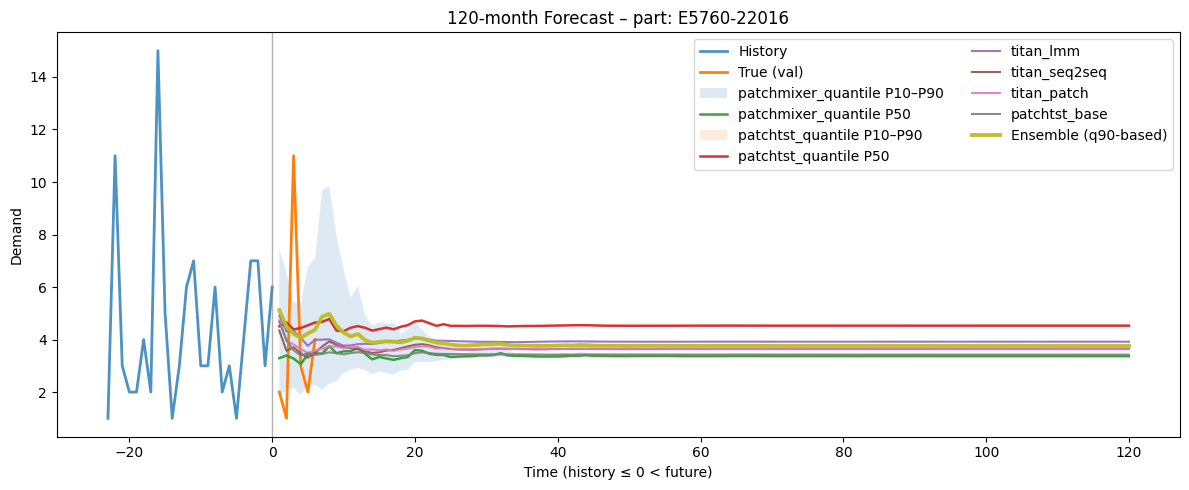

model PatchMixer QuantileModel [DBG] t 0 q10: 1.73866868019104 q50: 3.9534478187561035 q90: 11.016536712646484
model PatchMixer QuantileModel [DBG] t 1 q10: 1.968491792678833 q50: 3.7142655849456787 q90: 7.973930835723877
model PatchMixer QuantileModel [DBG] t 2 q10: 2.4358766078948975 q50: 4.198518753051758 q90: 8.378401756286621
model PatchMixer QuantileModel [DBG] t 3 q10: 1.7254326343536377 q50: 4.3268632888793945 q90: 15.905742645263672
model PatchMixer QuantileModel [DBG] t 4 q10: 1.844280481338501 q50: 3.8660125732421875 q90: 11.864733695983887
model PatchTST QuantileModel [DBG] t 0 q10: 5.208213806152344 q50: 5.27512264251709 q90: 5.350641250610352
model PatchTST QuantileModel [DBG] t 1 q10: 5.38633918762207 q50: 5.451789379119873 q90: 5.525862216949463
model PatchTST QuantileModel [DBG] t 2 q10: 5.5721755027771 q50: 5.636580467224121 q90: 5.708799362182617
model PatchTST QuantileModel [DBG] t 3 q10: 5.723590850830078 q50: 5.787013053894043 q90: 5.857996940612793
model PatchTST

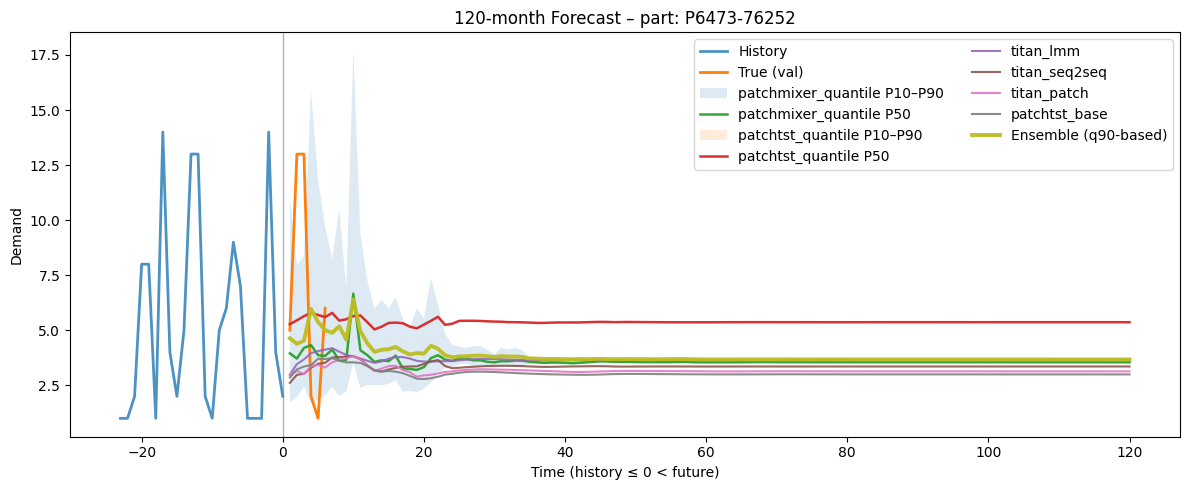

model PatchMixer QuantileModel [DBG] t 0 q10: 3.318439483642578 q50: 8.177473068237305 q90: 19.80086898803711
model PatchMixer QuantileModel [DBG] t 1 q10: 2.7050018310546875 q50: 7.585540771484375 q90: 18.60015869140625
model PatchMixer QuantileModel [DBG] t 2 q10: 3.691452980041504 q50: 9.242764472961426 q90: 29.896011352539062
model PatchMixer QuantileModel [DBG] t 3 q10: 4.267087936401367 q50: 9.049583435058594 q90: 24.012828826904297
model PatchMixer QuantileModel [DBG] t 4 q10: 3.858065605163574 q50: 9.280516624450684 q90: 31.513832092285156
model PatchTST QuantileModel [DBG] t 0 q10: 12.83387279510498 q50: 13.014350891113281 q90: 13.215847969055176
model PatchTST QuantileModel [DBG] t 1 q10: 12.542783737182617 q50: 12.72132396697998 q90: 12.92198371887207
model PatchTST QuantileModel [DBG] t 2 q10: 13.030879974365234 q50: 13.205547332763672 q90: 13.401998519897461
model PatchTST QuantileModel [DBG] t 3 q10: 13.456364631652832 q50: 13.628521919250488 q90: 13.82172966003418
model 

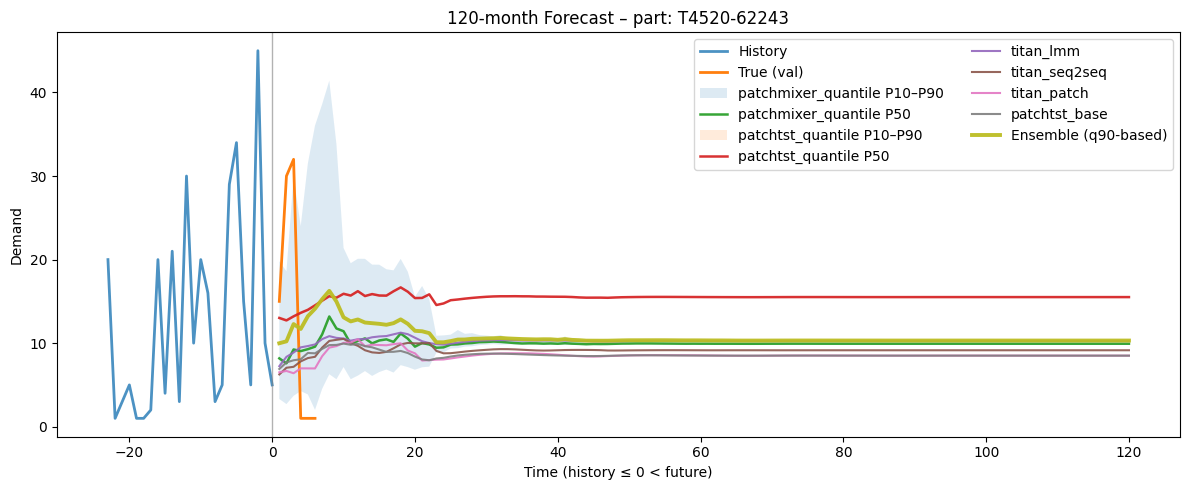

model PatchMixer QuantileModel [DBG] t 0 q10: 3.285323143005371 q50: 6.809187889099121 q90: 16.76740837097168
model PatchMixer QuantileModel [DBG] t 1 q10: 2.100369930267334 q50: 5.17353630065918 q90: 15.440404891967773
model PatchMixer QuantileModel [DBG] t 2 q10: 2.320005416870117 q50: 5.620585918426514 q90: 14.228178977966309
model PatchMixer QuantileModel [DBG] t 3 q10: 2.861812114715576 q50: 6.611537456512451 q90: 18.129047393798828
model PatchMixer QuantileModel [DBG] t 4 q10: 2.673750400543213 q50: 5.707598686218262 q90: 13.47500991821289
model PatchTST QuantileModel [DBG] t 0 q10: 8.958525657653809 q50: 9.078149795532227 q90: 9.212152481079102
model PatchTST QuantileModel [DBG] t 1 q10: 8.876683235168457 q50: 8.9942045211792 q90: 9.129903793334961
model PatchTST QuantileModel [DBG] t 2 q10: 8.87796401977539 q50: 8.996954917907715 q90: 9.131118774414062
model PatchTST QuantileModel [DBG] t 3 q10: 9.211331367492676 q50: 9.327730178833008 q90: 9.459156036376953
model PatchTST Quan

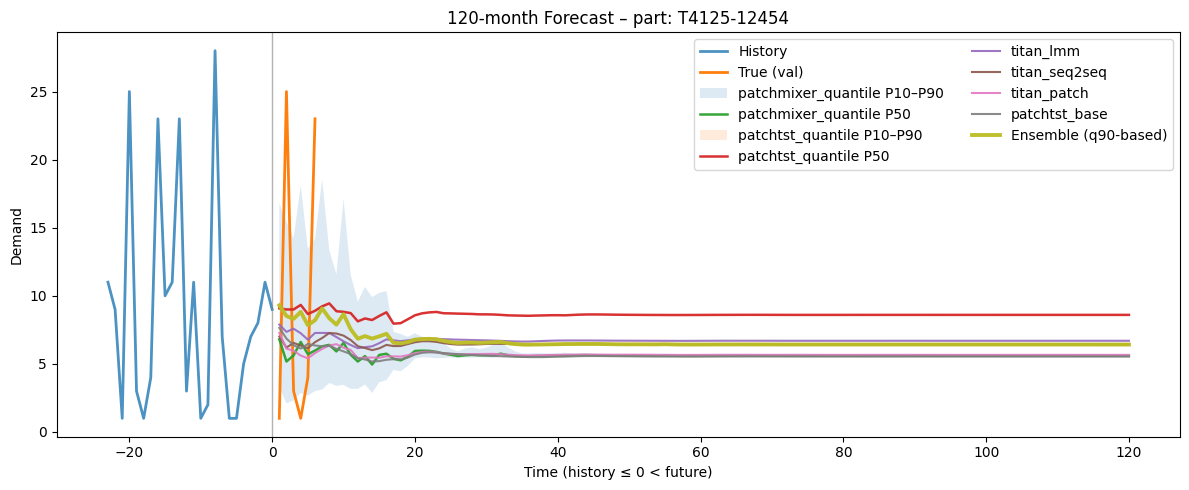

model PatchMixer QuantileModel [DBG] t 0 q10: 1.727329969406128 q50: 3.3785104751586914 q90: 8.317306518554688
model PatchMixer QuantileModel [DBG] t 1 q10: 2.175585985183716 q50: 3.736577033996582 q90: 7.07774543762207
model PatchMixer QuantileModel [DBG] t 2 q10: 1.8228082656860352 q50: 3.7107620239257812 q90: 9.581645965576172
model PatchMixer QuantileModel [DBG] t 3 q10: 1.6740870475769043 q50: 3.563429355621338 q90: 11.779842376708984
model PatchMixer QuantileModel [DBG] t 4 q10: 2.595831871032715 q50: 4.355195999145508 q90: 9.84016227722168
model PatchTST QuantileModel [DBG] t 0 q10: 5.0418701171875 q50: 5.102552890777588 q90: 5.170602798461914
model PatchTST QuantileModel [DBG] t 1 q10: 5.08767557144165 q50: 5.148213863372803 q90: 5.2162017822265625
model PatchTST QuantileModel [DBG] t 2 q10: 5.051698207855225 q50: 5.1118550300598145 q90: 5.180087566375732
model PatchTST QuantileModel [DBG] t 3 q10: 5.056702136993408 q50: 5.116976261138916 q90: 5.18506383895874
model PatchTST Qu

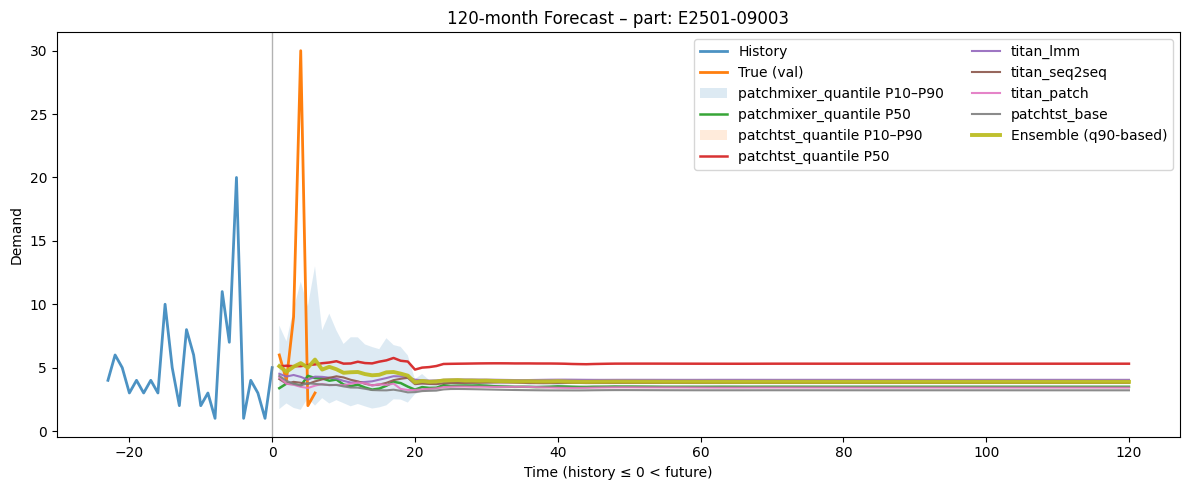

model PatchMixer QuantileModel [DBG] t 0 q10: -0.06478118896484375 q50: 12.031377792358398 q90: 54.37948989868164
model PatchMixer QuantileModel [DBG] t 1 q10: 2.7305850982666016 q50: 13.700826644897461 q90: 40.19281005859375
model PatchMixer QuantileModel [DBG] t 2 q10: 1.88922119140625 q50: 13.627456665039062 q90: 41.457611083984375
model PatchMixer QuantileModel [DBG] t 3 q10: 6.063525199890137 q50: 16.49732780456543 q90: 31.03252410888672
model PatchMixer QuantileModel [DBG] t 4 q10: 4.651580810546875 q50: 12.906631469726562 q90: 35.63053512573242
model PatchTST QuantileModel [DBG] t 0 q10: 20.625106811523438 q50: 21.0552978515625 q90: 21.539684295654297
model PatchTST QuantileModel [DBG] t 1 q10: 21.25340461730957 q50: 21.682815551757812 q90: 22.164596557617188
model PatchTST QuantileModel [DBG] t 2 q10: 21.405481338500977 q50: 21.83363151550293 q90: 22.314170837402344
model PatchTST QuantileModel [DBG] t 3 q10: 22.10601806640625 q50: 22.528059005737305 q90: 23.007633209228516
mod

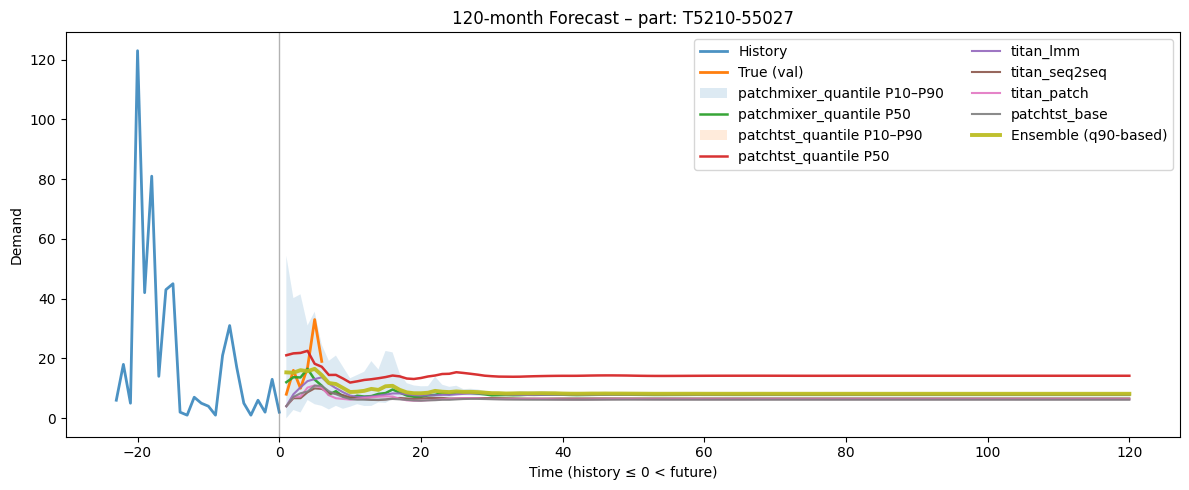

model PatchMixer QuantileModel [DBG] t 0 q10: 2.2476794719696045 q50: 3.768724203109741 q90: 7.967535018920898
model PatchMixer QuantileModel [DBG] t 1 q10: 2.1193182468414307 q50: 3.6598012447357178 q90: 8.409329414367676
model PatchMixer QuantileModel [DBG] t 2 q10: 2.330772876739502 q50: 3.9444963932037354 q90: 10.138065338134766
model PatchMixer QuantileModel [DBG] t 3 q10: 2.40340256690979 q50: 3.842893600463867 q90: 7.798874378204346
model PatchMixer QuantileModel [DBG] t 4 q10: 2.132223129272461 q50: 3.825040817260742 q90: 9.434364318847656
model PatchTST QuantileModel [DBG] t 0 q10: 5.499947547912598 q50: 5.555973529815674 q90: 5.6192779541015625
model PatchTST QuantileModel [DBG] t 1 q10: 5.356484889984131 q50: 5.411423683166504 q90: 5.473519802093506
model PatchTST QuantileModel [DBG] t 2 q10: 5.498501300811768 q50: 5.552498817443848 q90: 5.613339424133301
model PatchTST QuantileModel [DBG] t 3 q10: 5.354853630065918 q50: 5.4076433181762695 q90: 5.467282295227051
model PatchT

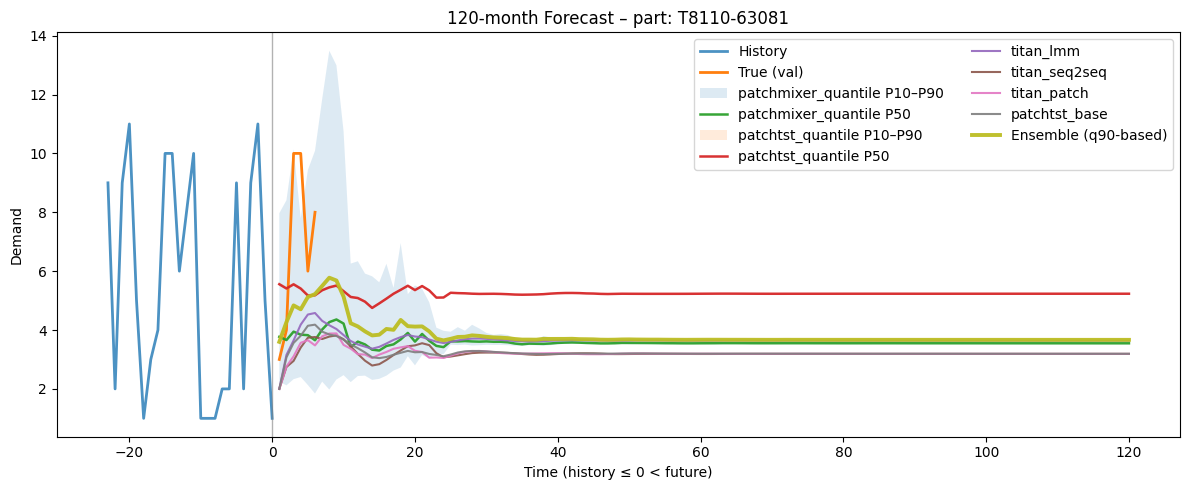

model PatchMixer QuantileModel [DBG] t 0 q10: 1.2857160568237305 q50: 6.470174789428711 q90: 19.794178009033203
model PatchMixer QuantileModel [DBG] t 1 q10: 0.8723545074462891 q50: 5.953481197357178 q90: 18.275650024414062
model PatchMixer QuantileModel [DBG] t 2 q10: 1.4155235290527344 q50: 6.457139492034912 q90: 18.724857330322266
model PatchMixer QuantileModel [DBG] t 3 q10: 0.0483856201171875 q50: 4.9071526527404785 q90: 15.391143798828125
model PatchMixer QuantileModel [DBG] t 4 q10: 1.0043344497680664 q50: 5.943914413452148 q90: 17.610515594482422
model PatchTST QuantileModel [DBG] t 0 q10: 10.083270072937012 q50: 10.272302627563477 q90: 10.485194206237793
model PatchTST QuantileModel [DBG] t 1 q10: 9.553202629089355 q50: 9.738226890563965 q90: 9.94593334197998
model PatchTST QuantileModel [DBG] t 2 q10: 9.791866302490234 q50: 9.975065231323242 q90: 10.182894706726074
model PatchTST QuantileModel [DBG] t 3 q10: 9.999150276184082 q50: 10.18206787109375 q90: 10.388752937316895
mod

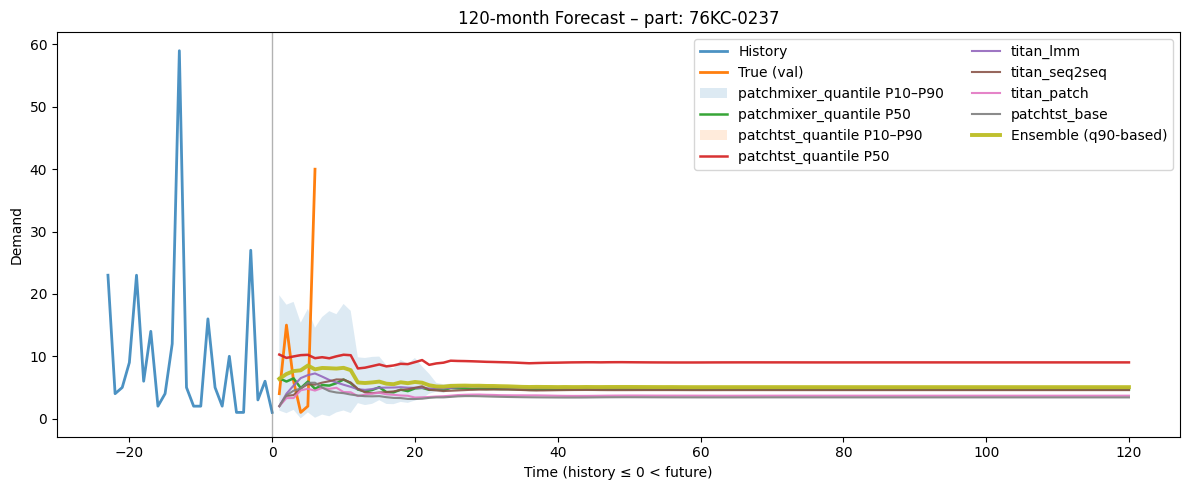

model PatchMixer QuantileModel [DBG] t 0 q10: 1.0934643745422363 q50: 4.026749610900879 q90: 14.18908405303955
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9070096015930176 q50: 3.800288438796997 q90: 13.804672241210938
model PatchMixer QuantileModel [DBG] t 2 q10: 1.376513957977295 q50: 4.027266025543213 q90: 12.897819519042969
model PatchMixer QuantileModel [DBG] t 3 q10: 1.6999645233154297 q50: 4.4156599044799805 q90: 12.482422828674316
model PatchMixer QuantileModel [DBG] t 4 q10: 2.1117818355560303 q50: 4.594134330749512 q90: 10.795772552490234
model PatchTST QuantileModel [DBG] t 0 q10: 5.625428199768066 q50: 5.717859268188477 q90: 5.821239948272705
model PatchTST QuantileModel [DBG] t 1 q10: 5.696635723114014 q50: 5.788614273071289 q90: 5.891699314117432
model PatchTST QuantileModel [DBG] t 2 q10: 5.896027088165283 q50: 5.9867706298828125 q90: 6.088846683502197
model PatchTST QuantileModel [DBG] t 3 q10: 6.062183856964111 q50: 6.151885986328125 q90: 6.252843856811523
model Pa

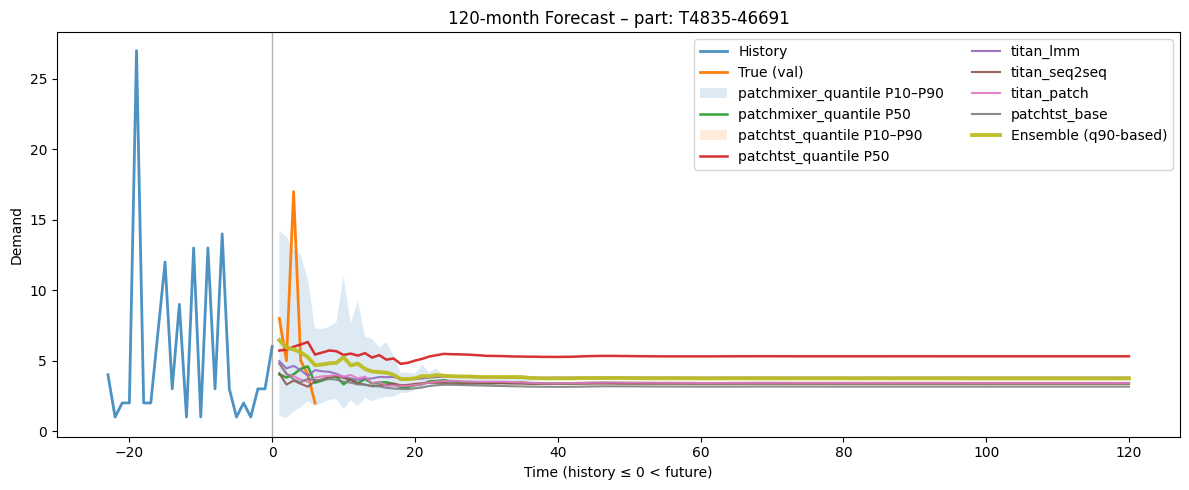

model PatchMixer QuantileModel [DBG] t 0 q10: 1.3469396829605103 q50: 1.8898475170135498 q90: 3.564802408218384
model PatchMixer QuantileModel [DBG] t 1 q10: 1.4083768129348755 q50: 1.9119539260864258 q90: 3.5878396034240723
model PatchMixer QuantileModel [DBG] t 2 q10: 1.5546255111694336 q50: 2.1711044311523438 q90: 4.577789783477783
model PatchMixer QuantileModel [DBG] t 3 q10: 1.2464033365249634 q50: 1.8133585453033447 q90: 3.5947160720825195
model PatchMixer QuantileModel [DBG] t 4 q10: 1.517759084701538 q50: 2.031313896179199 q90: 3.2344818115234375
model PatchTST QuantileModel [DBG] t 0 q10: 2.3750667572021484 q50: 2.3944101333618164 q90: 2.4160611629486084
model PatchTST QuantileModel [DBG] t 1 q10: 2.3914942741394043 q50: 2.4107747077941895 q90: 2.432403802871704
model PatchTST QuantileModel [DBG] t 2 q10: 2.4502792358398438 q50: 2.469104051589966 q90: 2.4901297092437744
model PatchTST QuantileModel [DBG] t 3 q10: 2.4697494506835938 q50: 2.488445281982422 q90: 2.509480237960815

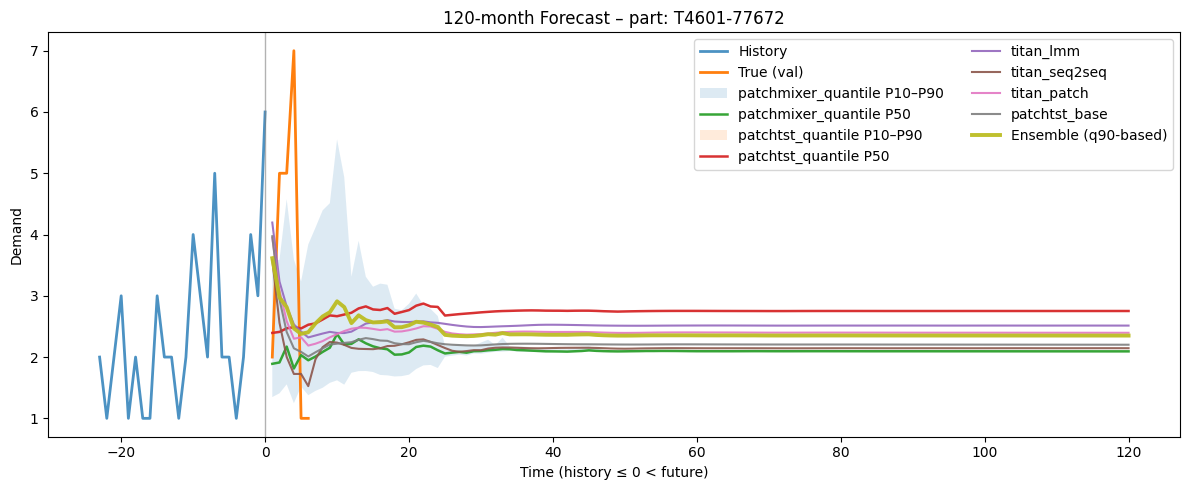

model PatchMixer QuantileModel [DBG] t 0 q10: 22.510040283203125 q50: 82.72077941894531 q90: 318.9084777832031
model PatchMixer QuantileModel [DBG] t 1 q10: 32.38874435424805 q50: 71.4306869506836 q90: 201.86038208007812
model PatchMixer QuantileModel [DBG] t 2 q10: 28.186935424804688 q50: 60.176876068115234 q90: 210.31427001953125
model PatchMixer QuantileModel [DBG] t 3 q10: 27.552989959716797 q50: 58.76939010620117 q90: 145.41116333007812
model PatchMixer QuantileModel [DBG] t 4 q10: 32.288509368896484 q50: 90.74412536621094 q90: 303.41143798828125
model PatchTST QuantileModel [DBG] t 0 q10: 100.28755950927734 q50: 101.60555267333984 q90: 103.09721374511719
model PatchTST QuantileModel [DBG] t 1 q10: 97.15310668945312 q50: 98.46102142333984 q90: 99.91983795166016
model PatchTST QuantileModel [DBG] t 2 q10: 89.00558471679688 q50: 90.1527328491211 q90: 91.44288635253906
model PatchTST QuantileModel [DBG] t 3 q10: 83.38823699951172 q50: 84.4580307006836 q90: 85.65361785888672
model Pat

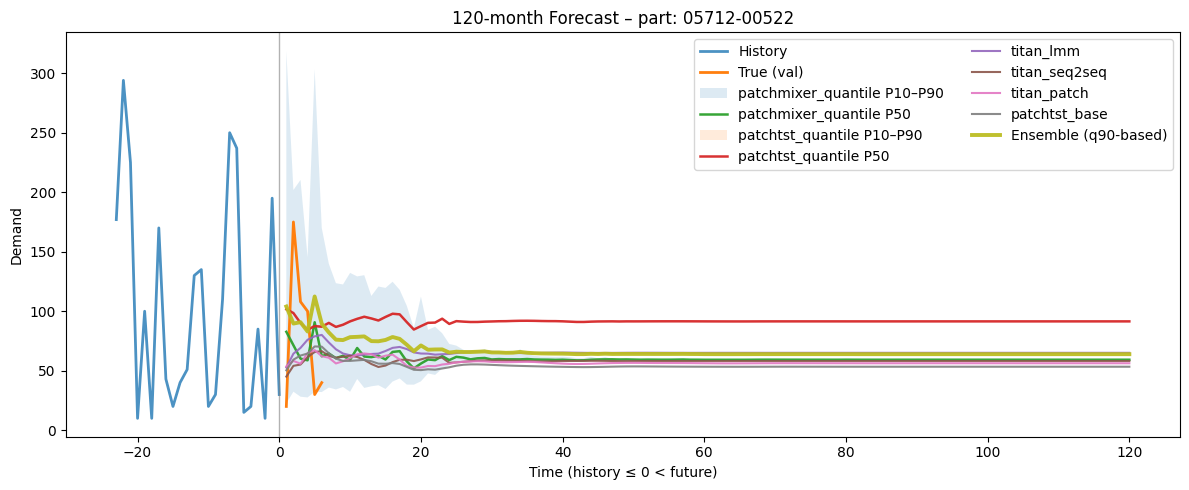

model PatchMixer QuantileModel [DBG] t 0 q10: 4.879201889038086 q50: 14.269194602966309 q90: 30.235050201416016
model PatchMixer QuantileModel [DBG] t 1 q10: 6.466849327087402 q50: 15.884464263916016 q90: 38.64411926269531
model PatchMixer QuantileModel [DBG] t 2 q10: 6.57142448425293 q50: 15.94728946685791 q90: 38.1566162109375
model PatchMixer QuantileModel [DBG] t 3 q10: 5.875820159912109 q50: 15.75332260131836 q90: 48.41582489013672
model PatchMixer QuantileModel [DBG] t 4 q10: 6.314484596252441 q50: 15.851591110229492 q90: 38.036163330078125
model PatchTST QuantileModel [DBG] t 0 q10: 23.33464241027832 q50: 23.694599151611328 q90: 24.099096298217773
model PatchTST QuantileModel [DBG] t 1 q10: 22.57052993774414 q50: 22.92483139038086 q90: 23.32322120666504
model PatchTST QuantileModel [DBG] t 2 q10: 23.442731857299805 q50: 23.79136085510254 q90: 24.183414459228516
model PatchTST QuantileModel [DBG] t 3 q10: 23.308725357055664 q50: 23.657365798950195 q90: 24.04813003540039
model Pat

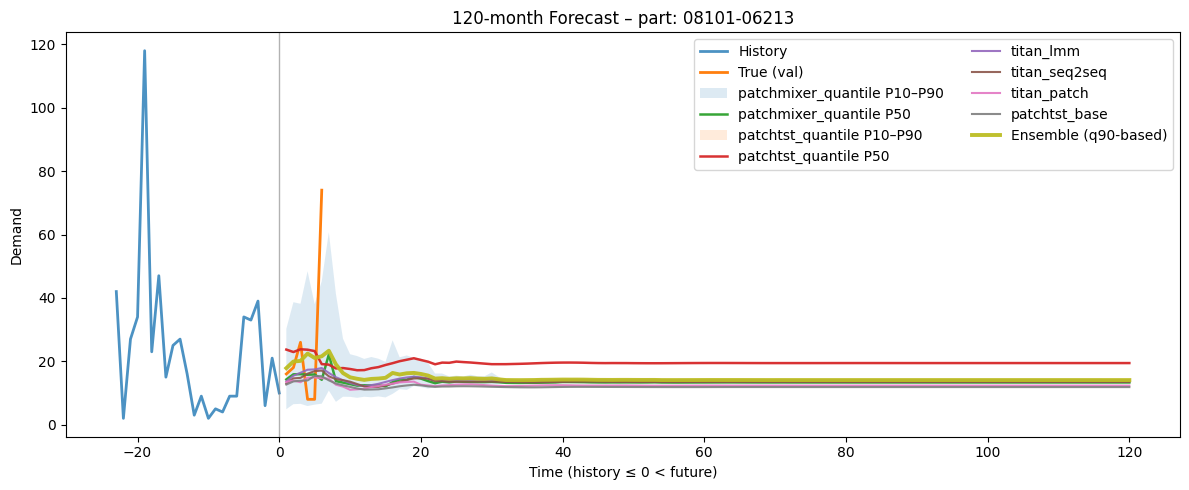

model PatchMixer QuantileModel [DBG] t 0 q10: 7.044857025146484 q50: 17.17401885986328 q90: 52.022010803222656
model PatchMixer QuantileModel [DBG] t 1 q10: 8.1550931930542 q50: 15.067468643188477 q90: 31.805240631103516
model PatchMixer QuantileModel [DBG] t 2 q10: 8.661491394042969 q50: 16.47247314453125 q90: 37.266746520996094
model PatchMixer QuantileModel [DBG] t 3 q10: 9.045975685119629 q50: 17.31369400024414 q90: 48.348052978515625
model PatchMixer QuantileModel [DBG] t 4 q10: 7.124129295349121 q50: 15.979562759399414 q90: 56.17390441894531
model PatchTST QuantileModel [DBG] t 0 q10: 22.75033950805664 q50: 23.024141311645508 q90: 23.33125114440918
model PatchTST QuantileModel [DBG] t 1 q10: 21.45859718322754 q50: 21.712980270385742 q90: 22.001436233520508
model PatchTST QuantileModel [DBG] t 2 q10: 22.155563354492188 q50: 22.404687881469727 q90: 22.686765670776367
model PatchTST QuantileModel [DBG] t 3 q10: 22.921770095825195 q50: 23.1639461517334 q90: 23.439390182495117
model P

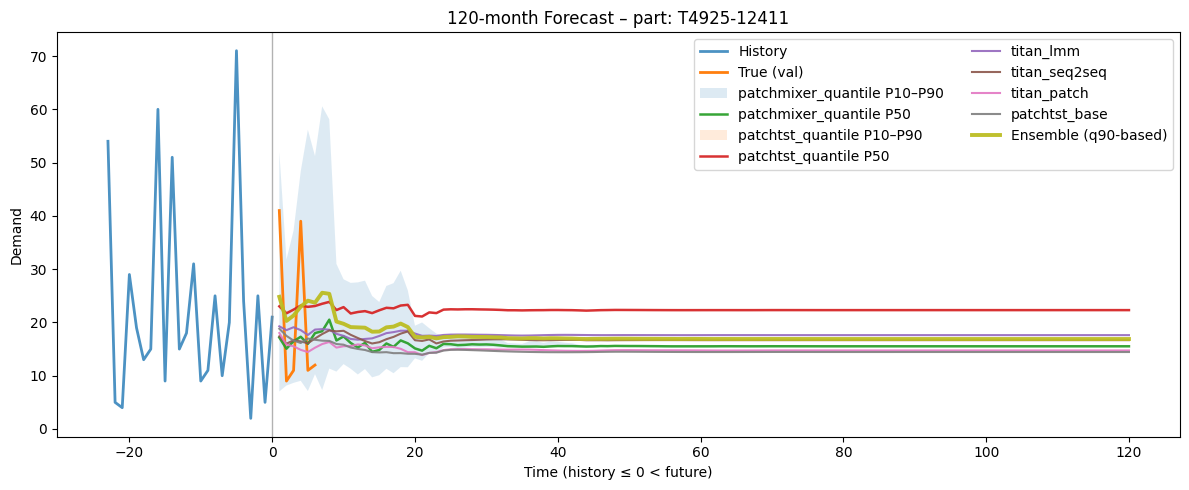

model PatchMixer QuantileModel [DBG] t 0 q10: 0.8590669631958008 q50: 1.3730183839797974 q90: 2.5899980068206787
model PatchMixer QuantileModel [DBG] t 1 q10: 0.7532966136932373 q50: 1.2263035774230957 q90: 2.473036050796509
model PatchMixer QuantileModel [DBG] t 2 q10: 0.674992024898529 q50: 1.2655028104782104 q90: 3.598285675048828
model PatchMixer QuantileModel [DBG] t 3 q10: 0.7887341976165771 q50: 1.2667537927627563 q90: 2.491373300552368
model PatchMixer QuantileModel [DBG] t 4 q10: 0.8723345994949341 q50: 1.3522263765335083 q90: 2.636874198913574
model PatchTST QuantileModel [DBG] t 0 q10: 1.708296298980713 q50: 1.7268309593200684 q90: 1.7478710412979126
model PatchTST QuantileModel [DBG] t 1 q10: 1.613610029220581 q50: 1.6308280229568481 q90: 1.6502093076705933
model PatchTST QuantileModel [DBG] t 2 q10: 1.6398944854736328 q50: 1.6569437980651855 q90: 1.676196575164795
model PatchTST QuantileModel [DBG] t 3 q10: 1.6673256158828735 q50: 1.684333324432373 q90: 1.7034424543380737


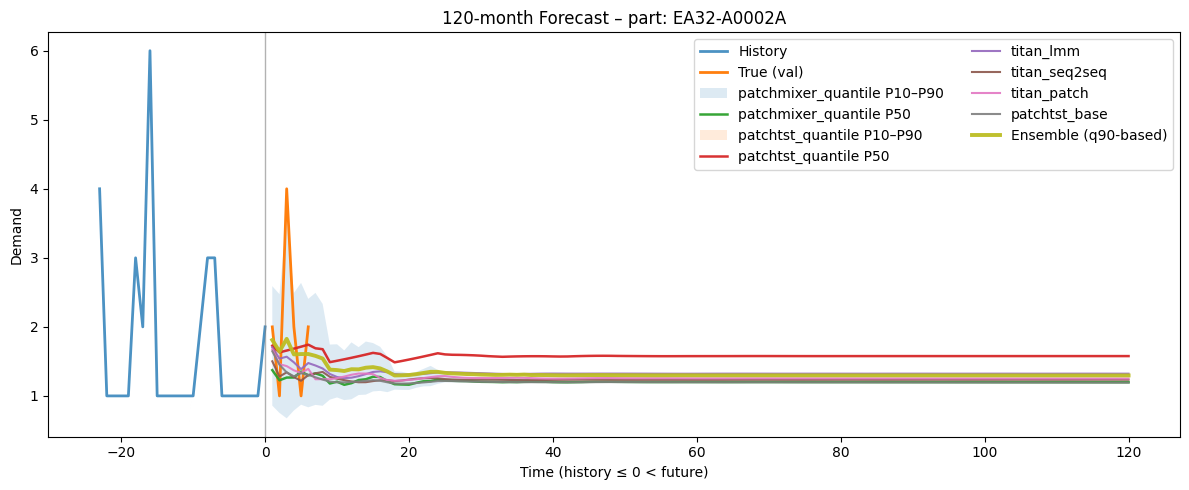

model PatchMixer QuantileModel [DBG] t 0 q10: -0.5220298767089844 q50: 30.267292022705078 q90: 157.86634826660156
model PatchMixer QuantileModel [DBG] t 1 q10: -0.0195465087890625 q50: 29.722013473510742 q90: 152.49594116210938
model PatchMixer QuantileModel [DBG] t 2 q10: 1.031982421875 q50: 22.827409744262695 q90: 89.22825622558594
model PatchMixer QuantileModel [DBG] t 3 q10: 2.690235137939453 q50: 19.520423889160156 q90: 69.53502655029297
model PatchMixer QuantileModel [DBG] t 4 q10: 2.096158981323242 q50: 16.946870803833008 q90: 51.77509307861328
model PatchTST QuantileModel [DBG] t 0 q10: 35.69898223876953 q50: 36.3970832824707 q90: 37.205047607421875
model PatchTST QuantileModel [DBG] t 1 q10: 35.43364715576172 q50: 36.143089294433594 q90: 36.9387092590332
model PatchTST QuantileModel [DBG] t 2 q10: 35.10761260986328 q50: 35.81923294067383 q90: 36.61160659790039
model PatchTST QuantileModel [DBG] t 3 q10: 29.348190307617188 q50: 29.906705856323242 q90: 30.53616714477539
model Pa

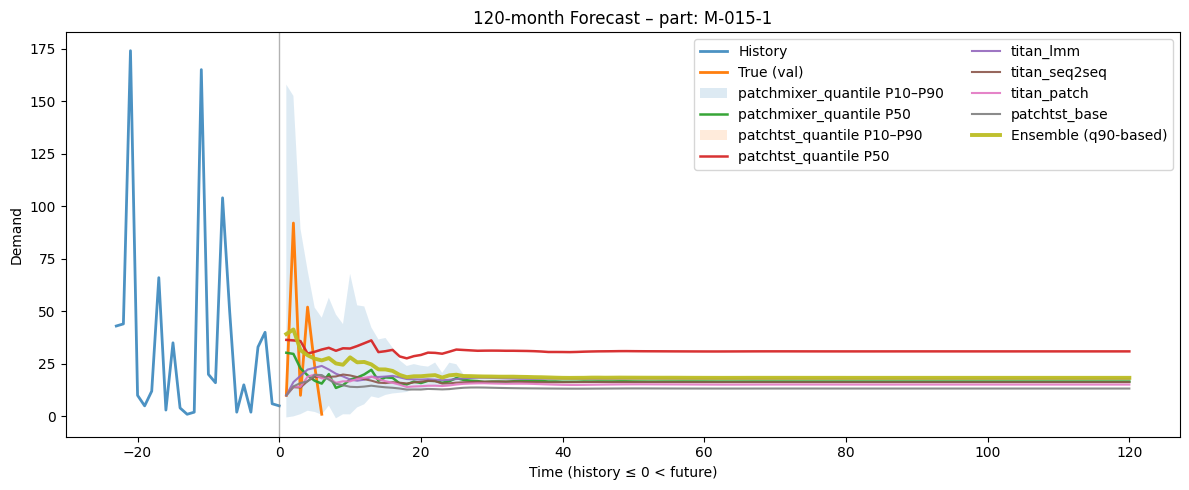

model PatchMixer QuantileModel [DBG] t 0 q10: 5.049922943115234 q50: 9.313735961914062 q90: 19.37383270263672
model PatchMixer QuantileModel [DBG] t 1 q10: 6.219308853149414 q50: 10.325486183166504 q90: 19.8630313873291
model PatchMixer QuantileModel [DBG] t 2 q10: 6.104854583740234 q50: 10.493518829345703 q90: 25.092500686645508
model PatchMixer QuantileModel [DBG] t 3 q10: 6.901917457580566 q50: 10.99617862701416 q90: 20.473554611206055
model PatchMixer QuantileModel [DBG] t 4 q10: 6.376058578491211 q50: 10.41427993774414 q90: 20.08182144165039
model PatchTST QuantileModel [DBG] t 0 q10: 13.916732788085938 q50: 14.075115203857422 q90: 14.25339412689209
model PatchTST QuantileModel [DBG] t 1 q10: 14.41968822479248 q50: 14.573198318481445 q90: 14.746811866760254
model PatchTST QuantileModel [DBG] t 2 q10: 14.610353469848633 q50: 14.76362419128418 q90: 14.936161994934082
model PatchTST QuantileModel [DBG] t 3 q10: 14.684067726135254 q50: 14.837372779846191 q90: 15.009794235229492
model 

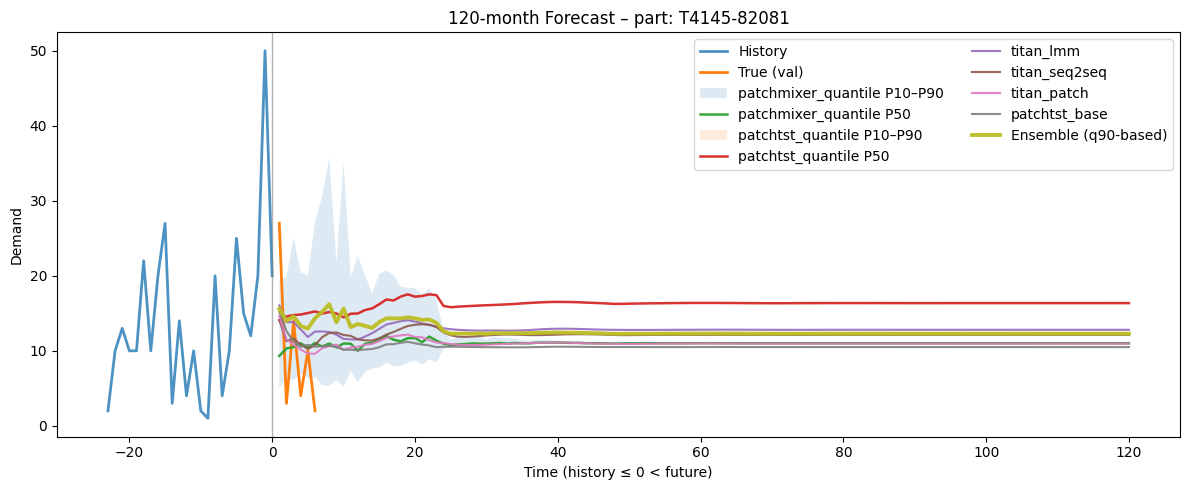

model PatchMixer QuantileModel [DBG] t 0 q10: 3.824028491973877 q50: 9.524789810180664 q90: 25.436203002929688
model PatchMixer QuantileModel [DBG] t 1 q10: 4.5652995109558105 q50: 9.329719543457031 q90: 28.642297744750977
model PatchMixer QuantileModel [DBG] t 2 q10: 4.194311141967773 q50: 10.040300369262695 q90: 32.29316329956055
model PatchMixer QuantileModel [DBG] t 3 q10: 12.024734497070312 q50: 20.90587615966797 q90: 45.51986312866211
model PatchMixer QuantileModel [DBG] t 4 q10: 5.791317462921143 q50: 9.603982925415039 q90: 24.602569580078125
model PatchTST QuantileModel [DBG] t 0 q10: 11.70855712890625 q50: 11.846704483032227 q90: 12.002471923828125
model PatchTST QuantileModel [DBG] t 1 q10: 11.993640899658203 q50: 12.130581855773926 q90: 12.284332275390625
model PatchTST QuantileModel [DBG] t 2 q10: 12.207736015319824 q50: 12.343942642211914 q90: 12.496338844299316
model PatchTST QuantileModel [DBG] t 3 q10: 12.513531684875488 q50: 12.647183418273926 q90: 12.798148155212402
m

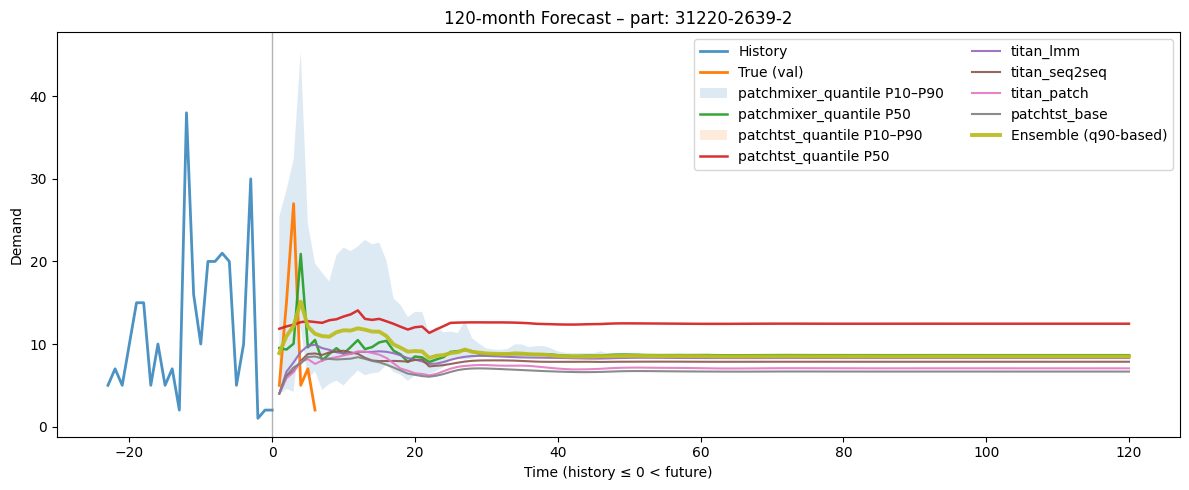

model PatchMixer QuantileModel [DBG] t 0 q10: 1.089108943939209 q50: 1.6374585628509521 q90: 3.1936562061309814
model PatchMixer QuantileModel [DBG] t 1 q10: 1.2934670448303223 q50: 1.7836494445800781 q90: 2.9235904216766357
model PatchMixer QuantileModel [DBG] t 2 q10: 1.2635236978530884 q50: 1.8779668807983398 q90: 3.9191460609436035
model PatchMixer QuantileModel [DBG] t 3 q10: 1.0048166513442993 q50: 1.4733777046203613 q90: 2.868563652038574
model PatchMixer QuantileModel [DBG] t 4 q10: 1.232175588607788 q50: 1.8009815216064453 q90: 4.110764503479004
model PatchTST QuantileModel [DBG] t 0 q10: 2.24989914894104 q50: 2.269225835800171 q90: 2.2913131713867188
model PatchTST QuantileModel [DBG] t 1 q10: 2.302852153778076 q50: 2.3219220638275146 q90: 2.343423366546631
model PatchTST QuantileModel [DBG] t 2 q10: 2.3162424564361572 q50: 2.3352267742156982 q90: 2.3567662239074707
model PatchTST QuantileModel [DBG] t 3 q10: 2.246917724609375 q50: 2.2651965618133545 q90: 2.2858834266662598
m

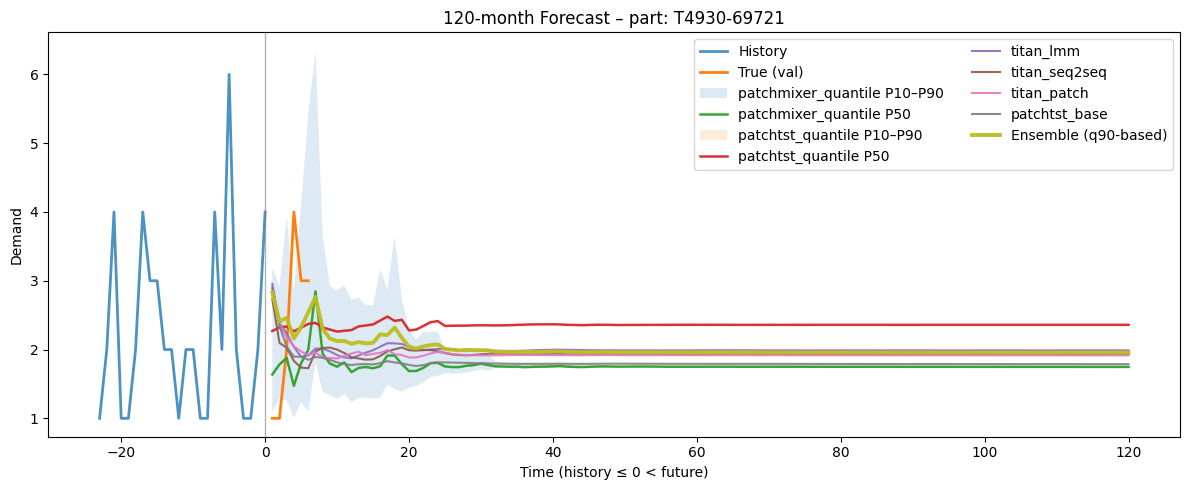

model PatchMixer QuantileModel [DBG] t 0 q10: 0.8291194438934326 q50: 1.9305286407470703 q90: 5.512642860412598
model PatchMixer QuantileModel [DBG] t 1 q10: 0.7626627683639526 q50: 1.7867209911346436 q90: 5.855179786682129
model PatchMixer QuantileModel [DBG] t 2 q10: 0.8220144510269165 q50: 1.946410894393921 q90: 6.377366065979004
model PatchMixer QuantileModel [DBG] t 3 q10: 0.5609524250030518 q50: 2.106149435043335 q90: 7.951621055603027
model PatchMixer QuantileModel [DBG] t 4 q10: 2.121683120727539 q50: 4.512094974517822 q90: 10.722857475280762
model PatchTST QuantileModel [DBG] t 0 q10: 2.54158878326416 q50: 2.573392391204834 q90: 2.6092655658721924
model PatchTST QuantileModel [DBG] t 1 q10: 2.5655887126922607 q50: 2.5973763465881348 q90: 2.6331377029418945
model PatchTST QuantileModel [DBG] t 2 q10: 2.632275104522705 q50: 2.663836717605591 q90: 2.699110507965088
model PatchTST QuantileModel [DBG] t 3 q10: 2.7015180587768555 q50: 2.7326009273529053 q90: 2.7674083709716797
model

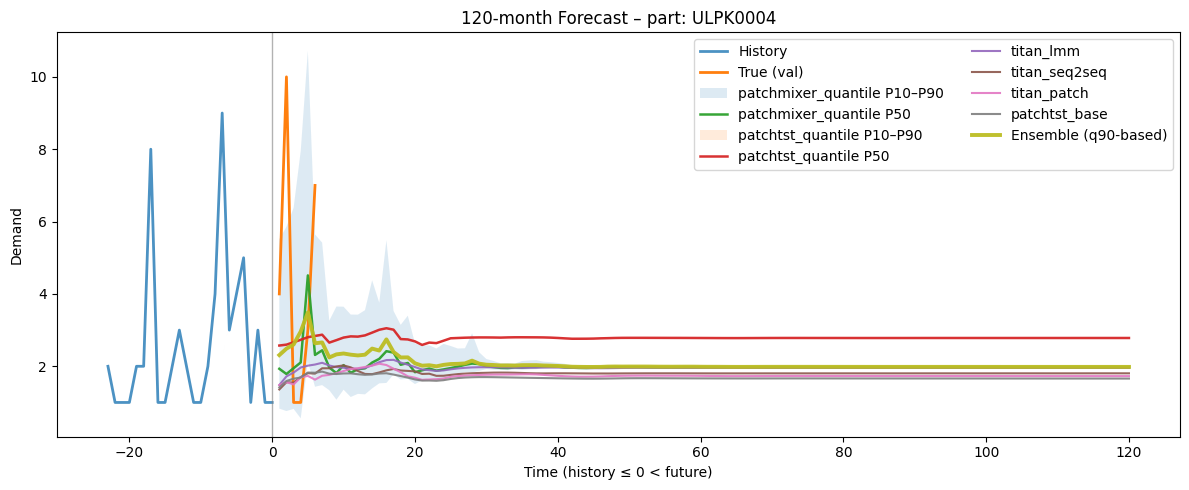

model PatchMixer QuantileModel [DBG] t 0 q10: 1.7077617645263672 q50: 3.838090419769287 q90: 10.003219604492188
model PatchMixer QuantileModel [DBG] t 1 q10: 1.8484597206115723 q50: 3.9684009552001953 q90: 8.800870895385742
model PatchMixer QuantileModel [DBG] t 2 q10: 1.5087885856628418 q50: 3.6486289501190186 q90: 9.133445739746094
model PatchMixer QuantileModel [DBG] t 3 q10: 2.0323286056518555 q50: 4.086782932281494 q90: 9.669790267944336
model PatchMixer QuantileModel [DBG] t 4 q10: 1.9682514667510986 q50: 4.206927299499512 q90: 11.506237030029297
model PatchTST QuantileModel [DBG] t 0 q10: 5.916932106018066 q50: 5.996516704559326 q90: 6.085256099700928
model PatchTST QuantileModel [DBG] t 1 q10: 6.083498954772949 q50: 6.162086009979248 q90: 6.24978494644165
model PatchTST QuantileModel [DBG] t 2 q10: 5.840226650238037 q50: 5.916615009307861 q90: 6.001869201660156
model PatchTST QuantileModel [DBG] t 3 q10: 6.003493309020996 q50: 6.07899808883667 q90: 6.1630940437316895
model Patc

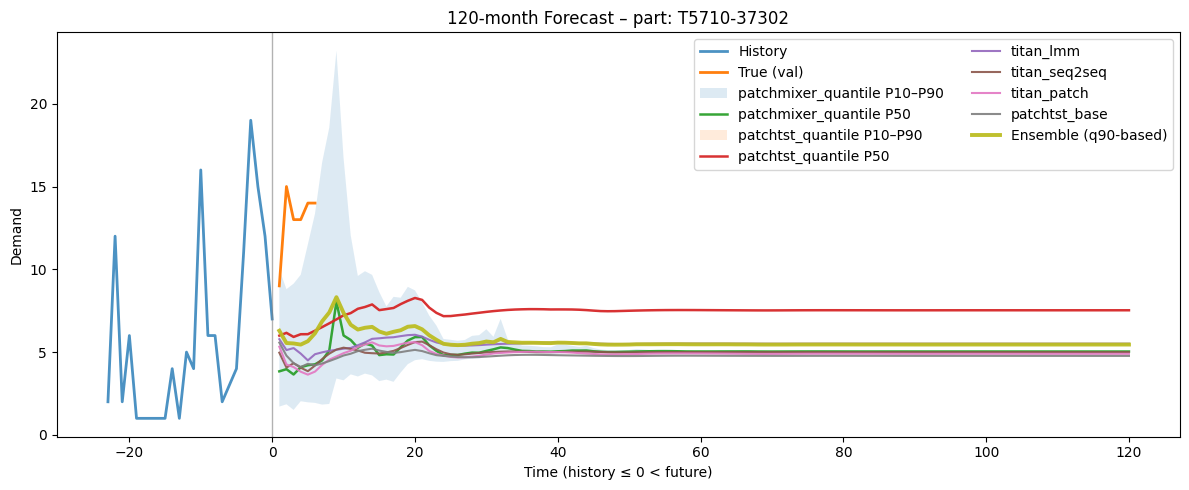

model PatchMixer QuantileModel [DBG] t 0 q10: 5.055753707885742 q50: 13.352458953857422 q90: 39.32087707519531
model PatchMixer QuantileModel [DBG] t 1 q10: 6.24880313873291 q50: 15.636292457580566 q90: 45.29095458984375
model PatchMixer QuantileModel [DBG] t 2 q10: 5.466712951660156 q50: 13.894136428833008 q90: 41.05797576904297
model PatchMixer QuantileModel [DBG] t 3 q10: 3.9791793823242188 q50: 11.174407958984375 q90: 27.709434509277344
model PatchMixer QuantileModel [DBG] t 4 q10: 7.114779472351074 q50: 14.616256713867188 q90: 31.960371017456055
model PatchTST QuantileModel [DBG] t 0 q10: 20.167591094970703 q50: 20.46411895751953 q90: 20.795766830444336
model PatchTST QuantileModel [DBG] t 1 q10: 20.811296463012695 q50: 21.103334426879883 q90: 21.431095123291016
model PatchTST QuantileModel [DBG] t 2 q10: 19.52438735961914 q50: 19.80039405822754 q90: 20.108877182006836
model PatchTST QuantileModel [DBG] t 3 q10: 19.93347930908203 q50: 20.208467483520508 q90: 20.514795303344727
mod

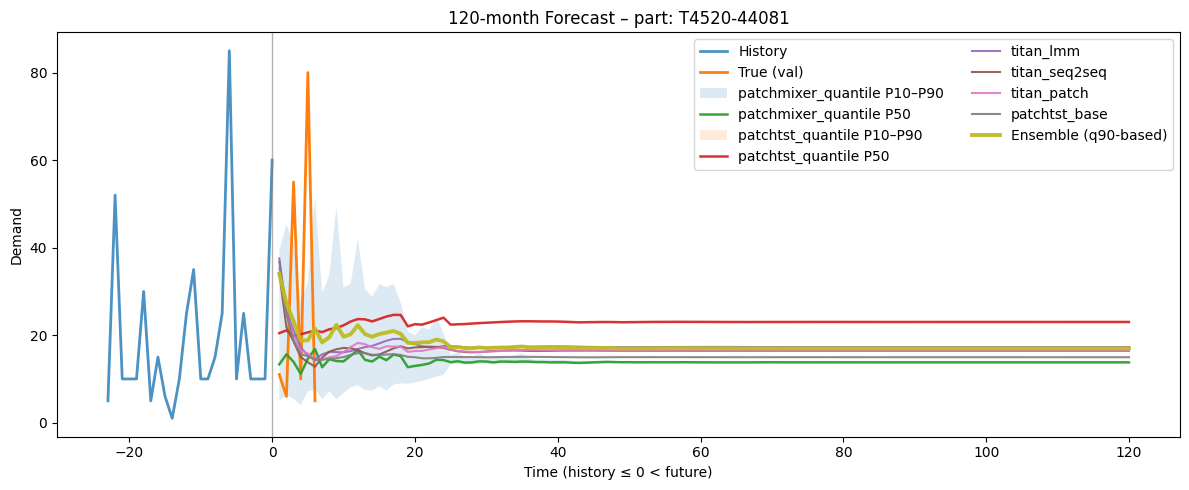

model PatchMixer QuantileModel [DBG] t 0 q10: 12.560759544372559 q50: 18.337299346923828 q90: 36.077640533447266
model PatchMixer QuantileModel [DBG] t 1 q10: 10.968476295471191 q50: 16.293506622314453 q90: 35.582725524902344
model PatchMixer QuantileModel [DBG] t 2 q10: 13.265311241149902 q50: 18.087772369384766 q90: 33.34038162231445
model PatchMixer QuantileModel [DBG] t 3 q10: 13.61933708190918 q50: 18.414297103881836 q90: 40.313079833984375
model PatchMixer QuantileModel [DBG] t 4 q10: 13.64887809753418 q50: 19.666057586669922 q90: 46.39160919189453
model PatchTST QuantileModel [DBG] t 0 q10: 21.458520889282227 q50: 21.639001846313477 q90: 21.84189224243164
model PatchTST QuantileModel [DBG] t 1 q10: 21.610368728637695 q50: 21.79052734375 q90: 21.993263244628906
model PatchTST QuantileModel [DBG] t 2 q10: 22.310073852539062 q50: 22.482664108276367 q90: 22.676471710205078
model PatchTST QuantileModel [DBG] t 3 q10: 23.12116813659668 q50: 23.282068252563477 q90: 23.46410369873047
mo

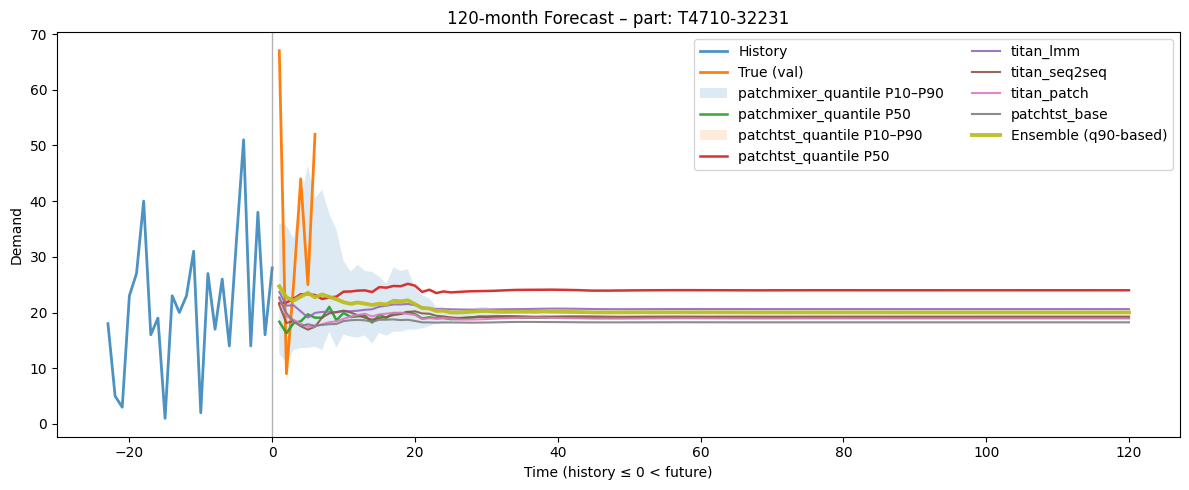

model PatchMixer QuantileModel [DBG] t 0 q10: 22.572784423828125 q50: 66.27130889892578 q90: 179.77719116210938
model PatchMixer QuantileModel [DBG] t 1 q10: 21.770767211914062 q50: 67.00747680664062 q90: 207.6919403076172
model PatchMixer QuantileModel [DBG] t 2 q10: 34.32867431640625 q50: 84.36553955078125 q90: 263.4952392578125
model PatchMixer QuantileModel [DBG] t 3 q10: 37.923912048339844 q50: 92.53553771972656 q90: 312.938232421875
model PatchMixer QuantileModel [DBG] t 4 q10: 38.73761749267578 q50: 89.32441711425781 q90: 298.1554870605469
model PatchTST QuantileModel [DBG] t 0 q10: 112.79237365722656 q50: 114.4603500366211 q90: 116.33421325683594
model PatchTST QuantileModel [DBG] t 1 q10: 117.52294921875 q50: 119.15741729736328 q90: 120.9847183227539
model PatchTST QuantileModel [DBG] t 2 q10: 122.28131866455078 q50: 123.87474060058594 q90: 125.66256713867188
model PatchTST QuantileModel [DBG] t 3 q10: 127.23438262939453 q50: 128.78997802734375 q90: 130.5240478515625
model Pat

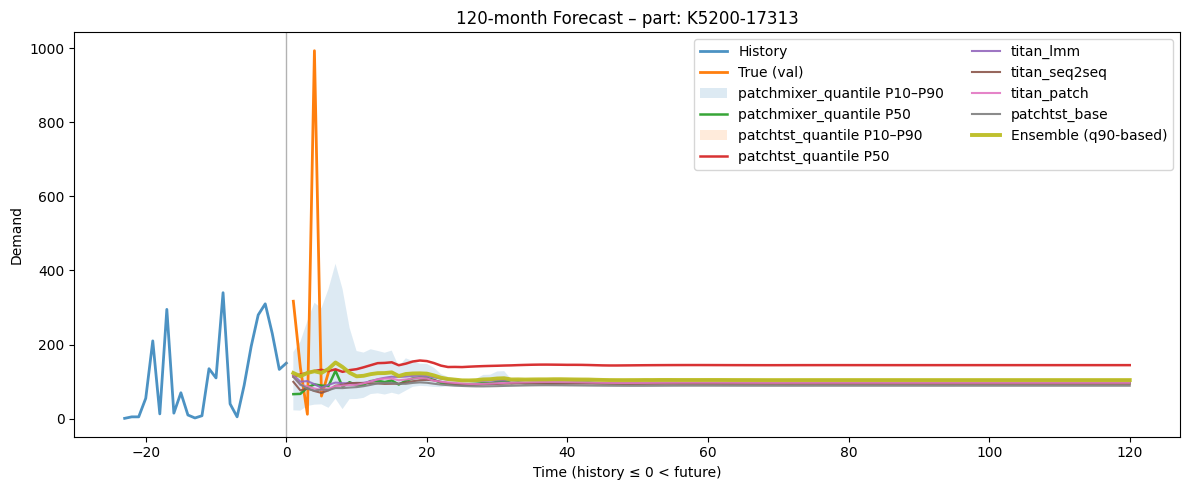

model PatchMixer QuantileModel [DBG] t 0 q10: 8.177848815917969 q50: 78.15166473388672 q90: 374.5188903808594
model PatchMixer QuantileModel [DBG] t 1 q10: 43.986656188964844 q50: 124.16844177246094 q90: 457.01922607421875
model PatchMixer QuantileModel [DBG] t 2 q10: 31.47809600830078 q50: 77.43050384521484 q90: 197.306640625
model PatchMixer QuantileModel [DBG] t 3 q10: 31.377063751220703 q50: 75.502197265625 q90: 211.35891723632812
model PatchMixer QuantileModel [DBG] t 4 q10: 24.280059814453125 q50: 61.99272918701172 q90: 153.61196899414062
model PatchTST QuantileModel [DBG] t 0 q10: 109.24888610839844 q50: 111.0731201171875 q90: 113.13137817382812
model PatchTST QuantileModel [DBG] t 1 q10: 111.38282775878906 q50: 113.20468139648438 q90: 115.25010681152344
model PatchTST QuantileModel [DBG] t 2 q10: 112.5522689819336 q50: 114.3658676147461 q90: 116.41291809082031
model PatchTST QuantileModel [DBG] t 3 q10: 97.73248291015625 q50: 99.16358947753906 q90: 100.77984619140625
model Patc

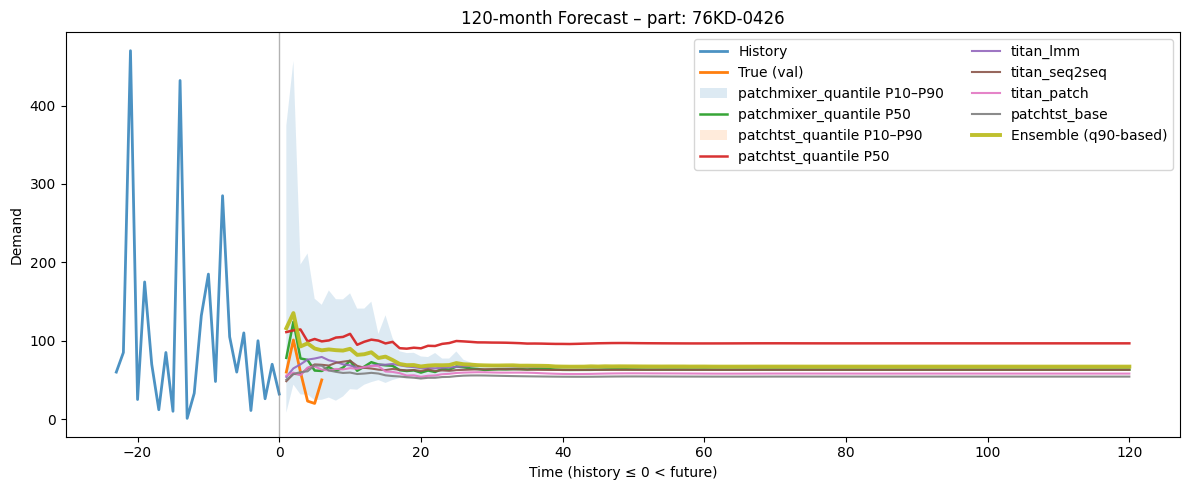

model PatchMixer QuantileModel [DBG] t 0 q10: 0.4851951599121094 q50: 2.0649125576019287 q90: 7.7259626388549805
model PatchMixer QuantileModel [DBG] t 1 q10: 0.31057071685791016 q50: 2.1248841285705566 q90: 10.433531761169434
model PatchMixer QuantileModel [DBG] t 2 q10: 0.49732136726379395 q50: 2.2043399810791016 q90: 9.257396697998047
model PatchMixer QuantileModel [DBG] t 3 q10: 1.9676620960235596 q50: 4.732616424560547 q90: 14.163232803344727
model PatchMixer QuantileModel [DBG] t 4 q10: 0.6348254680633545 q50: 2.2790744304656982 q90: 8.827619552612305
model PatchTST QuantileModel [DBG] t 0 q10: 3.125114679336548 q50: 3.1776864528656006 q90: 3.236508846282959
model PatchTST QuantileModel [DBG] t 1 q10: 3.2158682346343994 q50: 3.2680814266204834 q90: 3.326343297958374
model PatchTST QuantileModel [DBG] t 2 q10: 2.935344696044922 q50: 2.9829556941986084 q90: 3.036242723464966
model PatchTST QuantileModel [DBG] t 3 q10: 3.0178675651550293 q50: 3.064919948577881 q90: 3.11796236038208


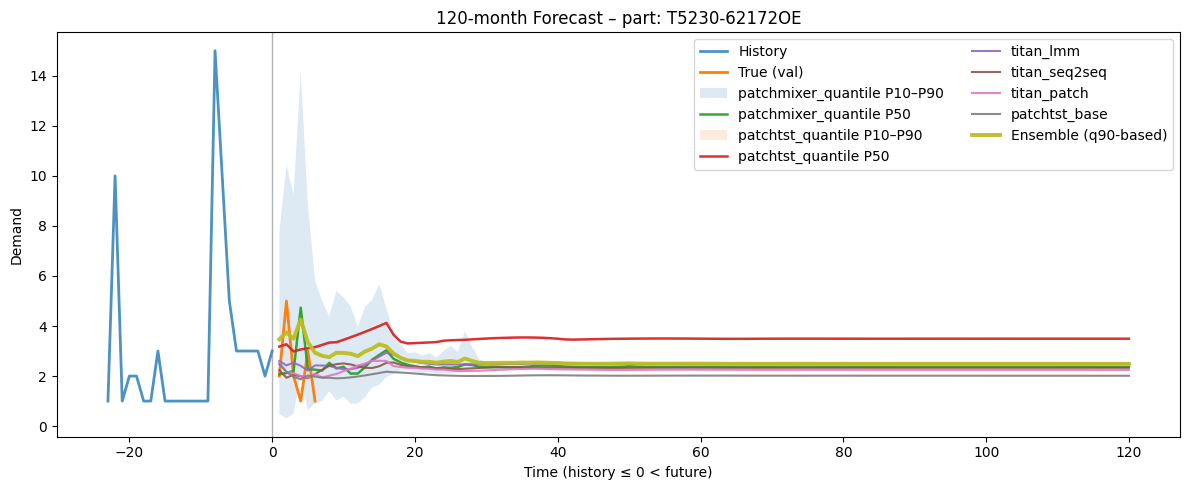

model PatchMixer QuantileModel [DBG] t 0 q10: 1.4968948364257812 q50: 44.15742492675781 q90: 138.59869384765625
model PatchMixer QuantileModel [DBG] t 1 q10: -5.275871276855469 q50: 40.65742492675781 q90: 152.38206481933594
model PatchMixer QuantileModel [DBG] t 2 q10: 0.02394866943359375 q50: 43.779144287109375 q90: 147.71470642089844
model PatchMixer QuantileModel [DBG] t 3 q10: -1.4402389526367188 q50: 43.810874938964844 q90: 153.94049072265625
model PatchMixer QuantileModel [DBG] t 4 q10: -9.86041259765625 q50: 33.09373474121094 q90: 125.27767944335938
model PatchTST QuantileModel [DBG] t 0 q10: 71.58234405517578 q50: 73.26509857177734 q90: 75.1573715209961
model PatchTST QuantileModel [DBG] t 1 q10: 72.45760345458984 q50: 74.1214599609375 q90: 76.03203582763672
model PatchTST QuantileModel [DBG] t 2 q10: 74.89405059814453 q50: 76.56498718261719 q90: 78.4502944946289
model PatchTST QuantileModel [DBG] t 3 q10: 77.53833770751953 q50: 79.19969940185547 q90: 81.07097625732422
model Pa

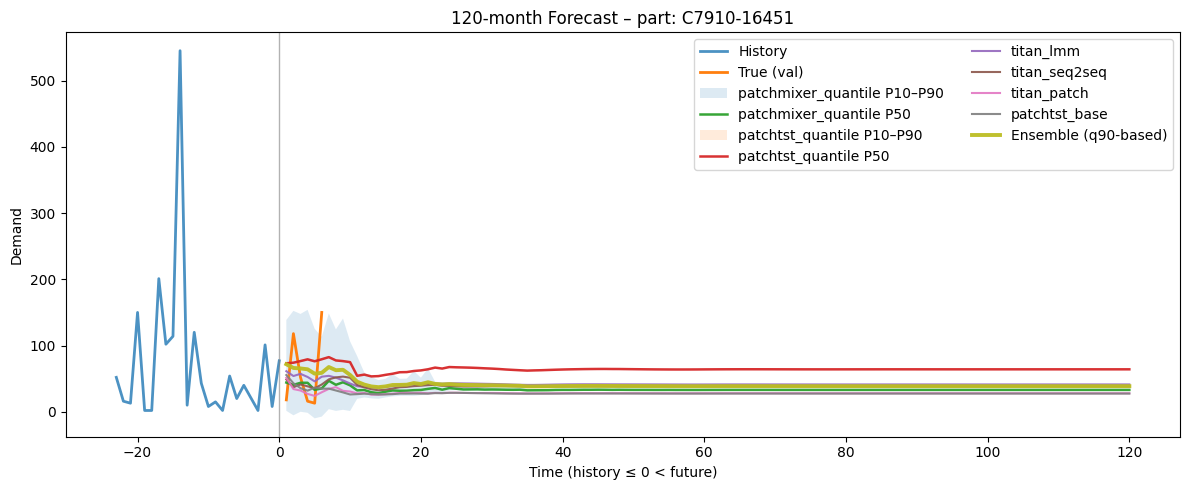

model PatchMixer QuantileModel [DBG] t 0 q10: 1.8411275148391724 q50: 2.535731554031372 q90: 4.1534647941589355
model PatchMixer QuantileModel [DBG] t 1 q10: 1.8018630743026733 q50: 2.4825611114501953 q90: 4.057734489440918
model PatchMixer QuantileModel [DBG] t 2 q10: 1.6669236421585083 q50: 2.3942575454711914 q90: 5.240997314453125
model PatchMixer QuantileModel [DBG] t 3 q10: 1.7710049152374268 q50: 2.5890419483184814 q90: 6.145517349243164
model PatchMixer QuantileModel [DBG] t 4 q10: 1.905457854270935 q50: 2.6834750175476074 q90: 5.50944709777832
model PatchTST QuantileModel [DBG] t 0 q10: 3.125054359436035 q50: 3.1512515544891357 q90: 3.1805529594421387
model PatchTST QuantileModel [DBG] t 1 q10: 3.048072338104248 q50: 3.0736067295074463 q90: 3.102160930633545
model PatchTST QuantileModel [DBG] t 2 q10: 3.0927491188049316 q50: 3.117955207824707 q90: 3.1463840007781982
model PatchTST QuantileModel [DBG] t 3 q10: 3.1810364723205566 q50: 3.205491304397583 q90: 3.232844829559326
mode

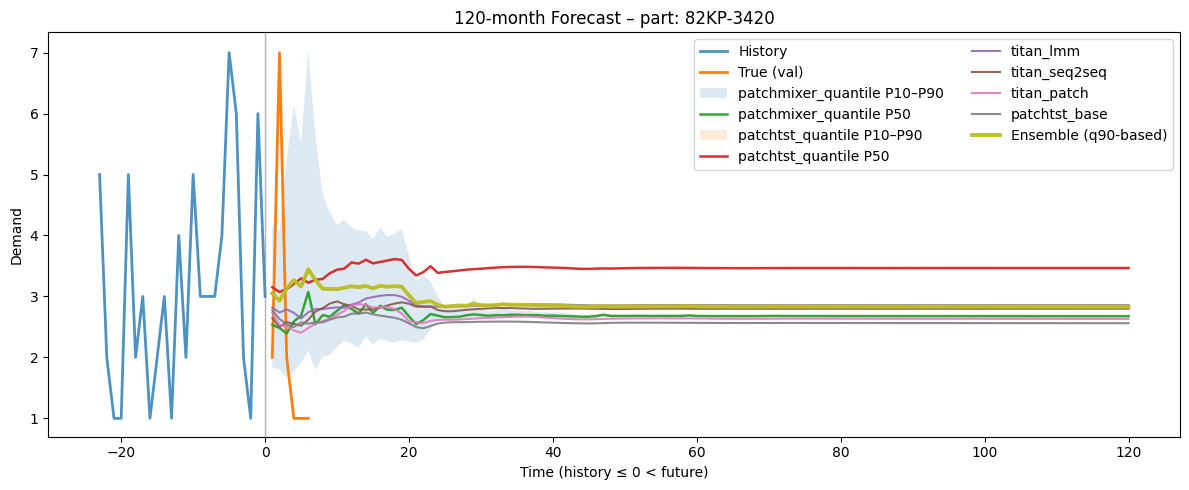

model PatchMixer QuantileModel [DBG] t 0 q10: -715.362548828125 q50: 112.01605224609375 q90: 2235.50732421875
model PatchMixer QuantileModel [DBG] t 1 q10: -539.8447265625 q50: 296.23028564453125 q90: 1778.482177734375
model PatchMixer QuantileModel [DBG] t 2 q10: -637.3822021484375 q50: 276.68841552734375 q90: 2406.121826171875
model PatchMixer QuantileModel [DBG] t 3 q10: -557.4154052734375 q50: 351.80157470703125 q90: 4359.552734375
model PatchMixer QuantileModel [DBG] t 4 q10: -473.0667724609375 q50: 340.5931396484375 q90: 2323.74169921875
model PatchTST QuantileModel [DBG] t 0 q10: 1110.938232421875 q50: 1143.292236328125 q90: 1179.594970703125
model PatchTST QuantileModel [DBG] t 1 q10: 1131.8677978515625 q50: 1164.03515625 q90: 1200.370849609375
model PatchTST QuantileModel [DBG] t 2 q10: 1155.6884765625 q50: 1187.972900390625 q90: 1224.2625732421875
model PatchTST QuantileModel [DBG] t 3 q10: 1190.559814453125 q50: 1222.7442626953125 q90: 1258.8319091796875
model PatchTST Quant

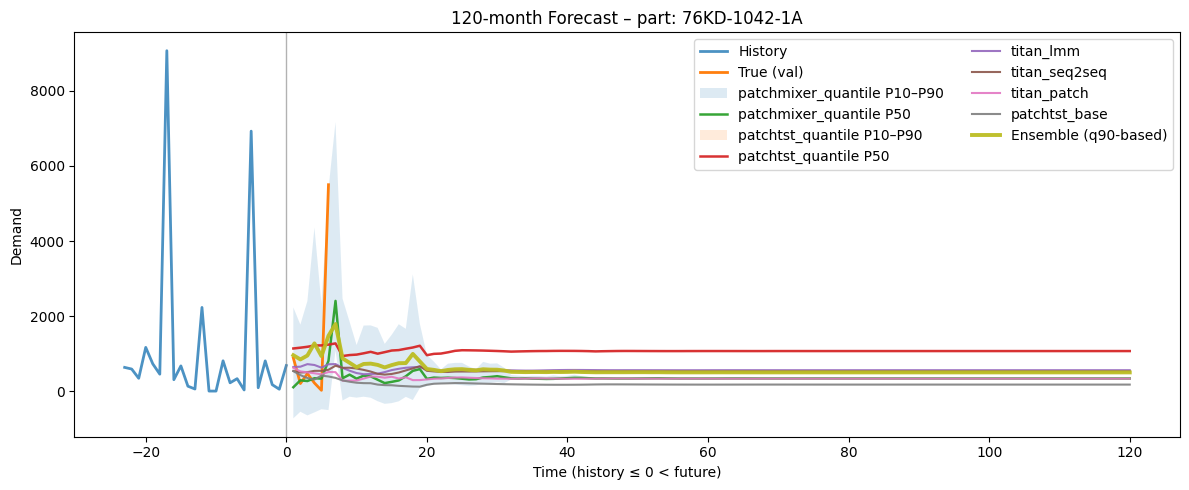

model PatchMixer QuantileModel [DBG] t 0 q10: 1.3821773529052734 q50: 2.4450032711029053 q90: 5.138050079345703
model PatchMixer QuantileModel [DBG] t 1 q10: 1.759505271911621 q50: 2.8877205848693848 q90: 5.53324031829834
model PatchMixer QuantileModel [DBG] t 2 q10: 1.340087652206421 q50: 2.4385008811950684 q90: 4.970437526702881
model PatchMixer QuantileModel [DBG] t 3 q10: 1.0813584327697754 q50: 2.0993049144744873 q90: 4.926486968994141
model PatchMixer QuantileModel [DBG] t 4 q10: 1.2893145084381104 q50: 2.498279094696045 q90: 6.583482265472412
model PatchTST QuantileModel [DBG] t 0 q10: 3.8334555625915527 q50: 3.8754541873931885 q90: 3.9225473403930664
model PatchTST QuantileModel [DBG] t 1 q10: 3.7448158264160156 q50: 3.7862279415130615 q90: 3.8327267169952393
model PatchTST QuantileModel [DBG] t 2 q10: 3.6109585762023926 q50: 3.6510963439941406 q90: 3.6961894035339355
model PatchTST QuantileModel [DBG] t 3 q10: 3.554683208465576 q50: 3.5945305824279785 q90: 3.6393885612487793
m

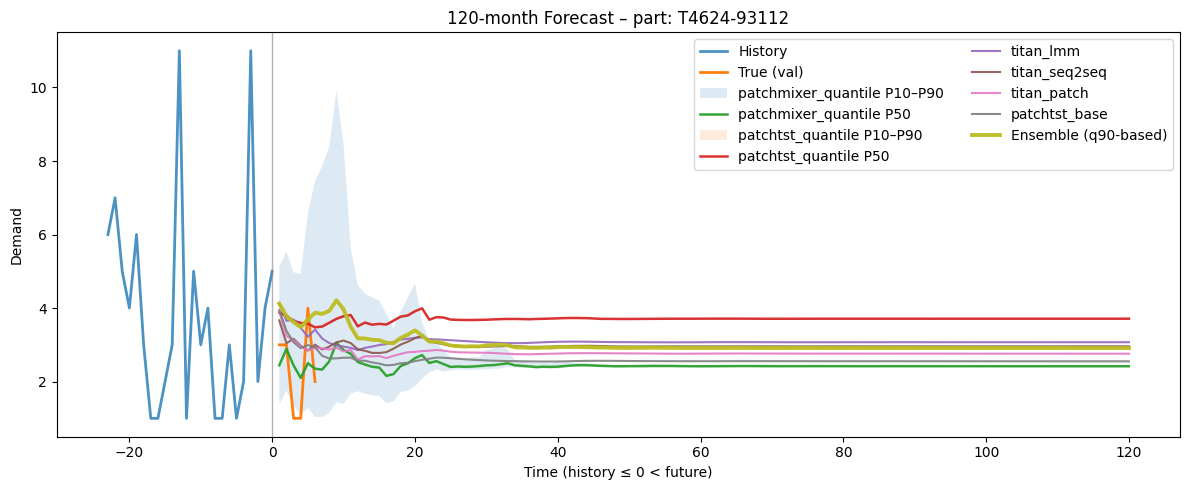

model PatchMixer QuantileModel [DBG] t 0 q10: 2.3408191204071045 q50: 4.1647186279296875 q90: 9.855171203613281
model PatchMixer QuantileModel [DBG] t 1 q10: 1.7934179306030273 q50: 3.3497555255889893 q90: 7.47117805480957
model PatchMixer QuantileModel [DBG] t 2 q10: 1.8199024200439453 q50: 3.301938056945801 q90: 6.713235855102539
model PatchMixer QuantileModel [DBG] t 3 q10: 1.9007008075714111 q50: 3.3898093700408936 q90: 6.964173316955566
model PatchMixer QuantileModel [DBG] t 4 q10: 1.8377952575683594 q50: 3.2226462364196777 q90: 5.94183874130249
model PatchTST QuantileModel [DBG] t 0 q10: 4.958469867706299 q50: 5.016549110412598 q90: 5.081533908843994
model PatchTST QuantileModel [DBG] t 1 q10: 4.9588823318481445 q50: 5.0165019035339355 q90: 5.081831932067871
model PatchTST QuantileModel [DBG] t 2 q10: 4.709815979003906 q50: 4.764638423919678 q90: 4.826327800750732
model PatchTST QuantileModel [DBG] t 3 q10: 4.824980735778809 q50: 4.8791399002075195 q90: 4.939916610717773
model Pa

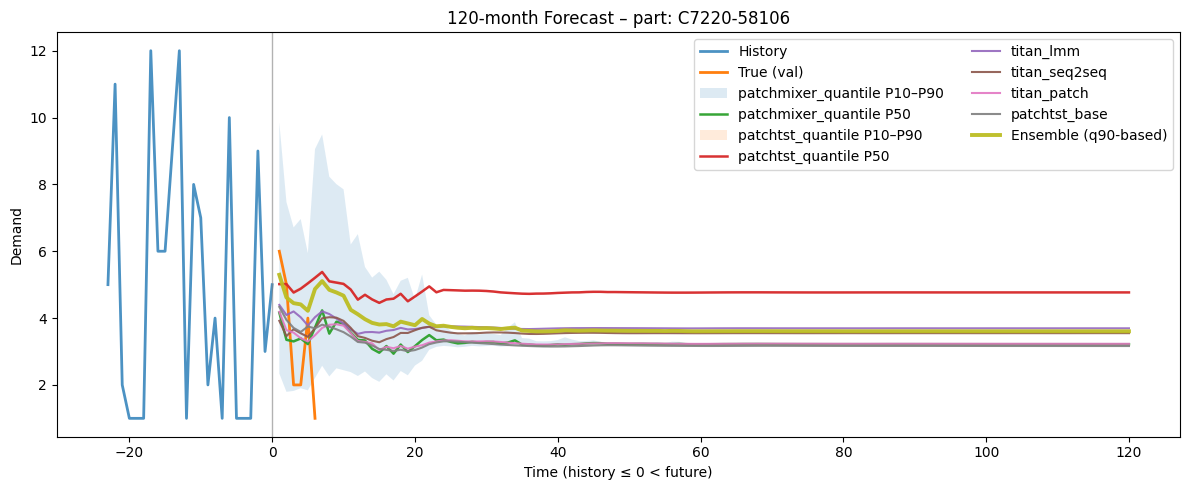

model PatchMixer QuantileModel [DBG] t 0 q10: 1.3596398830413818 q50: 2.4203972816467285 q90: 5.762584686279297
model PatchMixer QuantileModel [DBG] t 1 q10: 1.5588815212249756 q50: 2.803147554397583 q90: 6.494807720184326
model PatchMixer QuantileModel [DBG] t 2 q10: 1.4622056484222412 q50: 2.842026710510254 q90: 7.406176567077637
model PatchMixer QuantileModel [DBG] t 3 q10: 1.7529432773590088 q50: 2.810366153717041 q90: 7.582266330718994
model PatchMixer QuantileModel [DBG] t 4 q10: 2.039393901824951 q50: 3.0815930366516113 q90: 5.3902082443237305
model PatchTST QuantileModel [DBG] t 0 q10: 3.750048875808716 q50: 3.7900521755218506 q90: 3.8350555896759033
model PatchTST QuantileModel [DBG] t 1 q10: 3.782938241958618 q50: 3.822845220565796 q90: 3.867824077606201
model PatchTST QuantileModel [DBG] t 2 q10: 3.858985662460327 q50: 3.89867901802063 q90: 3.9430668354034424
model PatchTST QuantileModel [DBG] t 3 q10: 3.9797754287719727 q50: 4.018372058868408 q90: 4.061631202697754
model Pa

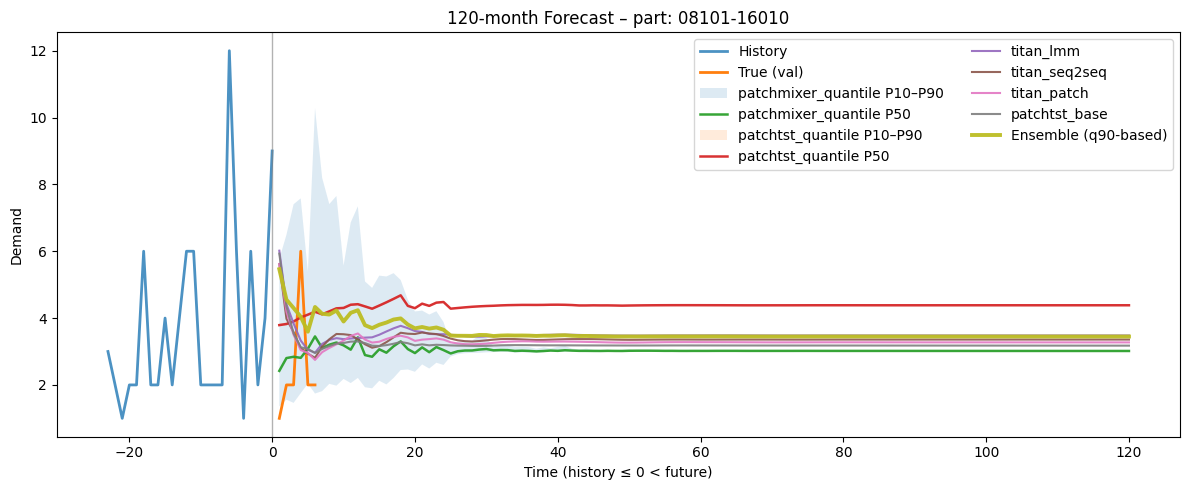

model PatchMixer QuantileModel [DBG] t 0 q10: 8.7823486328125 q50: 18.281692504882812 q90: 52.40917205810547
model PatchMixer QuantileModel [DBG] t 1 q10: 13.6420316696167 q50: 25.30753517150879 q90: 74.79386901855469
model PatchMixer QuantileModel [DBG] t 2 q10: 11.388108253479004 q50: 19.578563690185547 q90: 39.21821594238281
model PatchMixer QuantileModel [DBG] t 3 q10: 13.197208404541016 q50: 22.248348236083984 q90: 53.9276123046875
model PatchMixer QuantileModel [DBG] t 4 q10: 9.816263198852539 q50: 20.240055084228516 q90: 58.753440856933594
model PatchTST QuantileModel [DBG] t 0 q10: 25.583642959594727 q50: 25.907594680786133 q90: 26.27200698852539
model PatchTST QuantileModel [DBG] t 1 q10: 26.622417449951172 q50: 26.93843650817871 q90: 27.291414260864258
model PatchTST QuantileModel [DBG] t 2 q10: 27.243961334228516 q50: 27.555498123168945 q90: 27.905521392822266
model PatchTST QuantileModel [DBG] t 3 q10: 25.640687942504883 q50: 25.92658805847168 q90: 26.250242233276367
model 

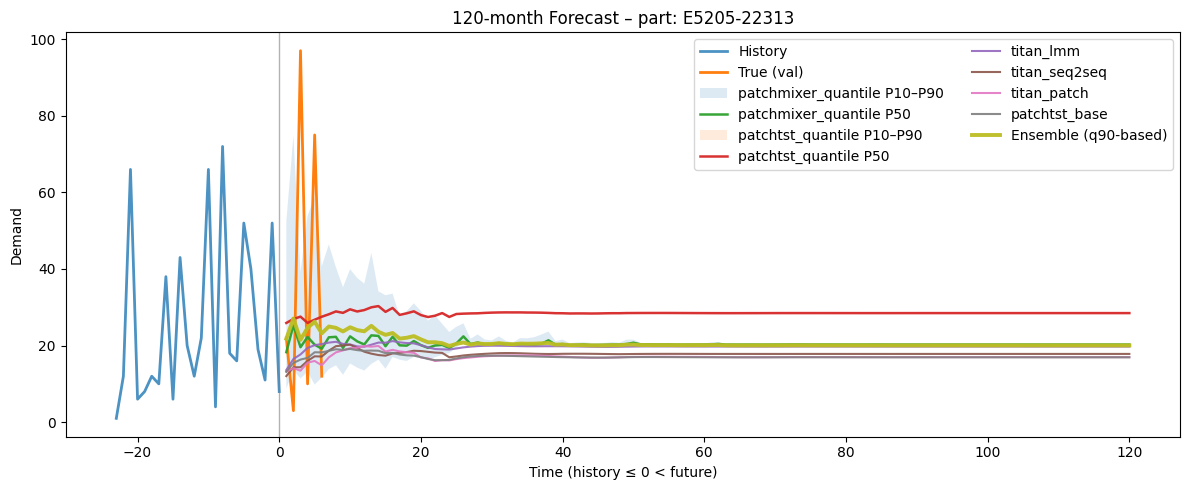

model PatchMixer QuantileModel [DBG] t 0 q10: 1.5098457336425781 q50: 3.5846052169799805 q90: 12.251643180847168
model PatchMixer QuantileModel [DBG] t 1 q10: 2.1204638481140137 q50: 4.113205432891846 q90: 8.527119636535645
model PatchMixer QuantileModel [DBG] t 2 q10: 1.8034234046936035 q50: 4.110523223876953 q90: 11.261253356933594
model PatchMixer QuantileModel [DBG] t 3 q10: 1.925879955291748 q50: 3.7863378524780273 q90: 7.75712776184082
model PatchMixer QuantileModel [DBG] t 4 q10: 1.8749427795410156 q50: 4.239507675170898 q90: 11.442093849182129
model PatchTST QuantileModel [DBG] t 0 q10: 6.000068187713623 q50: 6.0744547843933105 q90: 6.1585516929626465
model PatchTST QuantileModel [DBG] t 1 q10: 6.169835567474365 q50: 6.243433952331543 q90: 6.325976371765137
model PatchTST QuantileModel [DBG] t 2 q10: 6.263032913208008 q50: 6.335986614227295 q90: 6.418309688568115
model PatchTST QuantileModel [DBG] t 3 q10: 6.152231216430664 q50: 6.224698543548584 q90: 6.306593418121338
model Pa

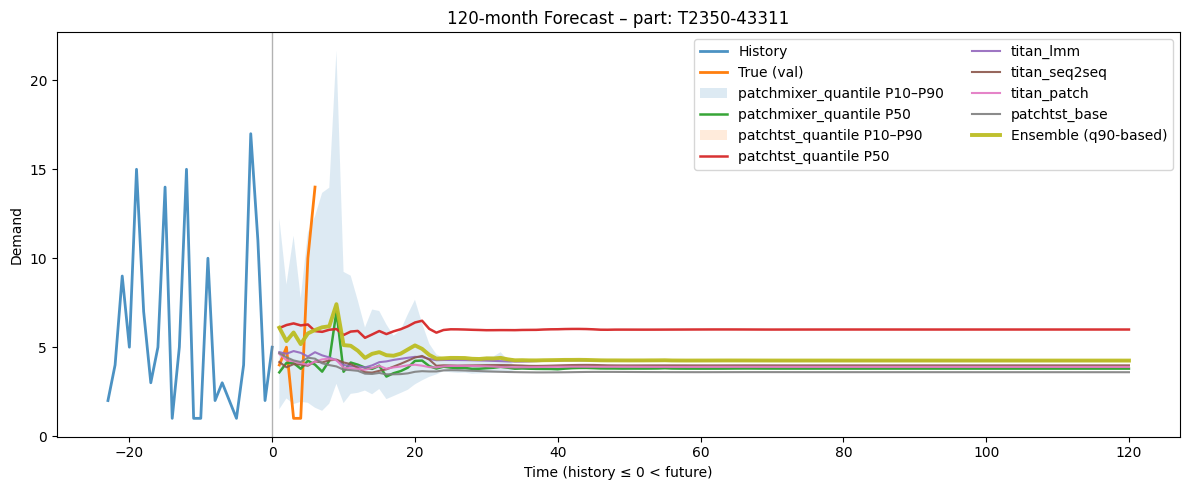

model PatchMixer QuantileModel [DBG] t 0 q10: 5.407113552093506 q50: 8.662160873413086 q90: 19.870811462402344
model PatchMixer QuantileModel [DBG] t 1 q10: 5.542272567749023 q50: 8.851073265075684 q90: 19.716209411621094
model PatchMixer QuantileModel [DBG] t 2 q10: 5.494318008422852 q50: 9.106828689575195 q90: 25.33590316772461
model PatchMixer QuantileModel [DBG] t 3 q10: 5.450295925140381 q50: 8.663993835449219 q90: 22.768184661865234
model PatchMixer QuantileModel [DBG] t 4 q10: 5.213131904602051 q50: 9.161073684692383 q90: 25.750802993774414
model PatchTST QuantileModel [DBG] t 0 q10: 11.041184425354004 q50: 11.14672565460205 q90: 11.266729354858398
model PatchTST QuantileModel [DBG] t 1 q10: 11.089695930480957 q50: 11.19602108001709 q90: 11.315274238586426
model PatchTST QuantileModel [DBG] t 2 q10: 11.38907241821289 q50: 11.492830276489258 q90: 11.609451293945312
model PatchTST QuantileModel [DBG] t 3 q10: 10.825952529907227 q50: 10.920177459716797 q90: 11.026931762695312
model

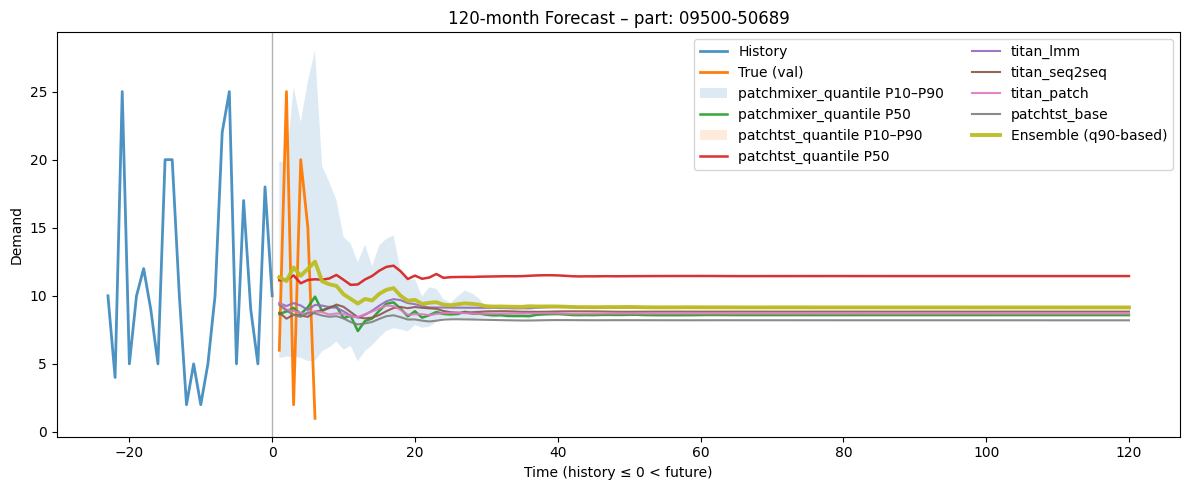

model PatchMixer QuantileModel [DBG] t 0 q10: 1.2268397808074951 q50: 1.9352312088012695 q90: 3.9088056087493896
model PatchMixer QuantileModel [DBG] t 1 q10: 1.3278040885925293 q50: 1.9763333797454834 q90: 3.5462231636047363
model PatchMixer QuantileModel [DBG] t 2 q10: 1.2516816854476929 q50: 1.9030499458312988 q90: 3.4549224376678467
model PatchMixer QuantileModel [DBG] t 3 q10: 1.2142021656036377 q50: 1.8552229404449463 q90: 3.627748489379883
model PatchMixer QuantileModel [DBG] t 4 q10: 1.3957968950271606 q50: 2.0244522094726562 q90: 3.541964054107666
model PatchTST QuantileModel [DBG] t 0 q10: 2.458364725112915 q50: 2.4824776649475098 q90: 2.5096585750579834
model PatchTST QuantileModel [DBG] t 1 q10: 2.3951613903045654 q50: 2.4188191890716553 q90: 2.445404291152954
model PatchTST QuantileModel [DBG] t 2 q10: 2.3708972930908203 q50: 2.394418954849243 q90: 2.4209866523742676
model PatchTST QuantileModel [DBG] t 3 q10: 2.428922176361084 q50: 2.4519717693328857 q90: 2.47810935974121

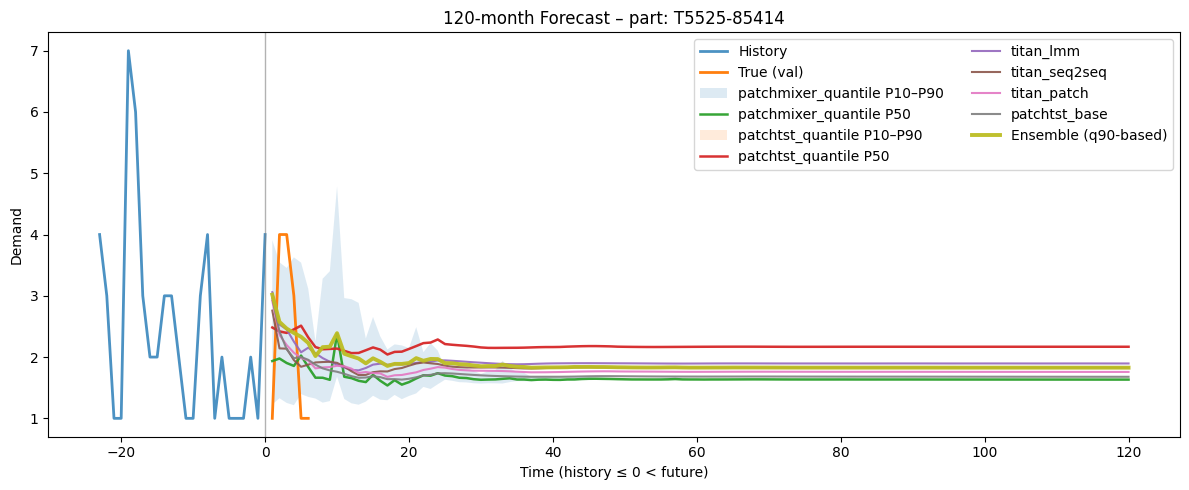

model PatchMixer QuantileModel [DBG] t 0 q10: 2.180133819580078 q50: 4.8048176765441895 q90: 11.91053581237793
model PatchMixer QuantileModel [DBG] t 1 q10: 1.7432284355163574 q50: 3.9635822772979736 q90: 12.20252513885498
model PatchMixer QuantileModel [DBG] t 2 q10: 2.171320676803589 q50: 4.189713001251221 q90: 9.186075210571289
model PatchMixer QuantileModel [DBG] t 3 q10: 1.8299744129180908 q50: 3.9311537742614746 q90: 11.015178680419922
model PatchMixer QuantileModel [DBG] t 4 q10: 2.105360507965088 q50: 3.9694676399230957 q90: 8.364490509033203
model PatchTST QuantileModel [DBG] t 0 q10: 6.624967575073242 q50: 6.716459274291992 q90: 6.819990634918213
model PatchTST QuantileModel [DBG] t 1 q10: 5.946310997009277 q50: 6.022152900695801 q90: 6.108246803283691
model PatchTST QuantileModel [DBG] t 2 q10: 5.947229862213135 q50: 6.023144245147705 q90: 6.109109878540039
model PatchTST QuantileModel [DBG] t 3 q10: 5.531968116760254 q50: 5.601566791534424 q90: 5.679721832275391
model Patch

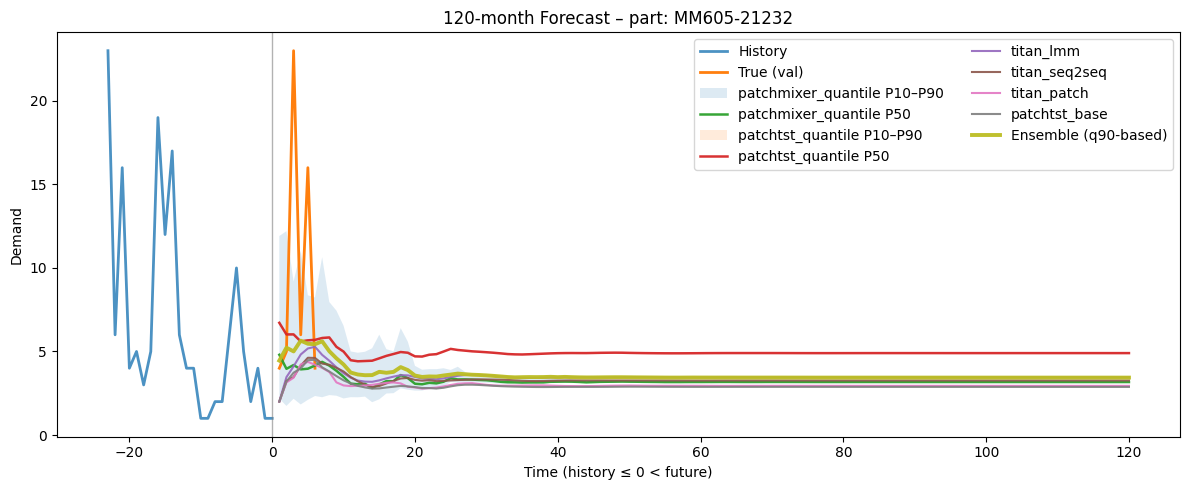

model PatchMixer QuantileModel [DBG] t 0 q10: -594.01708984375 q50: 920.23486328125 q90: 4599.947265625
model PatchMixer QuantileModel [DBG] t 1 q10: -609.341064453125 q50: 907.213623046875 q90: 4307.74609375
model PatchMixer QuantileModel [DBG] t 2 q10: -620.4075927734375 q50: 727.0416259765625 q90: 3897.40087890625
model PatchMixer QuantileModel [DBG] t 3 q10: -969.5167236328125 q50: 538.753173828125 q90: 4100.041015625
model PatchMixer QuantileModel [DBG] t 4 q10: -370.6578369140625 q50: 1204.5989990234375 q90: 5297.14404296875
model PatchTST QuantileModel [DBG] t 0 q10: 1947.5374755859375 q50: 2003.2432861328125 q90: 2065.543212890625
model PatchTST QuantileModel [DBG] t 1 q10: 2023.0716552734375 q50: 2078.51123046875 q90: 2140.44970703125
model PatchTST QuantileModel [DBG] t 2 q10: 2071.267333984375 q50: 2126.320556640625 q90: 2188.44189453125
model PatchTST QuantileModel [DBG] t 3 q10: 2126.730712890625 q50: 2181.57421875 q90: 2243.596435546875
model PatchTST QuantileModel [DBG] 

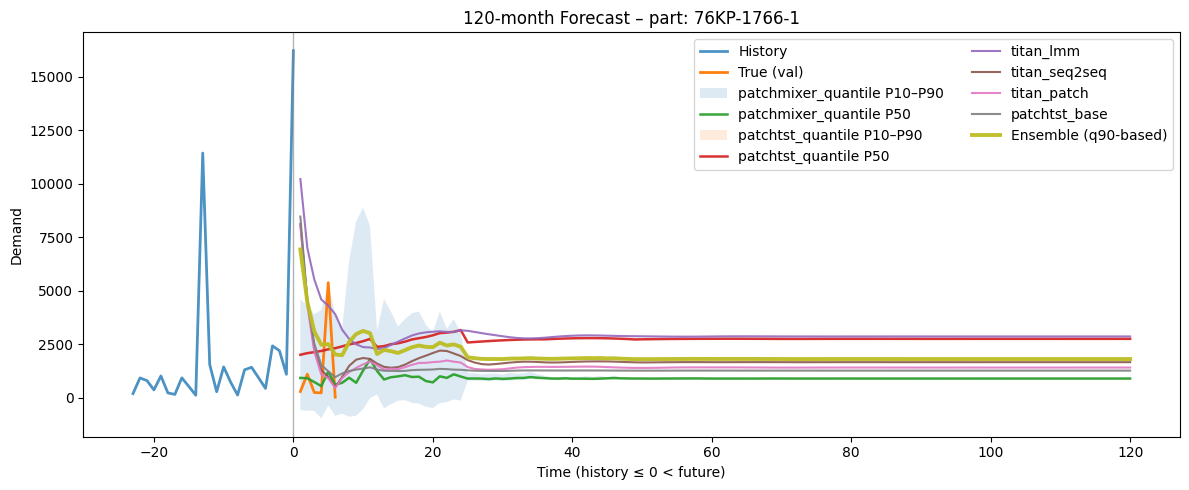

model PatchMixer QuantileModel [DBG] t 0 q10: 5.351291656494141 q50: 17.68564224243164 q90: 50.196250915527344
model PatchMixer QuantileModel [DBG] t 1 q10: 5.522092819213867 q50: 18.3730411529541 q90: 62.86370086669922
model PatchMixer QuantileModel [DBG] t 2 q10: 5.994342803955078 q50: 18.882389068603516 q90: 64.9366455078125
model PatchMixer QuantileModel [DBG] t 3 q10: 4.120922088623047 q50: 15.734374046325684 q90: 43.73300552368164
model PatchMixer QuantileModel [DBG] t 4 q10: 5.403566360473633 q50: 16.948375701904297 q90: 46.35834884643555
model PatchTST QuantileModel [DBG] t 0 q10: 27.29315757751465 q50: 27.724624633789062 q90: 28.207429885864258
model PatchTST QuantileModel [DBG] t 1 q10: 28.281036376953125 q50: 28.705364227294922 q90: 29.18163299560547
model PatchTST QuantileModel [DBG] t 2 q10: 27.768707275390625 q50: 28.191679000854492 q90: 28.665212631225586
model PatchTST QuantileModel [DBG] t 3 q10: 26.776350021362305 q50: 27.190404891967773 q90: 27.658430099487305
model 

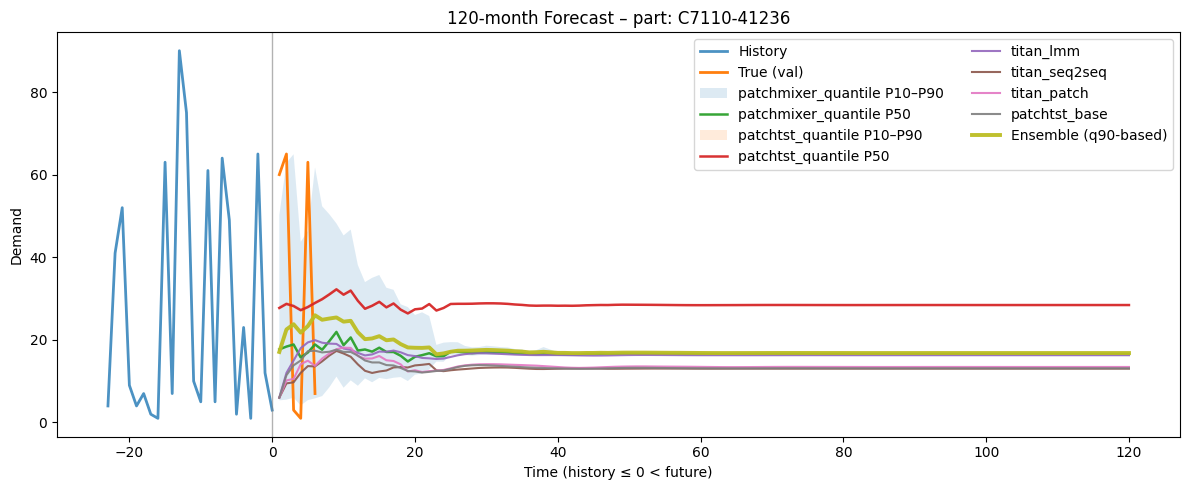

model PatchMixer QuantileModel [DBG] t 0 q10: 14.300086975097656 q50: 28.87104034423828 q90: 77.85244750976562
model PatchMixer QuantileModel [DBG] t 1 q10: 10.457696914672852 q50: 27.943599700927734 q90: 99.15278625488281
model PatchMixer QuantileModel [DBG] t 2 q10: 16.391788482666016 q50: 27.780162811279297 q90: 63.802642822265625
model PatchMixer QuantileModel [DBG] t 3 q10: 14.0665283203125 q50: 30.061986923217773 q90: 98.03052520751953
model PatchMixer QuantileModel [DBG] t 4 q10: 15.614158630371094 q50: 30.215465545654297 q90: 89.55400085449219
model PatchTST QuantileModel [DBG] t 0 q10: 35.04041290283203 q50: 35.455379486083984 q90: 35.9271240234375
model PatchTST QuantileModel [DBG] t 1 q10: 35.352806091308594 q50: 35.77090072631836 q90: 36.2381591796875
model PatchTST QuantileModel [DBG] t 2 q10: 36.3851318359375 q50: 36.79424285888672 q90: 37.25541305541992
model PatchTST QuantileModel [DBG] t 3 q10: 36.91836166381836 q50: 37.326385498046875 q90: 37.784942626953125
model Pat

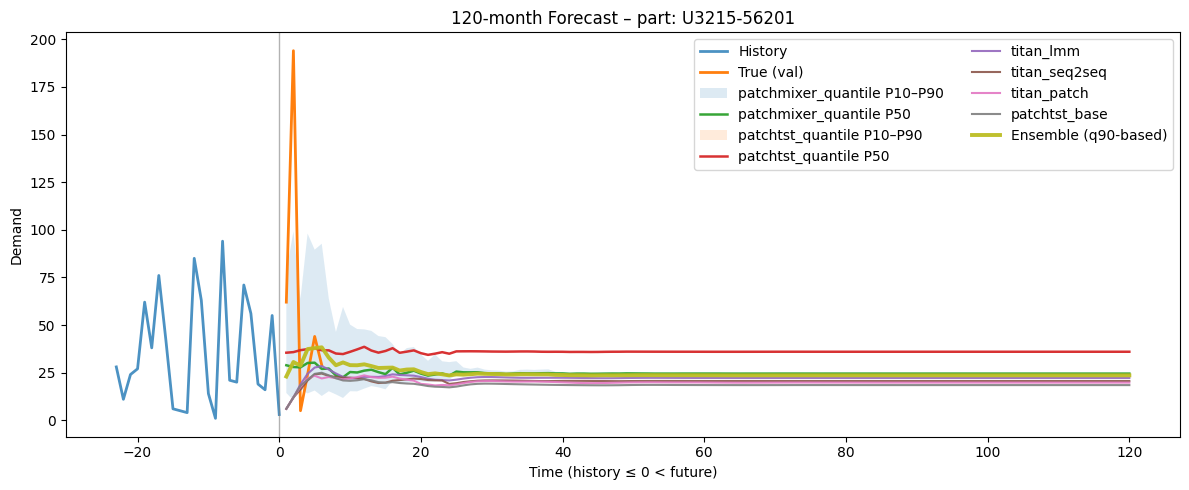

model PatchMixer QuantileModel [DBG] t 0 q10: 15.428361892700195 q50: 31.29497528076172 q90: 104.96267700195312
model PatchMixer QuantileModel [DBG] t 1 q10: 27.92774200439453 q50: 43.50921630859375 q90: 107.79611206054688
model PatchMixer QuantileModel [DBG] t 2 q10: 17.721214294433594 q50: 33.8785285949707 q90: 94.10262298583984
model PatchMixer QuantileModel [DBG] t 3 q10: 19.54454803466797 q50: 32.25625228881836 q90: 78.95567321777344
model PatchMixer QuantileModel [DBG] t 4 q10: 20.617679595947266 q50: 32.446144104003906 q90: 65.08670043945312
model PatchTST QuantileModel [DBG] t 0 q10: 43.083473205566406 q50: 43.56624221801758 q90: 44.109188079833984
model PatchTST QuantileModel [DBG] t 1 q10: 44.392547607421875 q50: 44.85890579223633 q90: 45.3967399597168
model PatchTST QuantileModel [DBG] t 2 q10: 42.14235305786133 q50: 42.5822639465332 q90: 43.07900619506836
model PatchTST QuantileModel [DBG] t 3 q10: 43.00223159790039 q50: 43.44013214111328 q90: 43.929866790771484
model Patch

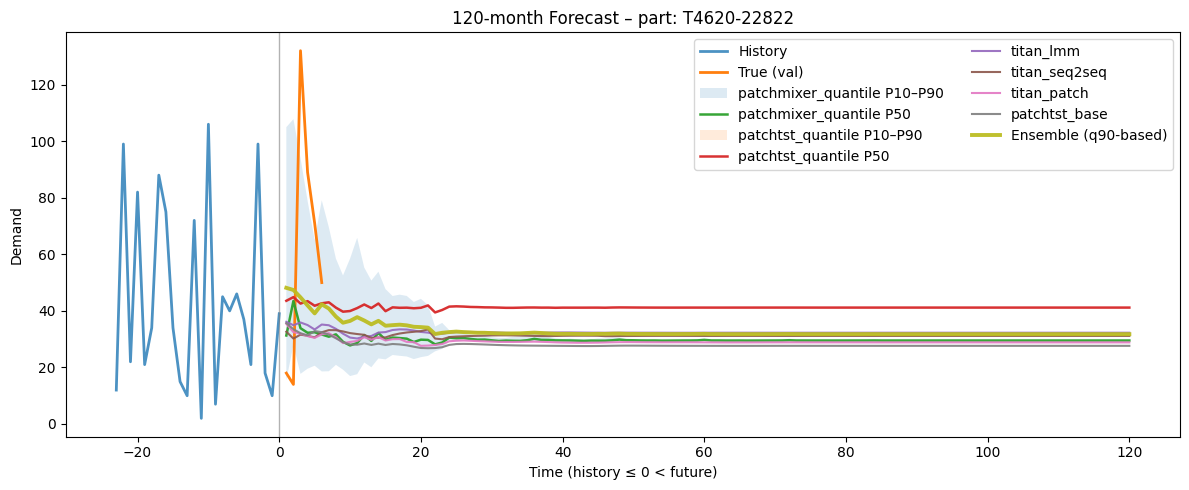

model PatchMixer QuantileModel [DBG] t 0 q10: 3.5128746032714844 q50: 23.563518524169922 q90: 71.86278533935547
model PatchMixer QuantileModel [DBG] t 1 q10: 3.1994171142578125 q50: 23.11931610107422 q90: 69.36701965332031
model PatchMixer QuantileModel [DBG] t 2 q10: 4.392889022827148 q50: 25.31487274169922 q90: 82.02689361572266
model PatchMixer QuantileModel [DBG] t 3 q10: 5.960432052612305 q50: 25.902172088623047 q90: 73.81979370117188
model PatchMixer QuantileModel [DBG] t 4 q10: 8.573190689086914 q50: 20.142414093017578 q90: 57.271507263183594
model PatchTST QuantileModel [DBG] t 0 q10: 38.043243408203125 q50: 38.77826690673828 q90: 39.60265350341797
model PatchTST QuantileModel [DBG] t 1 q10: 37.1585807800293 q50: 37.888938903808594 q90: 38.71199035644531
model PatchTST QuantileModel [DBG] t 2 q10: 37.27838897705078 q50: 38.011051177978516 q90: 38.83049774169922
model PatchTST QuantileModel [DBG] t 3 q10: 38.651397705078125 q50: 39.37277603149414 q90: 40.18754196166992
model Pat

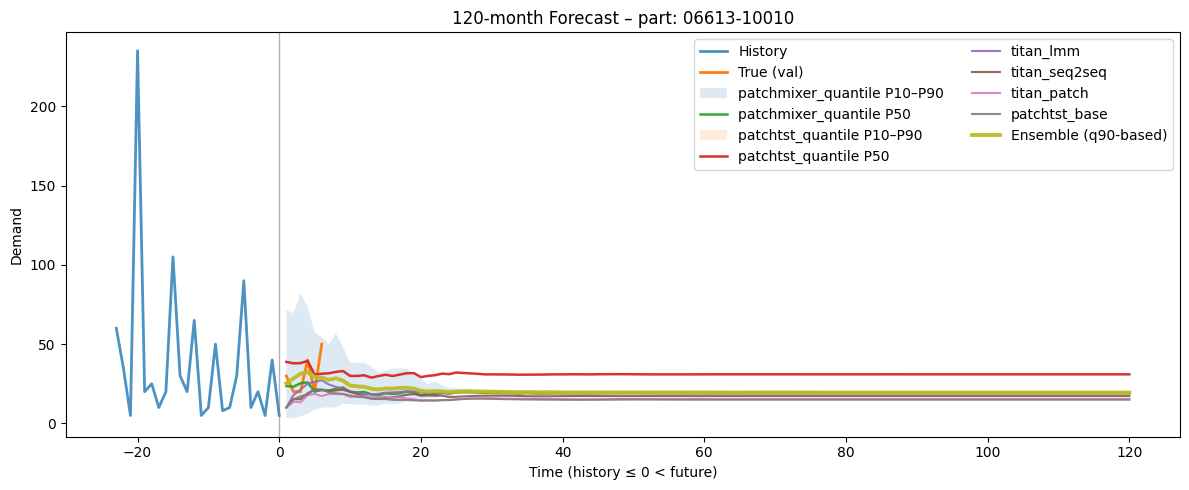

model PatchMixer QuantileModel [DBG] t 0 q10: 5.9852447509765625 q50: 18.00739288330078 q90: 52.98255920410156
model PatchMixer QuantileModel [DBG] t 1 q10: 8.543994903564453 q50: 21.518203735351562 q90: 66.57598876953125
model PatchMixer QuantileModel [DBG] t 2 q10: 9.324005126953125 q50: 21.536039352416992 q90: 56.26594543457031
model PatchMixer QuantileModel [DBG] t 3 q10: 5.785491943359375 q50: 18.998571395874023 q90: 59.38001251220703
model PatchMixer QuantileModel [DBG] t 4 q10: 7.481714248657227 q50: 17.829933166503906 q90: 42.41794204711914
model PatchTST QuantileModel [DBG] t 0 q10: 27.709760665893555 q50: 28.145715713500977 q90: 28.63176155090332
model PatchTST QuantileModel [DBG] t 1 q10: 28.46438217163086 q50: 28.89421272277832 q90: 29.37806510925293
model PatchTST QuantileModel [DBG] t 2 q10: 29.377151489257812 q50: 29.801776885986328 q90: 30.27984619140625
model PatchTST QuantileModel [DBG] t 3 q10: 28.533761978149414 q50: 28.9521541595459 q90: 29.42565155029297
model Pat

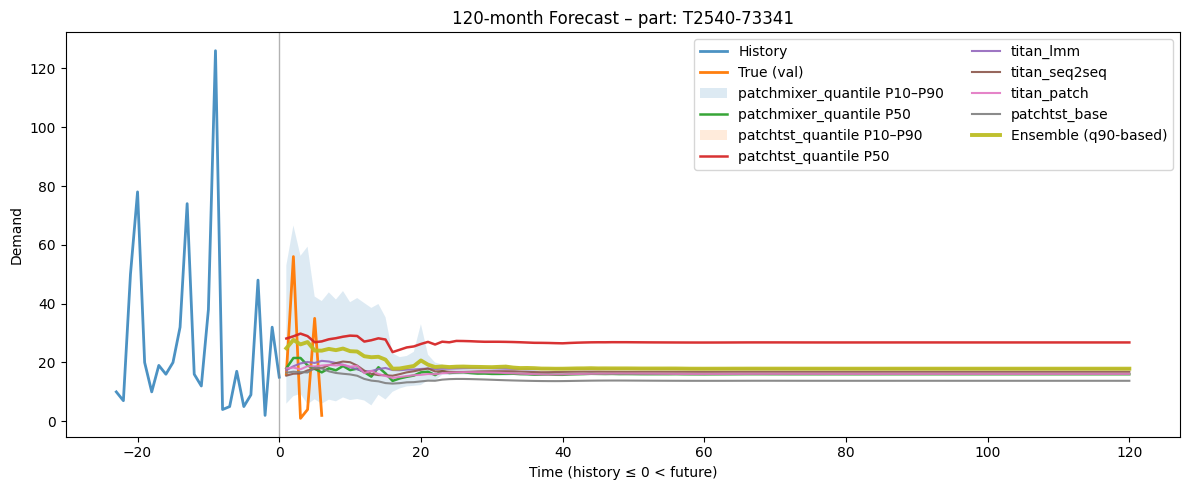

model PatchMixer QuantileModel [DBG] t 0 q10: 1.3658790588378906 q50: 2.4413459300994873 q90: 6.496913909912109
model PatchMixer QuantileModel [DBG] t 1 q10: 0.9783103466033936 q50: 1.7689409255981445 q90: 4.743762969970703
model PatchMixer QuantileModel [DBG] t 2 q10: 1.1072860956192017 q50: 1.698962688446045 q90: 3.3501105308532715
model PatchMixer QuantileModel [DBG] t 3 q10: 1.1336758136749268 q50: 1.7318602800369263 q90: 3.5948567390441895
model PatchMixer QuantileModel [DBG] t 4 q10: 0.9668903946876526 q50: 1.4983998537063599 q90: 2.7805795669555664
model PatchTST QuantileModel [DBG] t 0 q10: 1.9583499431610107 q50: 1.9788720607757568 q90: 2.0020182132720947
model PatchTST QuantileModel [DBG] t 1 q10: 1.999127745628357 q50: 2.0194196701049805 q90: 2.0423078536987305
model PatchTST QuantileModel [DBG] t 2 q10: 2.0000009536743164 q50: 2.020416736602783 q90: 2.0431902408599854
model PatchTST QuantileModel [DBG] t 3 q10: 2.000800848007202 q50: 2.021130323410034 q90: 2.043986558914184

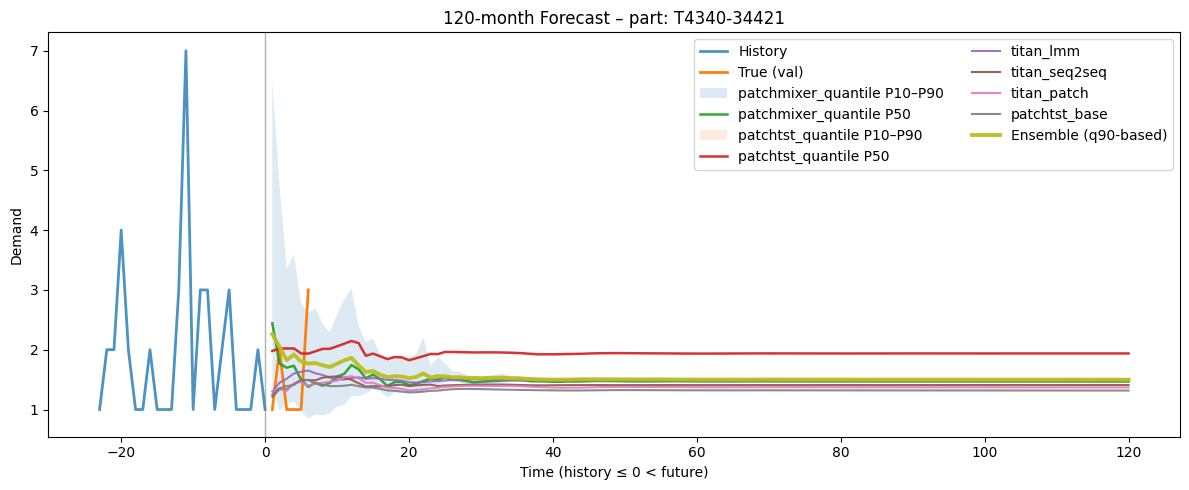

model PatchMixer QuantileModel [DBG] t 0 q10: 3.8465688228607178 q50: 5.6322503089904785 q90: 12.05225658416748
model PatchMixer QuantileModel [DBG] t 1 q10: 3.7150228023529053 q50: 5.486929893493652 q90: 12.19550895690918
model PatchMixer QuantileModel [DBG] t 2 q10: 4.503589630126953 q50: 6.024745941162109 q90: 10.864493370056152
model PatchMixer QuantileModel [DBG] t 3 q10: 4.121214866638184 q50: 5.578860282897949 q90: 10.338573455810547
model PatchMixer QuantileModel [DBG] t 4 q10: 4.0273637771606445 q50: 5.807161331176758 q90: 11.017606735229492
model PatchTST QuantileModel [DBG] t 0 q10: 6.833580493927002 q50: 6.892335891723633 q90: 6.958076477050781
model PatchTST QuantileModel [DBG] t 1 q10: 6.53727388381958 q50: 6.591534614562988 q90: 6.652291297912598
model PatchTST QuantileModel [DBG] t 2 q10: 6.686976909637451 q50: 6.740055561065674 q90: 6.799559593200684
model PatchTST QuantileModel [DBG] t 3 q10: 6.801095962524414 q50: 6.853410243988037 q90: 6.912219047546387
model PatchT

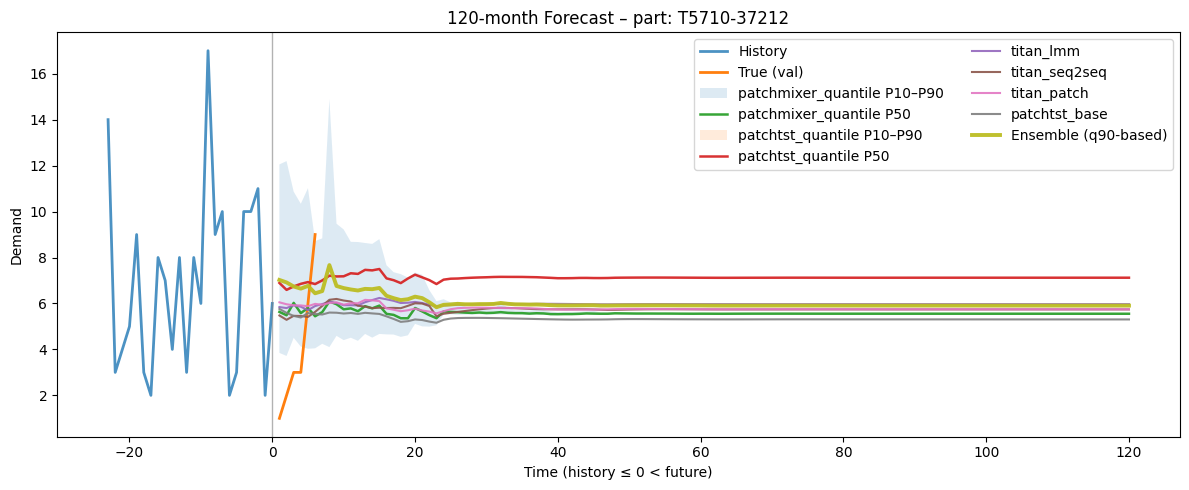

model PatchMixer QuantileModel [DBG] t 0 q10: -11.56201171875 q50: 264.90899658203125 q90: 815.513916015625
model PatchMixer QuantileModel [DBG] t 1 q10: 31.3133544921875 q50: 316.3821716308594 q90: 994.19921875
model PatchMixer QuantileModel [DBG] t 2 q10: -51.993316650390625 q50: 224.555908203125 q90: 827.0809326171875
model PatchMixer QuantileModel [DBG] t 3 q10: -28.989105224609375 q50: 261.7192687988281 q90: 866.3952026367188
model PatchMixer QuantileModel [DBG] t 4 q10: 29.514129638671875 q50: 311.138427734375 q90: 992.6703491210938
model PatchTST QuantileModel [DBG] t 0 q10: 522.0942993164062 q50: 532.5634765625 q90: 544.3514404296875
model PatchTST QuantileModel [DBG] t 1 q10: 524.5872802734375 q50: 535.056396484375 q90: 546.8643798828125
model PatchTST QuantileModel [DBG] t 2 q10: 528.1649780273438 q50: 538.6331176757812 q90: 550.4183349609375
model PatchTST QuantileModel [DBG] t 3 q10: 540.1326904296875 q50: 550.6032104492188 q90: 562.3540649414062
model PatchTST QuantileMode

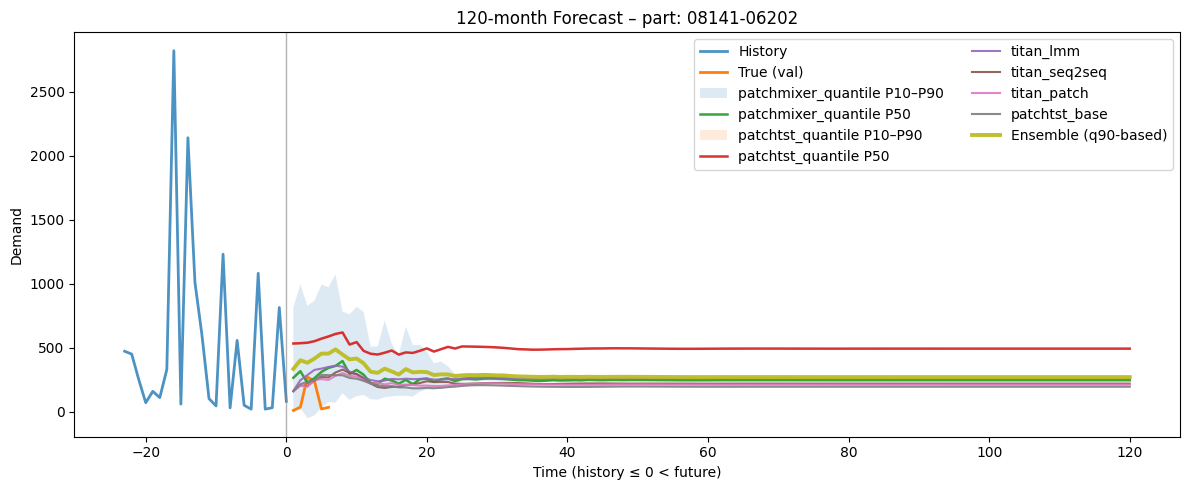

model PatchMixer QuantileModel [DBG] t 0 q10: 7.3220720291137695 q50: 15.844522476196289 q90: 42.815086364746094
model PatchMixer QuantileModel [DBG] t 1 q10: 7.233637809753418 q50: 16.55873680114746 q90: 54.29627990722656
model PatchMixer QuantileModel [DBG] t 2 q10: 5.986721038818359 q50: 17.636476516723633 q90: 61.462684631347656
model PatchMixer QuantileModel [DBG] t 3 q10: 5.98390007019043 q50: 18.332656860351562 q90: 71.11467742919922
model PatchMixer QuantileModel [DBG] t 4 q10: 8.138803482055664 q50: 18.63382911682129 q90: 64.81460571289062
model PatchTST QuantileModel [DBG] t 0 q10: 22.584091186523438 q50: 22.893972396850586 q90: 23.24125862121582
model PatchTST QuantileModel [DBG] t 1 q10: 23.454477310180664 q50: 23.757003784179688 q90: 24.09662437438965
model PatchTST QuantileModel [DBG] t 2 q10: 24.23619842529297 q50: 24.53296661376953 q90: 24.86705207824707
model PatchTST QuantileModel [DBG] t 3 q10: 24.840999603271484 q50: 25.13351058959961 q90: 25.464109420776367
model P

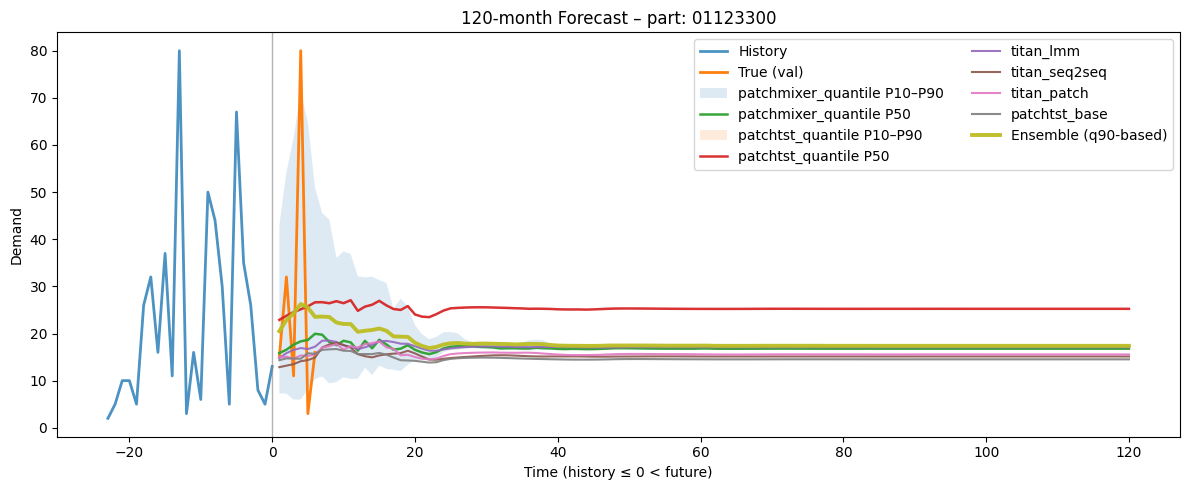

model PatchMixer QuantileModel [DBG] t 0 q10: 8.92131233215332 q50: 19.60808563232422 q90: 44.69268798828125
model PatchMixer QuantileModel [DBG] t 1 q10: 9.531892776489258 q50: 20.513790130615234 q90: 47.050453186035156
model PatchMixer QuantileModel [DBG] t 2 q10: 8.94938850402832 q50: 19.401973724365234 q90: 41.66860580444336
model PatchMixer QuantileModel [DBG] t 3 q10: 10.235832214355469 q50: 20.659568786621094 q90: 40.894752502441406
model PatchMixer QuantileModel [DBG] t 4 q10: 10.423606872558594 q50: 20.157564163208008 q90: 43.3876953125
model PatchTST QuantileModel [DBG] t 0 q10: 28.750246047973633 q50: 29.15353775024414 q90: 29.60940170288086
model PatchTST QuantileModel [DBG] t 1 q10: 29.380287170410156 q50: 29.781539916992188 q90: 30.234066009521484
model PatchTST QuantileModel [DBG] t 2 q10: 29.661972045898438 q50: 30.060585021972656 q90: 30.51327896118164
model PatchTST QuantileModel [DBG] t 3 q10: 30.167245864868164 q50: 30.566295623779297 q90: 31.016498565673828
model P

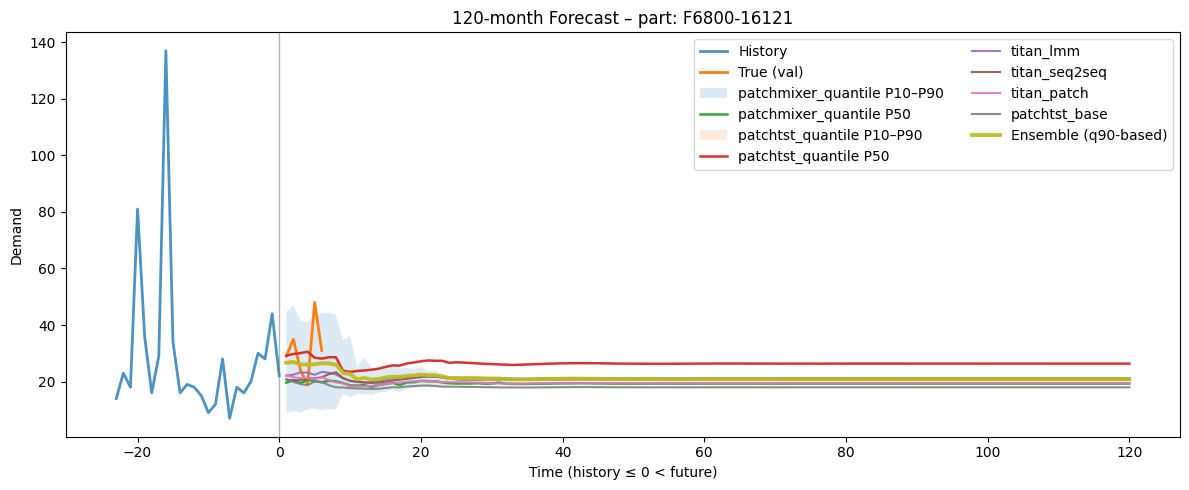

model PatchMixer QuantileModel [DBG] t 0 q10: 9.056675910949707 q50: 14.214008331298828 q90: 26.652692794799805
model PatchMixer QuantileModel [DBG] t 1 q10: 7.406447410583496 q50: 12.473742485046387 q90: 23.775136947631836
model PatchMixer QuantileModel [DBG] t 2 q10: 7.060890197753906 q50: 12.184418678283691 q90: 23.97417640686035
model PatchMixer QuantileModel [DBG] t 3 q10: 6.985522270202637 q50: 11.899714469909668 q90: 23.275718688964844
model PatchMixer QuantileModel [DBG] t 4 q10: 6.241664886474609 q50: 11.127275466918945 q90: 20.78558349609375
model PatchTST QuantileModel [DBG] t 0 q10: 17.750080108642578 q50: 17.93834686279297 q90: 18.150545120239258
model PatchTST QuantileModel [DBG] t 1 q10: 17.455808639526367 q50: 17.642284393310547 q90: 17.853132247924805
model PatchTST QuantileModel [DBG] t 2 q10: 17.356700897216797 q50: 17.543018341064453 q90: 17.75364875793457
model PatchTST QuantileModel [DBG] t 3 q10: 17.504650115966797 q50: 17.690887451171875 q90: 17.900747299194336


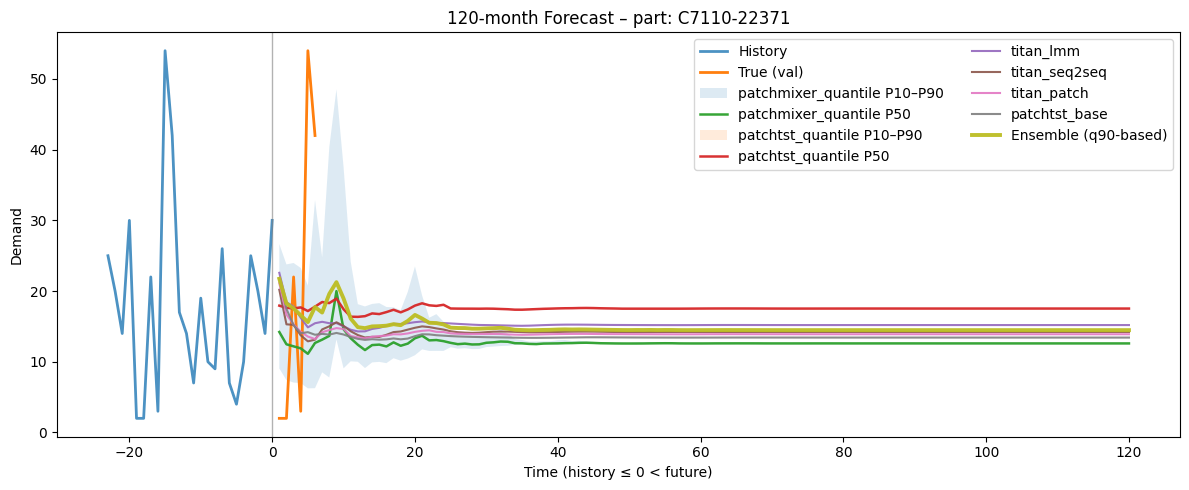

model PatchMixer QuantileModel [DBG] t 0 q10: 1.690047264099121 q50: 2.8285634517669678 q90: 6.843743801116943
model PatchMixer QuantileModel [DBG] t 1 q10: 2.0381319522857666 q50: 2.8995022773742676 q90: 5.003659725189209
model PatchMixer QuantileModel [DBG] t 2 q10: 1.9530014991760254 q50: 2.834827184677124 q90: 4.930174827575684
model PatchMixer QuantileModel [DBG] t 3 q10: 1.7816780805587769 q50: 2.608433961868286 q90: 4.588021755218506
model PatchMixer QuantileModel [DBG] t 4 q10: 1.9291861057281494 q50: 2.7648863792419434 q90: 4.788918495178223
model PatchTST QuantileModel [DBG] t 0 q10: 3.499795436859131 q50: 3.5320701599121094 q90: 3.5687124729156494
model PatchTST QuantileModel [DBG] t 1 q10: 3.4804868698120117 q50: 3.5128085613250732 q90: 3.549255132675171
model PatchTST QuantileModel [DBG] t 2 q10: 3.501923084259033 q50: 3.534205436706543 q90: 3.570706367492676
model PatchTST QuantileModel [DBG] t 3 q10: 3.3575363159179688 q50: 3.3880128860473633 q90: 3.422288179397583
model

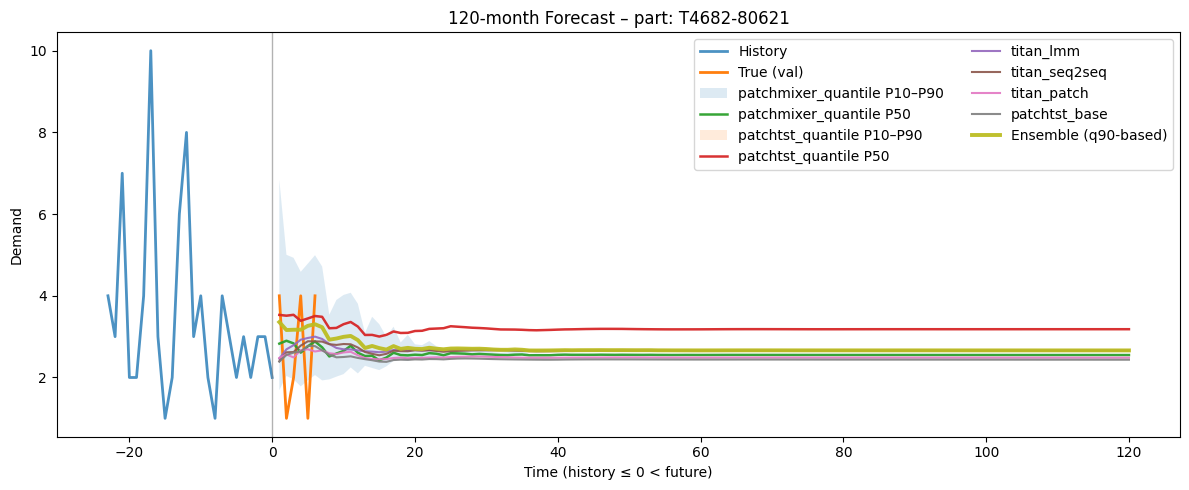

model PatchMixer QuantileModel [DBG] t 0 q10: 1.580225944519043 q50: 8.875387191772461 q90: 38.759681701660156
model PatchMixer QuantileModel [DBG] t 1 q10: 9.26767349243164 q50: 18.74700927734375 q90: 52.980499267578125
model PatchMixer QuantileModel [DBG] t 2 q10: 3.007661819458008 q50: 9.031779289245605 q90: 29.796001434326172
model PatchMixer QuantileModel [DBG] t 3 q10: 3.873617649078369 q50: 9.232094764709473 q90: 25.179439544677734
model PatchMixer QuantileModel [DBG] t 4 q10: 3.431187629699707 q50: 7.69818115234375 q90: 16.96694564819336
model PatchTST QuantileModel [DBG] t 0 q10: 11.249776840209961 q50: 11.430781364440918 q90: 11.635384559631348
model PatchTST QuantileModel [DBG] t 1 q10: 11.642936706542969 q50: 11.821894645690918 q90: 12.023419380187988
model PatchTST QuantileModel [DBG] t 2 q10: 11.218735694885254 q50: 11.394489288330078 q90: 11.593194007873535
model PatchTST QuantileModel [DBG] t 3 q10: 11.444291114807129 q50: 11.620595932006836 q90: 11.817158699035645
mode

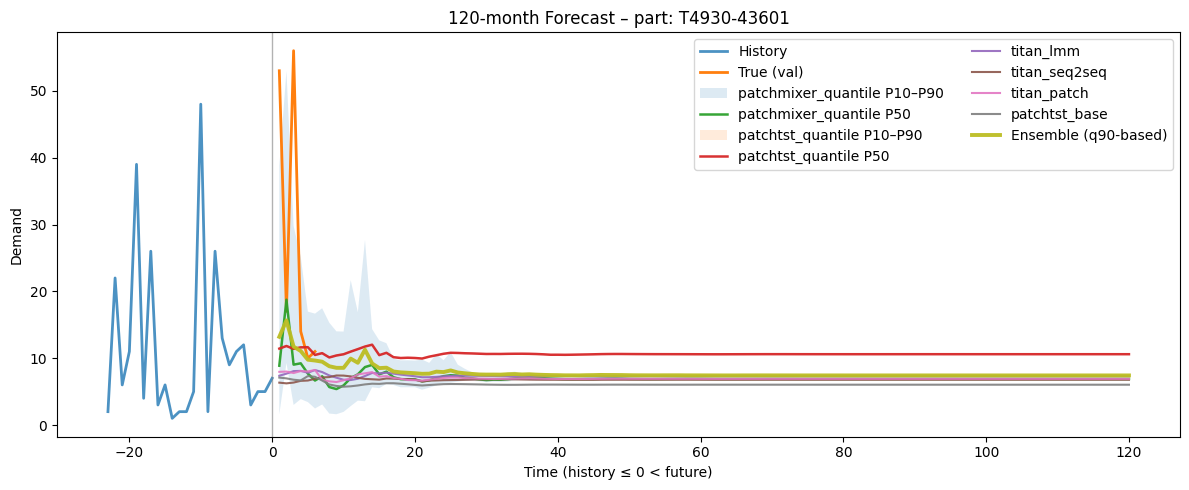

model PatchMixer QuantileModel [DBG] t 0 q10: 2.821338653564453 q50: 5.842726707458496 q90: 14.282194137573242
model PatchMixer QuantileModel [DBG] t 1 q10: 3.5093650817871094 q50: 6.287219047546387 q90: 14.710089683532715
model PatchMixer QuantileModel [DBG] t 2 q10: 5.456632614135742 q50: 8.22262954711914 q90: 17.104278564453125
model PatchMixer QuantileModel [DBG] t 3 q10: 1.5312752723693848 q50: 4.480240345001221 q90: 13.226396560668945
model PatchMixer QuantileModel [DBG] t 4 q10: 2.288682460784912 q50: 5.260786056518555 q90: 13.631414413452148
model PatchTST QuantileModel [DBG] t 0 q10: 8.916804313659668 q50: 9.031331062316895 q90: 9.160202026367188
model PatchTST QuantileModel [DBG] t 1 q10: 9.210150718688965 q50: 9.32325553894043 q90: 9.449277877807617
model PatchTST QuantileModel [DBG] t 2 q10: 9.264867782592773 q50: 9.377579689025879 q90: 9.503764152526855
model PatchTST QuantileModel [DBG] t 3 q10: 9.113768577575684 q50: 9.225399017333984 q90: 9.351332664489746
model PatchTS

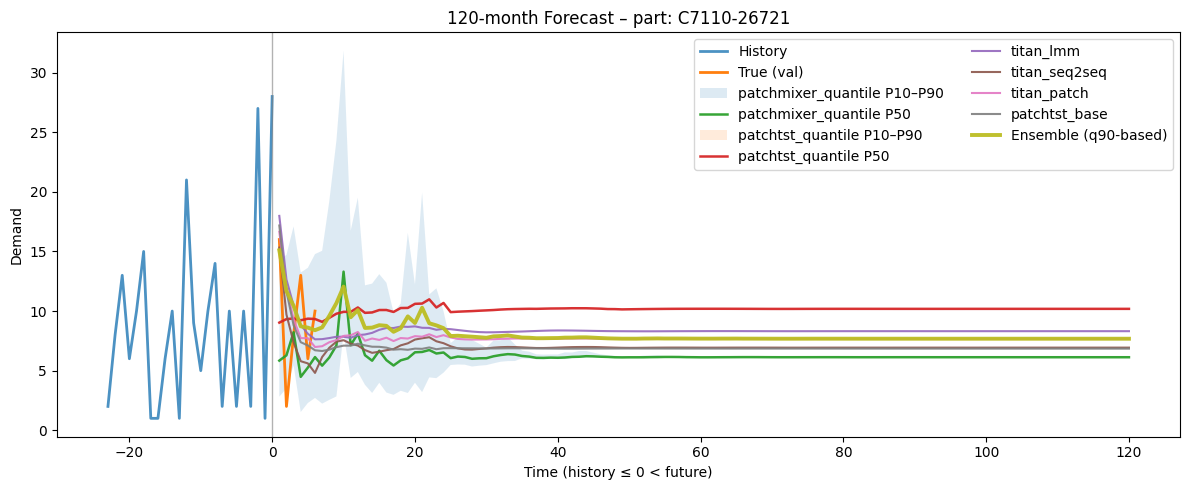

model PatchMixer QuantileModel [DBG] t 0 q10: 13.446155548095703 q50: 43.80921936035156 q90: 178.2402801513672
model PatchMixer QuantileModel [DBG] t 1 q10: 19.361297607421875 q50: 55.029178619384766 q90: 204.5899658203125
model PatchMixer QuantileModel [DBG] t 2 q10: 8.067413330078125 q50: 38.89369583129883 q90: 162.0410614013672
model PatchMixer QuantileModel [DBG] t 3 q10: 15.753719329833984 q50: 37.63371658325195 q90: 90.56978607177734
model PatchMixer QuantileModel [DBG] t 4 q10: 18.557628631591797 q50: 40.634437561035156 q90: 95.47100830078125
model PatchTST QuantileModel [DBG] t 0 q10: 60.29176330566406 q50: 61.188961029052734 q90: 62.198116302490234
model PatchTST QuantileModel [DBG] t 1 q10: 58.42826843261719 q50: 59.3150634765625 q90: 60.312103271484375
model PatchTST QuantileModel [DBG] t 2 q10: 53.89540481567383 q50: 54.71235275268555 q90: 55.631935119628906
model PatchTST QuantileModel [DBG] t 3 q10: 54.715049743652344 q50: 55.52769088745117 q90: 56.4475212097168
model Pat

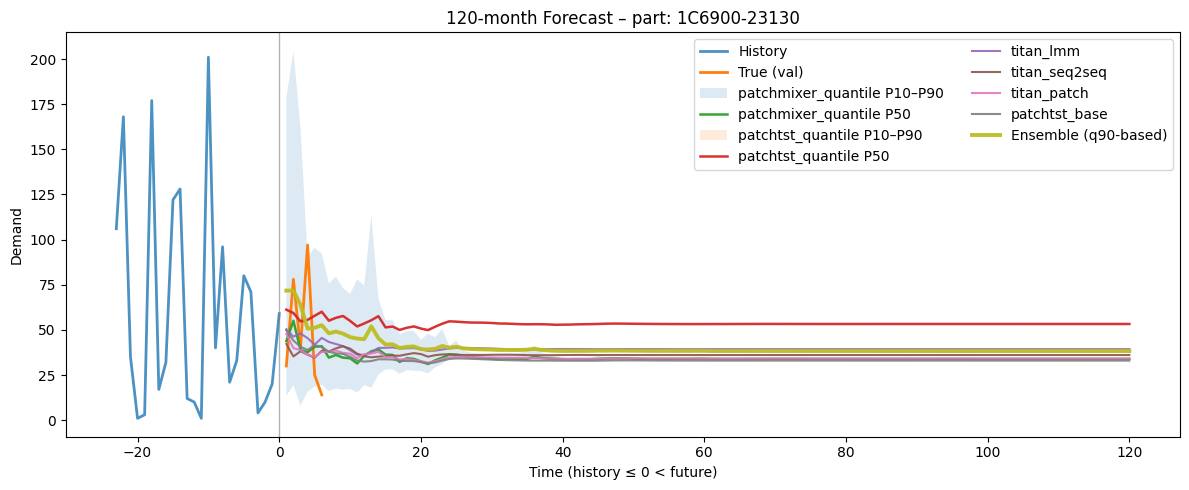

model PatchMixer QuantileModel [DBG] t 0 q10: 10.057221412658691 q50: 15.615036010742188 q90: 30.534523010253906
model PatchMixer QuantileModel [DBG] t 1 q10: 8.696354866027832 q50: 15.250273704528809 q90: 37.13136291503906
model PatchMixer QuantileModel [DBG] t 2 q10: 8.95475959777832 q50: 14.547978401184082 q90: 27.861236572265625
model PatchMixer QuantileModel [DBG] t 3 q10: 8.87812328338623 q50: 14.986517906188965 q90: 44.372867584228516
model PatchMixer QuantileModel [DBG] t 4 q10: 10.659747123718262 q50: 16.609317779541016 q90: 32.90628433227539
model PatchTST QuantileModel [DBG] t 0 q10: 20.584064483642578 q50: 20.79710578918457 q90: 21.036195755004883
model PatchTST QuantileModel [DBG] t 1 q10: 20.534053802490234 q50: 20.74800682067871 q90: 20.986175537109375
model PatchTST QuantileModel [DBG] t 2 q10: 20.981775283813477 q50: 21.192119598388672 q90: 21.428003311157227
model PatchTST QuantileModel [DBG] t 3 q10: 21.114612579345703 q50: 21.325002670288086 q90: 21.560571670532227


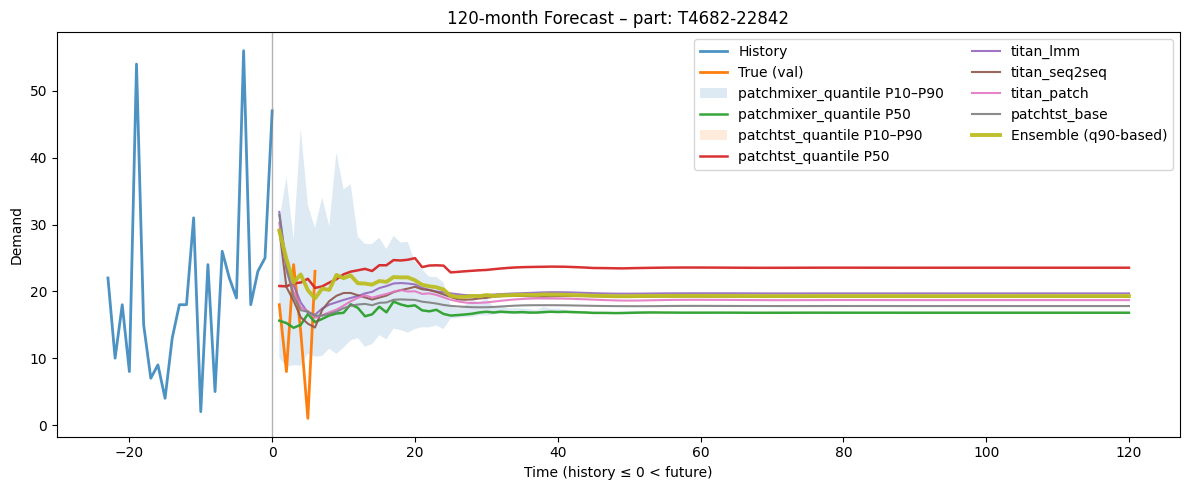

In [9]:
%load_ext autoreload
%autoreload 2

import importlib
import modeling_module.utils.plot_utils as plot_utils
importlib.reload(plot_utils)   # 선택: 확실히 새 코드로

plot_utils.plot_120_months_many(
    loaded, val_loader, device=device, use_truth=True,
    max_plots=100, show=True, future_exo_cb=calendar_cb
)